In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import FFNN_model
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import time
import sys
import os

## Load dataset

In [2]:
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"X data type: {X.dtype}")
print(f"y data type: {y.dtype}")

X shape: (70000, 784)
y shape: (70000,)
X data type: int64
y data type: object


convert string labels to int

In [3]:
y = y.astype(np.int64)
y.dtype

dtype('int64')

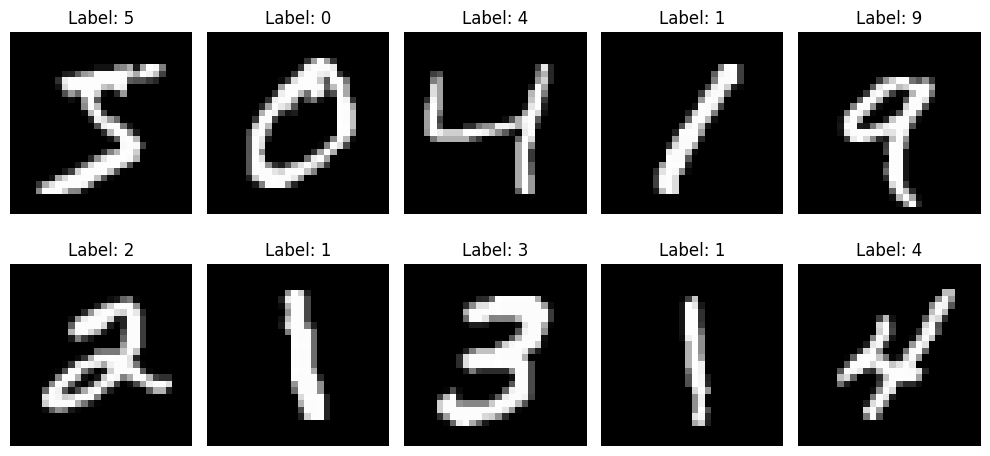

In [4]:
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X[i].reshape(28, 28), cmap='gray')
    plt.title(f"Label: {y[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

## Preprocessing Data

In [5]:
X_scaled = X/255.0

# One-hot encode the labels
encoder = OneHotEncoder(sparse_output=False)
y_onehot = encoder.fit_transform(y.reshape(-1, 1))

# Split the data
X_train, X_test, y_train_onehot, y_test_onehot = train_test_split(
    X_scaled, y_onehot, test_size=0.2, random_state=42
)

# original labels for evaluation
_, _, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)
print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 56000
Test set size: 14000


smaller data train for faster experiment

In [6]:
X_train_small, _, y_train_onehot_small, _ = train_test_split(
    X_train, y_train_onehot, test_size=0.8, random_state=42
)

X_test_small, _, y_test_onehot_small, _ = train_test_split(
    X_test, y_test_onehot, test_size=0.8, random_state=42
)

print(f"Small training set size: {X_train_small.shape[0]}")
print(f"Small test set size: {X_test_small.shape[0]}")

Small training set size: 11200
Small test set size: 2800


## Visualization

In [7]:
def evaluate_model(model, X_test, y_test_onehot, y_test):
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test_onehot, axis=1)
    
    accuracy = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred)
    
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(report)
    
    # Confusion Matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Plot some examples
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    for i, ax in enumerate(axes.flatten()):
        idx = np.random.randint(0, len(X_test))
        img = X_test[idx].reshape(28, 28)
        ax.imshow(img, cmap='gray')
        true_label = np.argmax(y_test_onehot[idx])
        pred_label = np.argmax(y_pred_probs[idx])
        ax.set_title(f"True: {true_label}, Pred: {pred_label}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
    return accuracy, y_pred

In [8]:
def plot_history(history):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Training Loss')
    if 'val_loss' in history:
        plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss History')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

## Experiment 1 : Effect of Depth and Width

In [9]:
# Define the different architectures
architectures = [
    # Varying width (fixed depth)
    {
        'name': 'Small width',
        'layers': [32, 10],
        'activations': ['relu', 'softmax']
    },
    {
        'name': 'Medium width',
        'layers': [64, 10],
        'activations': ['relu', 'softmax']
    },
    {
        'name': 'Large width',
        'layers': [128, 10],
        'activations': ['relu', 'softmax']
    },
    
    # Varying depth (fixed width)
    {
        'name': 'Shallow depth',
        'layers': [64, 10],
        'activations': ['relu', 'softmax']
    },
    {
        'name': 'Medium depth',
        'layers': [64, 32, 10],
        'activations': ['relu', 'relu', 'softmax']
    },
    {
        'name': 'Deep network',
        'layers': [128, 64, 32, 10],
        'activations': ['relu', 'relu', 'relu', 'softmax']
    }
]

params = {
    'epochs': 20,
    'batch_size': 32,
    'learning_rate': 0.01
}


Training model with architecture: Small width
Layers: [32, 10]
Activations: ['relu', 'softmax']
Epoch 1/20 [5.0%] - train_loss: 2.0889 - val_loss: 1.8780
Epoch 2/20 [10.0%] - train_loss: 1.7001 - val_loss: 1.5432
Epoch 3/20 [15.0%] - train_loss: 1.4063 - val_loss: 1.2859
Epoch 4/20 [20.0%] - train_loss: 1.1836 - val_loss: 1.0928
Epoch 5/20 [25.0%] - train_loss: 1.0187 - val_loss: 0.9521
Epoch 6/20 [30.0%] - train_loss: 0.9006 - val_loss: 0.8521
Epoch 7/20 [35.0%] - train_loss: 0.8152 - val_loss: 0.7785
Epoch 8/20 [40.0%] - train_loss: 0.7508 - val_loss: 0.7222
Epoch 9/20 [45.0%] - train_loss: 0.7006 - val_loss: 0.6773
Epoch 10/20 [50.0%] - train_loss: 0.6602 - val_loss: 0.6409
Epoch 11/20 [55.0%] - train_loss: 0.6270 - val_loss: 0.6107
Epoch 12/20 [60.0%] - train_loss: 0.5991 - val_loss: 0.5852
Epoch 13/20 [65.0%] - train_loss: 0.5753 - val_loss: 0.5633
Epoch 14/20 [70.0%] - train_loss: 0.5547 - val_loss: 0.5444
Epoch 15/20 [75.0%] - train_loss: 0.5368 - val_loss: 0.5276
Epoch 16/20 [

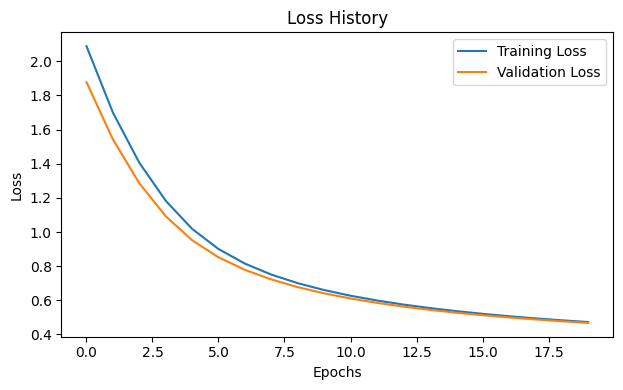


Evaluating model with Small width [32, 10] activation...
Accuracy: 0.8764
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.94      0.94      1343
           1       0.90      0.97      0.93      1600
           2       0.88      0.84      0.86      1380
           3       0.85      0.85      0.85      1433
           4       0.87      0.87      0.87      1295
           5       0.85      0.80      0.83      1273
           6       0.89      0.91      0.90      1396
           7       0.90      0.89      0.90      1503
           8       0.84      0.80      0.82      1357
           9       0.83      0.87      0.85      1420

    accuracy                           0.88     14000
   macro avg       0.88      0.87      0.87     14000
weighted avg       0.88      0.88      0.88     14000



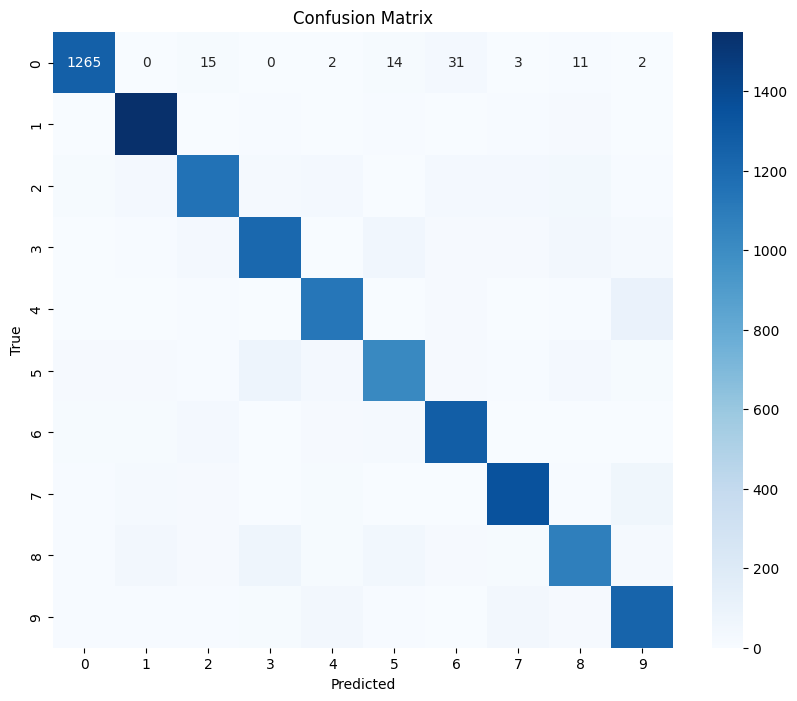

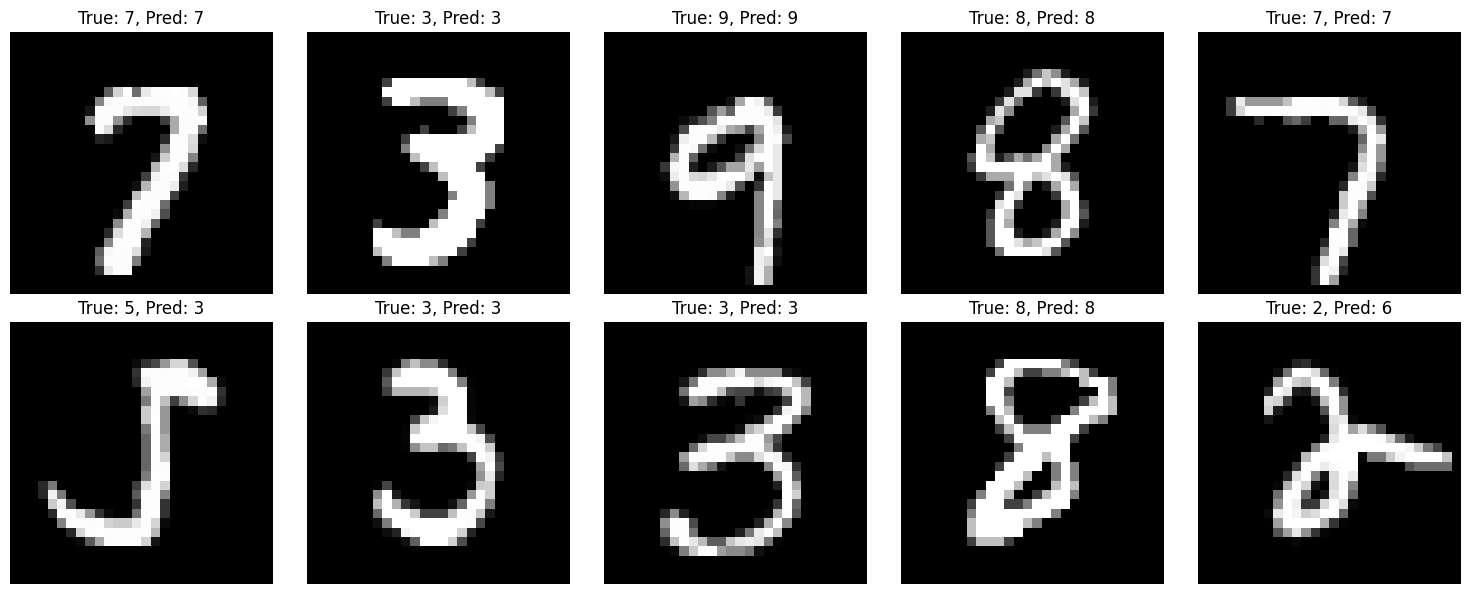


Training model with architecture: Medium width
Layers: [64, 10]
Activations: ['relu', 'softmax']
Epoch 1/20 [5.0%] - train_loss: 2.1349 - val_loss: 1.9080
Epoch 2/20 [10.0%] - train_loss: 1.7146 - val_loss: 1.5387
Epoch 3/20 [15.0%] - train_loss: 1.3953 - val_loss: 1.2640
Epoch 4/20 [20.0%] - train_loss: 1.1634 - val_loss: 1.0690
Epoch 5/20 [25.0%] - train_loss: 0.9993 - val_loss: 0.9302
Epoch 6/20 [30.0%] - train_loss: 0.8817 - val_loss: 0.8296
Epoch 7/20 [35.0%] - train_loss: 0.7953 - val_loss: 0.7548
Epoch 8/20 [40.0%] - train_loss: 0.7300 - val_loss: 0.6976
Epoch 9/20 [45.0%] - train_loss: 0.6794 - val_loss: 0.6524
Epoch 10/20 [50.0%] - train_loss: 0.6389 - val_loss: 0.6160
Epoch 11/20 [55.0%] - train_loss: 0.6059 - val_loss: 0.5861
Epoch 12/20 [60.0%] - train_loss: 0.5785 - val_loss: 0.5610
Epoch 13/20 [65.0%] - train_loss: 0.5553 - val_loss: 0.5397
Epoch 14/20 [70.0%] - train_loss: 0.5354 - val_loss: 0.5214
Epoch 15/20 [75.0%] - train_loss: 0.5182 - val_loss: 0.5053
Epoch 16/20 

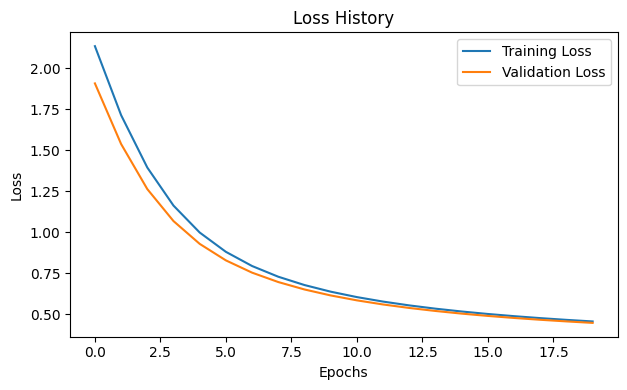


Evaluating model with Medium width [64, 10] activation...
Accuracy: 0.8825
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1343
           1       0.91      0.96      0.93      1600
           2       0.88      0.83      0.86      1380
           3       0.85      0.85      0.85      1433
           4       0.87      0.90      0.88      1295
           5       0.87      0.80      0.83      1273
           6       0.90      0.92      0.91      1396
           7       0.90      0.90      0.90      1503
           8       0.85      0.83      0.84      1357
           9       0.86      0.86      0.86      1420

    accuracy                           0.88     14000
   macro avg       0.88      0.88      0.88     14000
weighted avg       0.88      0.88      0.88     14000



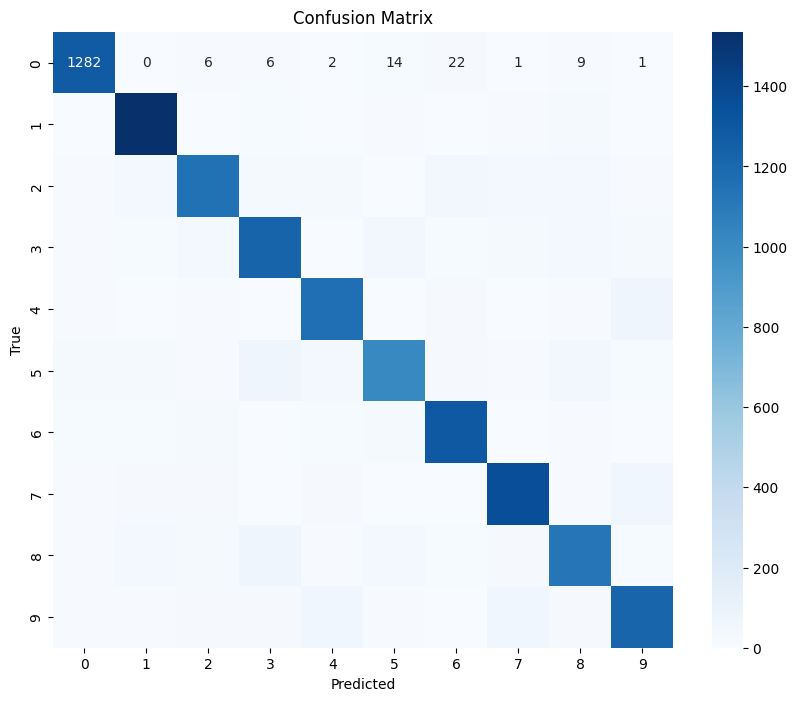

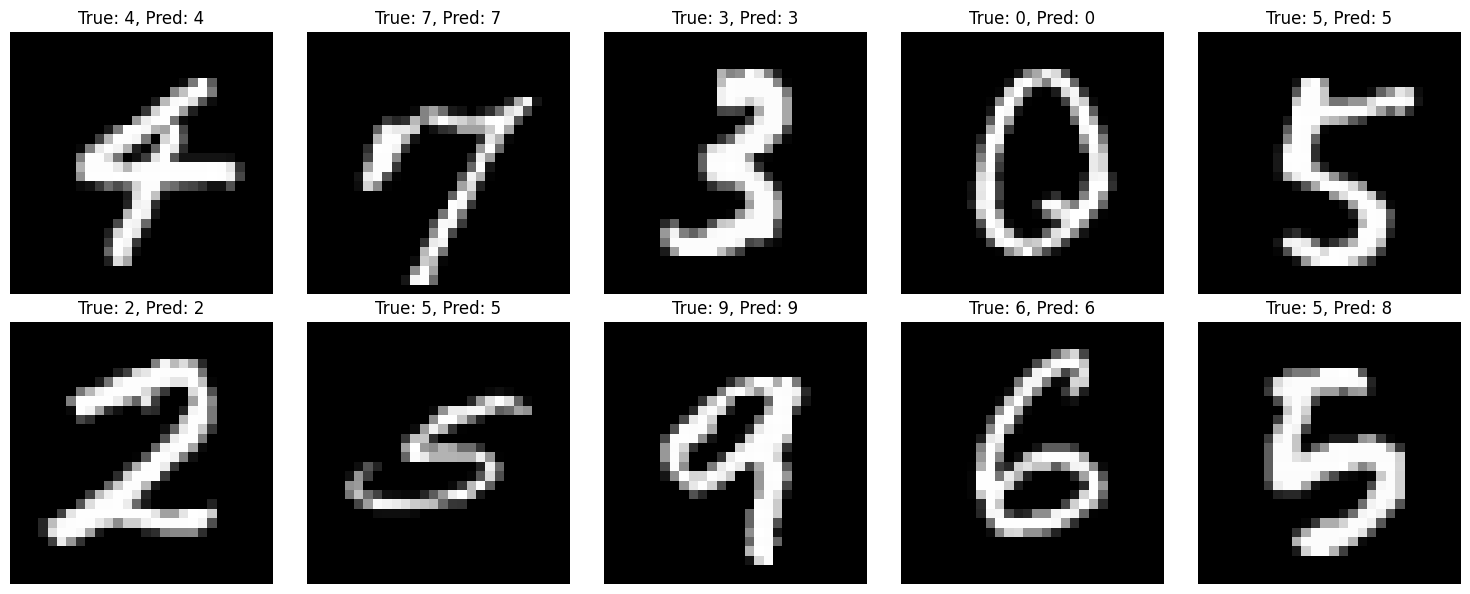


Training model with architecture: Large width
Layers: [128, 10]
Activations: ['relu', 'softmax']
Epoch 1/20 [5.0%] - train_loss: 2.0910 - val_loss: 1.8662
Epoch 2/20 [10.0%] - train_loss: 1.6726 - val_loss: 1.4964
Epoch 3/20 [15.0%] - train_loss: 1.3512 - val_loss: 1.2228
Epoch 4/20 [20.0%] - train_loss: 1.1232 - val_loss: 1.0343
Epoch 5/20 [25.0%] - train_loss: 0.9661 - val_loss: 0.9033
Epoch 6/20 [30.0%] - train_loss: 0.8554 - val_loss: 0.8094
Epoch 7/20 [35.0%] - train_loss: 0.7745 - val_loss: 0.7395
Epoch 8/20 [40.0%] - train_loss: 0.7131 - val_loss: 0.6857
Epoch 9/20 [45.0%] - train_loss: 0.6650 - val_loss: 0.6430
Epoch 10/20 [50.0%] - train_loss: 0.6263 - val_loss: 0.6082
Epoch 11/20 [55.0%] - train_loss: 0.5946 - val_loss: 0.5795
Epoch 12/20 [60.0%] - train_loss: 0.5680 - val_loss: 0.5552
Epoch 13/20 [65.0%] - train_loss: 0.5454 - val_loss: 0.5346
Epoch 14/20 [70.0%] - train_loss: 0.5260 - val_loss: 0.5167
Epoch 15/20 [75.0%] - train_loss: 0.5091 - val_loss: 0.5010
Epoch 16/20 

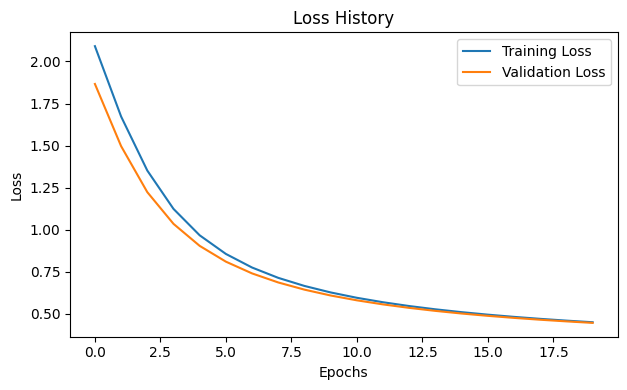


Evaluating model with Large width [128, 10] activation...
Accuracy: 0.8831
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1343
           1       0.91      0.97      0.94      1600
           2       0.87      0.84      0.86      1380
           3       0.86      0.86      0.86      1433
           4       0.87      0.89      0.88      1295
           5       0.87      0.79      0.83      1273
           6       0.90      0.92      0.91      1396
           7       0.90      0.90      0.90      1503
           8       0.84      0.83      0.83      1357
           9       0.85      0.85      0.85      1420

    accuracy                           0.88     14000
   macro avg       0.88      0.88      0.88     14000
weighted avg       0.88      0.88      0.88     14000



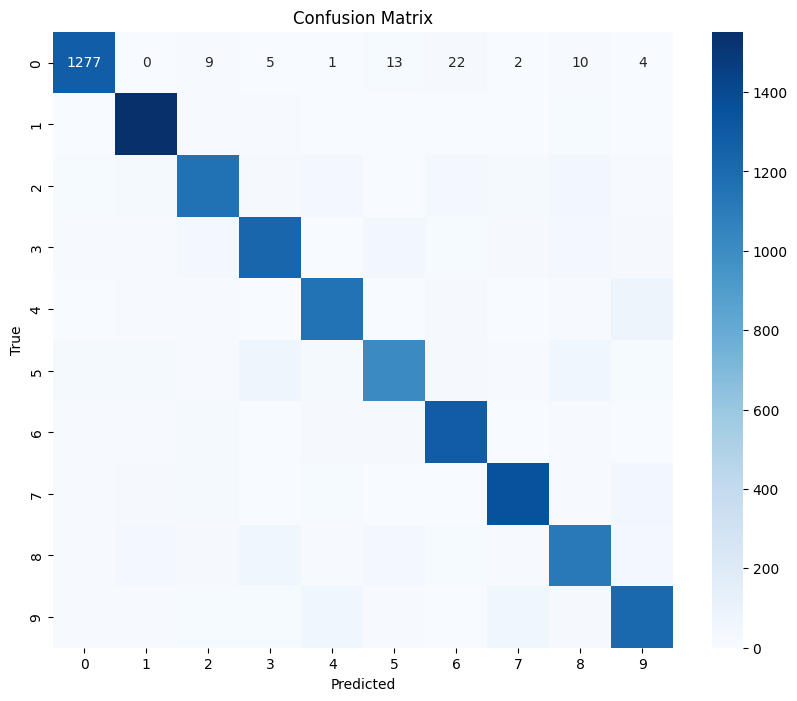

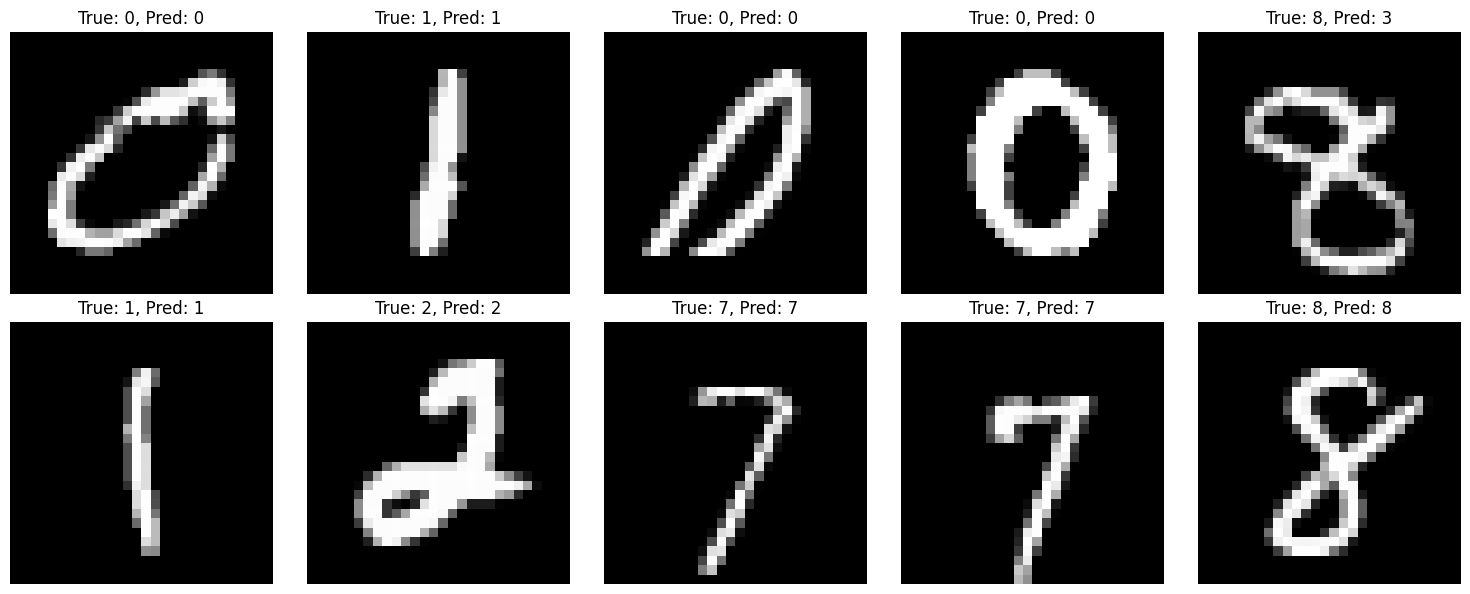


Training model with architecture: Shallow depth
Layers: [64, 10]
Activations: ['relu', 'softmax']
Epoch 1/20 [5.0%] - train_loss: 2.1349 - val_loss: 1.9080
Epoch 2/20 [10.0%] - train_loss: 1.7146 - val_loss: 1.5387
Epoch 3/20 [15.0%] - train_loss: 1.3953 - val_loss: 1.2640
Epoch 4/20 [20.0%] - train_loss: 1.1634 - val_loss: 1.0690
Epoch 5/20 [25.0%] - train_loss: 0.9993 - val_loss: 0.9302
Epoch 6/20 [30.0%] - train_loss: 0.8817 - val_loss: 0.8296
Epoch 7/20 [35.0%] - train_loss: 0.7953 - val_loss: 0.7548
Epoch 8/20 [40.0%] - train_loss: 0.7300 - val_loss: 0.6976
Epoch 9/20 [45.0%] - train_loss: 0.6794 - val_loss: 0.6524
Epoch 10/20 [50.0%] - train_loss: 0.6389 - val_loss: 0.6160
Epoch 11/20 [55.0%] - train_loss: 0.6059 - val_loss: 0.5861
Epoch 12/20 [60.0%] - train_loss: 0.5785 - val_loss: 0.5610
Epoch 13/20 [65.0%] - train_loss: 0.5553 - val_loss: 0.5397
Epoch 14/20 [70.0%] - train_loss: 0.5354 - val_loss: 0.5214
Epoch 15/20 [75.0%] - train_loss: 0.5182 - val_loss: 0.5053
Epoch 16/20

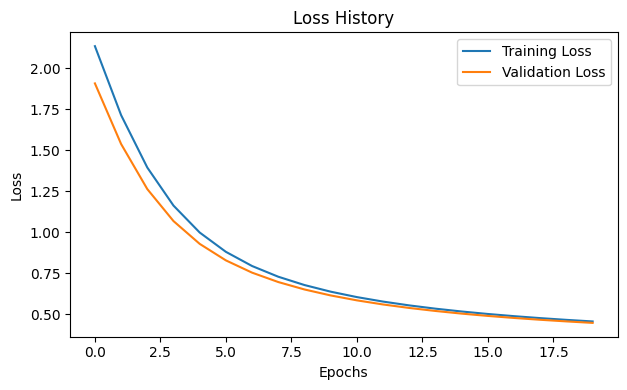


Evaluating model with Shallow depth [64, 10] activation...
Accuracy: 0.8825
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1343
           1       0.91      0.96      0.93      1600
           2       0.88      0.83      0.86      1380
           3       0.85      0.85      0.85      1433
           4       0.87      0.90      0.88      1295
           5       0.87      0.80      0.83      1273
           6       0.90      0.92      0.91      1396
           7       0.90      0.90      0.90      1503
           8       0.85      0.83      0.84      1357
           9       0.86      0.86      0.86      1420

    accuracy                           0.88     14000
   macro avg       0.88      0.88      0.88     14000
weighted avg       0.88      0.88      0.88     14000



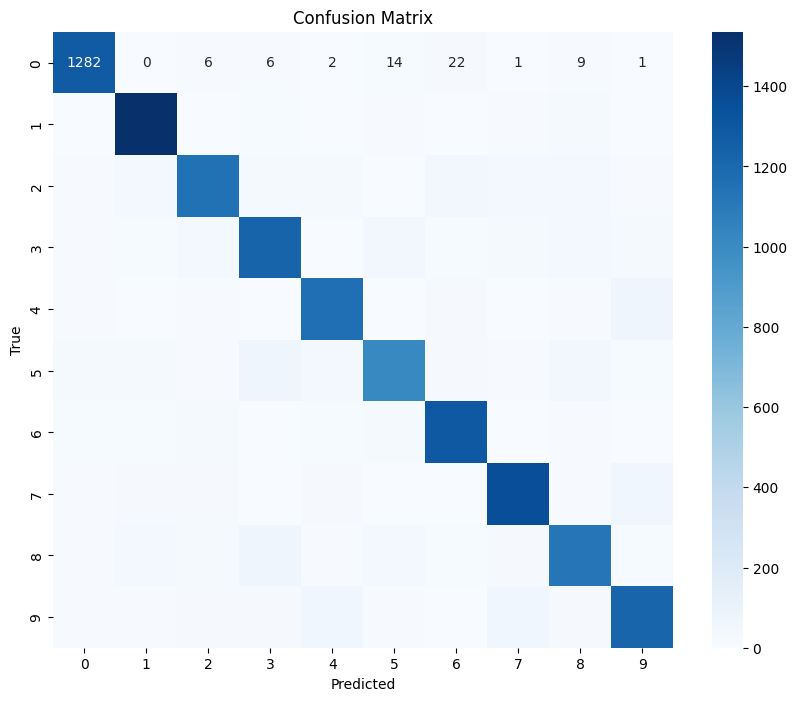

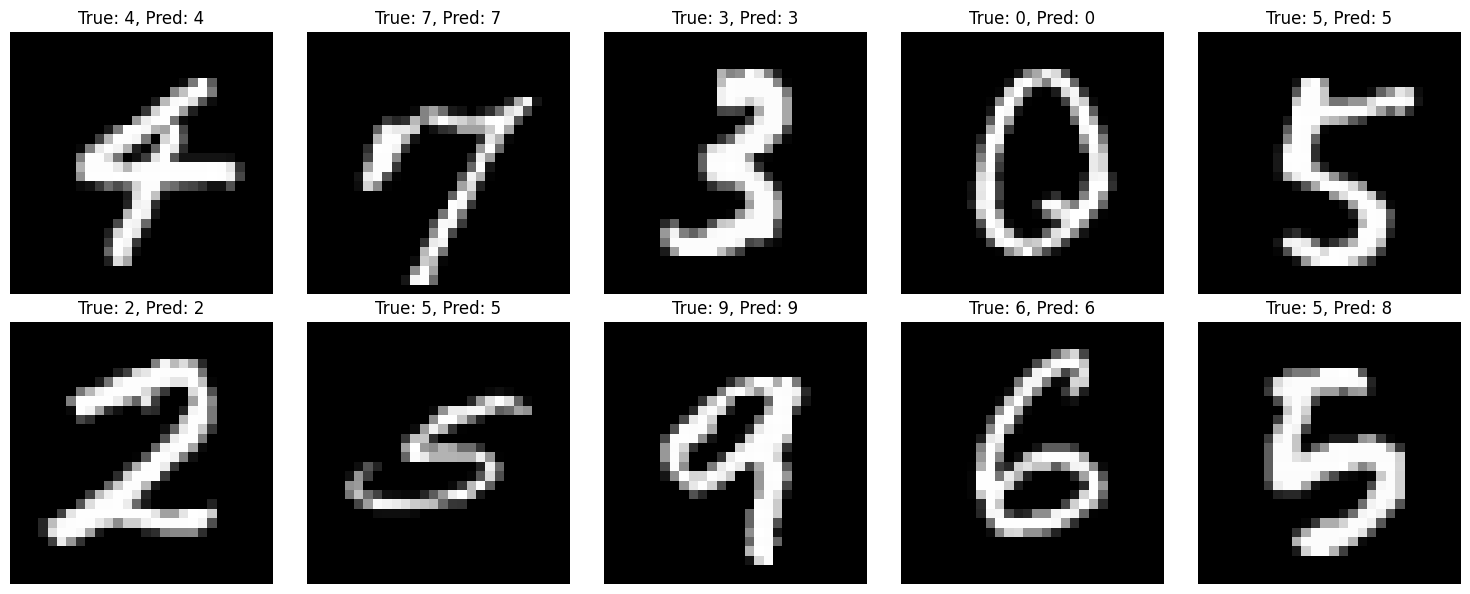


Training model with architecture: Medium depth
Layers: [64, 32, 10]
Activations: ['relu', 'relu', 'softmax']
Epoch 1/20 [5.0%] - train_loss: 2.0968 - val_loss: 1.8448
Epoch 2/20 [10.0%] - train_loss: 1.6291 - val_loss: 1.4279
Epoch 3/20 [15.0%] - train_loss: 1.2717 - val_loss: 1.1299
Epoch 4/20 [20.0%] - train_loss: 1.0333 - val_loss: 0.9425
Epoch 5/20 [25.0%] - train_loss: 0.8835 - val_loss: 0.8221
Epoch 6/20 [30.0%] - train_loss: 0.7836 - val_loss: 0.7385
Epoch 7/20 [35.0%] - train_loss: 0.7121 - val_loss: 0.6770
Epoch 8/20 [40.0%] - train_loss: 0.6577 - val_loss: 0.6293
Epoch 9/20 [45.0%] - train_loss: 0.6145 - val_loss: 0.5906
Epoch 10/20 [50.0%] - train_loss: 0.5791 - val_loss: 0.5586
Epoch 11/20 [55.0%] - train_loss: 0.5494 - val_loss: 0.5315
Epoch 12/20 [60.0%] - train_loss: 0.5241 - val_loss: 0.5086
Epoch 13/20 [65.0%] - train_loss: 0.5021 - val_loss: 0.4888
Epoch 14/20 [70.0%] - train_loss: 0.4829 - val_loss: 0.4714
Epoch 15/20 [75.0%] - train_loss: 0.4661 - val_loss: 0.4556


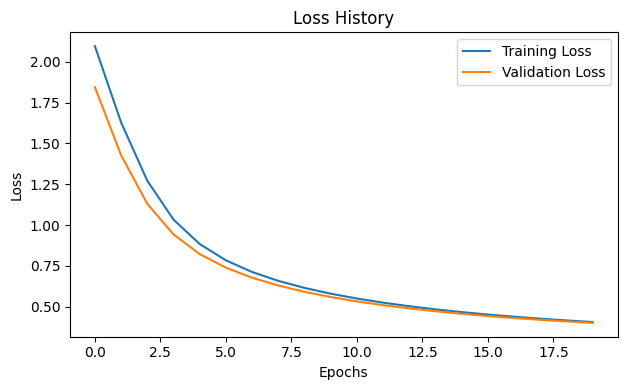


Evaluating model with Medium depth [64, 32, 10] activation...
Accuracy: 0.8910
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.95      1343
           1       0.92      0.97      0.95      1600
           2       0.90      0.85      0.88      1380
           3       0.86      0.86      0.86      1433
           4       0.88      0.91      0.89      1295
           5       0.85      0.82      0.84      1273
           6       0.90      0.94      0.92      1396
           7       0.92      0.91      0.91      1503
           8       0.85      0.81      0.83      1357
           9       0.88      0.87      0.87      1420

    accuracy                           0.89     14000
   macro avg       0.89      0.89      0.89     14000
weighted avg       0.89      0.89      0.89     14000



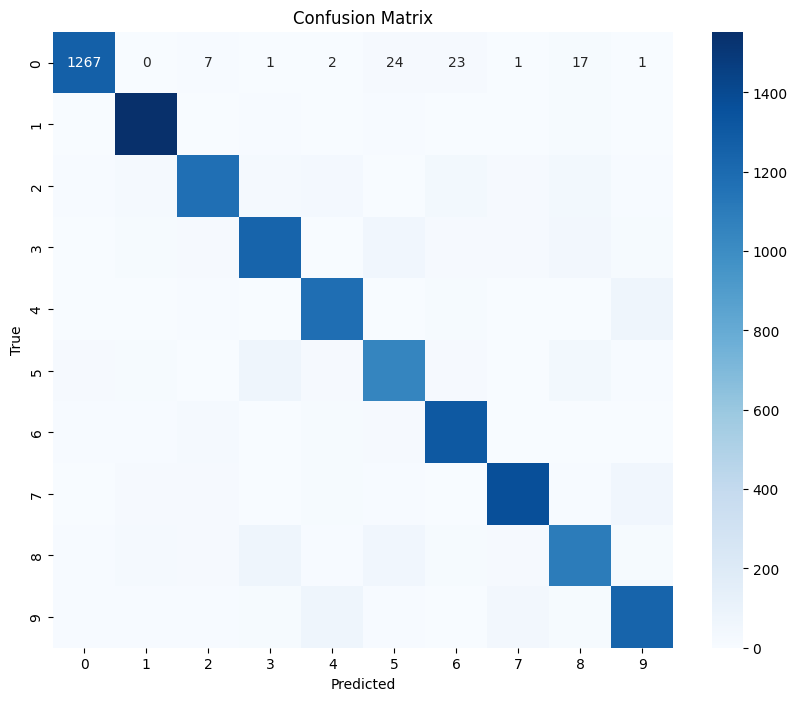

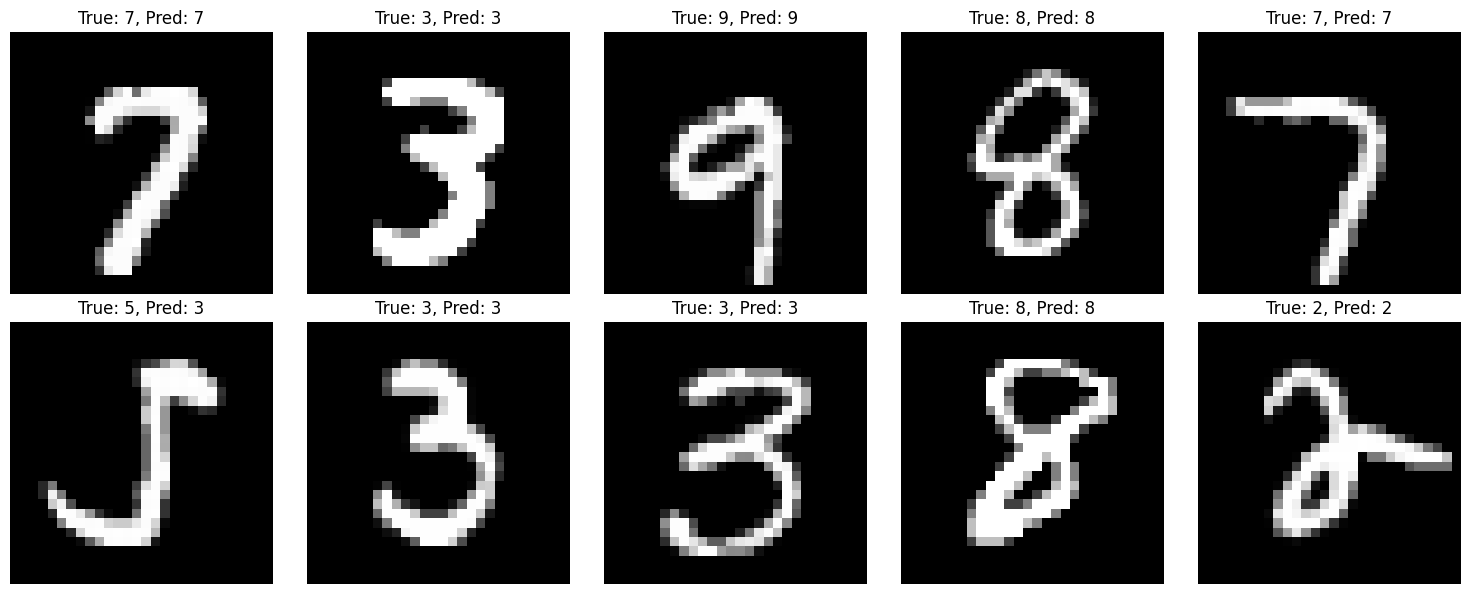


Training model with architecture: Deep network
Layers: [128, 64, 32, 10]
Activations: ['relu', 'relu', 'relu', 'softmax']
Epoch 1/20 [5.0%] - train_loss: 2.1465 - val_loss: 1.9462
Epoch 2/20 [10.0%] - train_loss: 1.7202 - val_loss: 1.4943
Epoch 3/20 [15.0%] - train_loss: 1.3058 - val_loss: 1.1358
Epoch 4/20 [20.0%] - train_loss: 1.0134 - val_loss: 0.9048
Epoch 5/20 [25.0%] - train_loss: 0.8279 - val_loss: 0.7559
Epoch 6/20 [30.0%] - train_loss: 0.7044 - val_loss: 0.6539
Epoch 7/20 [35.0%] - train_loss: 0.6185 - val_loss: 0.5828
Epoch 8/20 [40.0%] - train_loss: 0.5574 - val_loss: 0.5316
Epoch 9/20 [45.0%] - train_loss: 0.5123 - val_loss: 0.4928
Epoch 10/20 [50.0%] - train_loss: 0.4778 - val_loss: 0.4631
Epoch 11/20 [55.0%] - train_loss: 0.4507 - val_loss: 0.4396
Epoch 12/20 [60.0%] - train_loss: 0.4288 - val_loss: 0.4205
Epoch 13/20 [65.0%] - train_loss: 0.4107 - val_loss: 0.4048
Epoch 14/20 [70.0%] - train_loss: 0.3956 - val_loss: 0.3916
Epoch 15/20 [75.0%] - train_loss: 0.3827 - val_

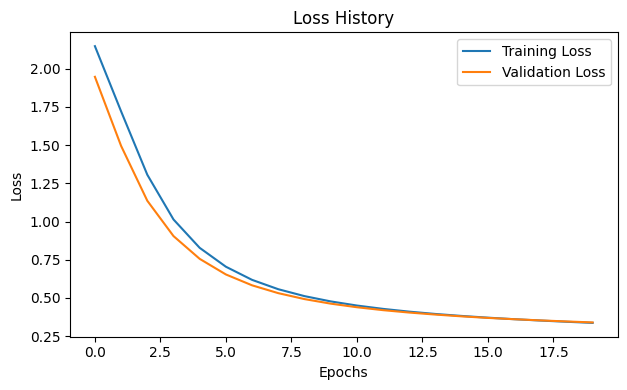


Evaluating model with Deep network [128, 64, 32, 10] activation...
Accuracy: 0.9040
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      1343
           1       0.94      0.97      0.95      1600
           2       0.92      0.87      0.90      1380
           3       0.88      0.87      0.87      1433
           4       0.88      0.91      0.90      1295
           5       0.86      0.86      0.86      1273
           6       0.92      0.94      0.93      1396
           7       0.92      0.92      0.92      1503
           8       0.86      0.84      0.85      1357
           9       0.89      0.88      0.88      1420

    accuracy                           0.90     14000
   macro avg       0.90      0.90      0.90     14000
weighted avg       0.90      0.90      0.90     14000



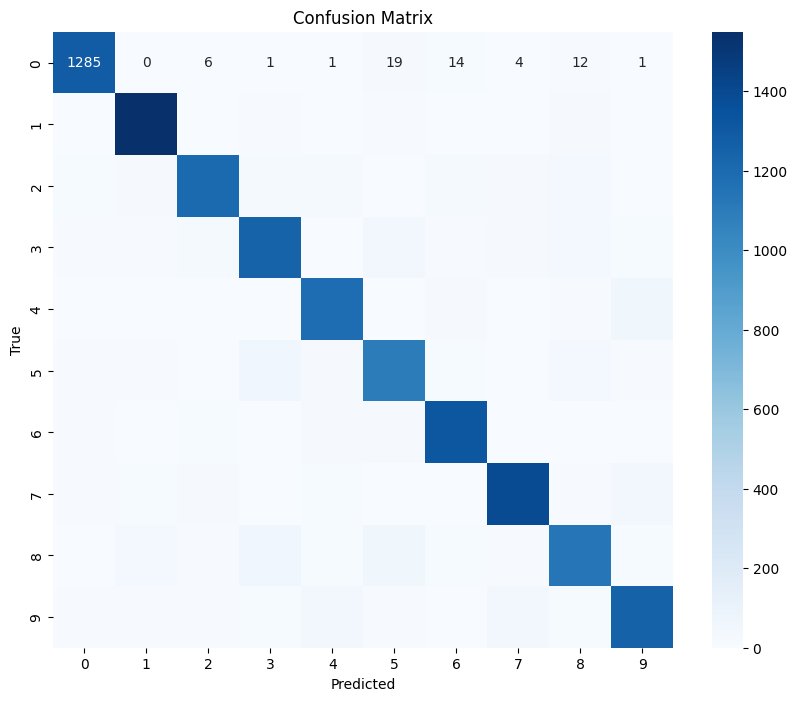

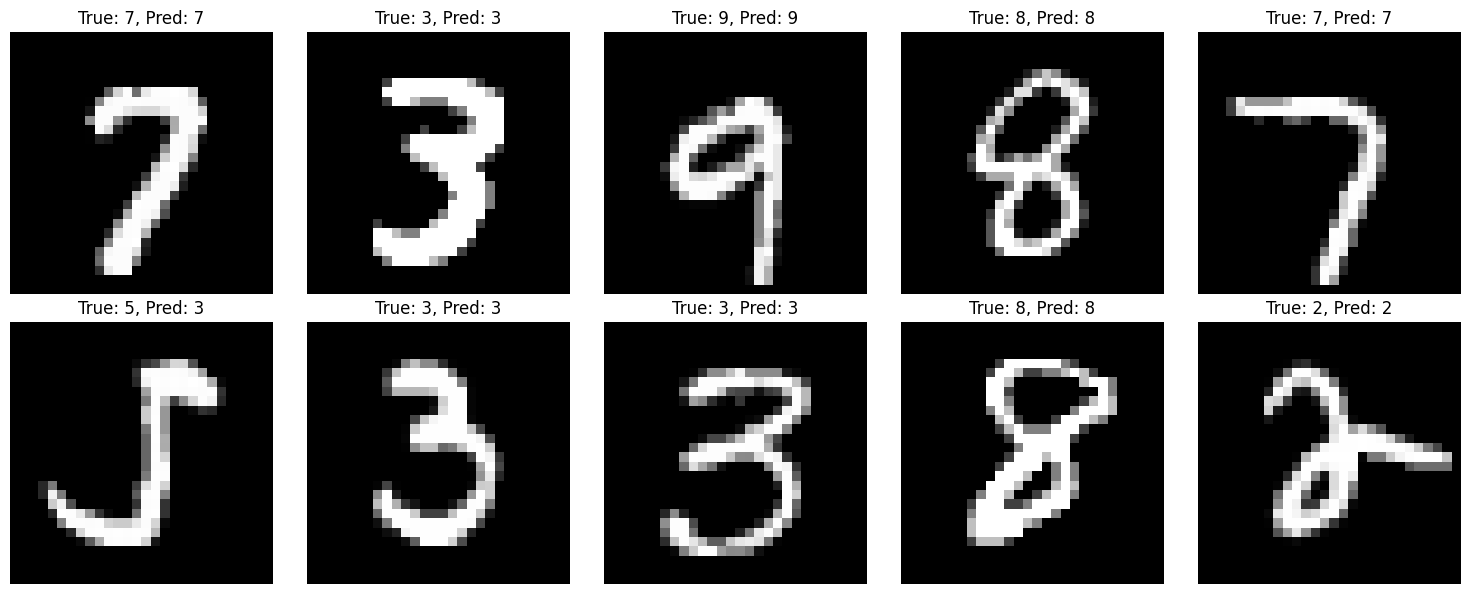


Activation Function Comparison Results:
                             name  accuracy  final_train_loss  final_val_loss  \
0            Small width [32, 10]  0.876357          0.472732        0.467809   
1           Medium width [64, 10]  0.882500          0.457522        0.448745   
2           Large width [128, 10]  0.883143          0.449202        0.445311   
3          Shallow depth [64, 10]  0.882500          0.457522        0.448745   
4       Medium depth [64, 32, 10]  0.891000          0.405075        0.399948   
5  Deep network [128, 64, 32, 10]  0.904000          0.337241        0.340229   

   training_time  
0      21.401325  
1      26.830311  
2      36.451889  
3      27.856342  
4      30.338903  
5      48.764144  

Activation Function Comparison Results:
                             name  accuracy  final_train_loss  final_val_loss  \
0            Small width [32, 10]  0.876357          0.472732        0.467809   
1           Medium width [64, 10]  0.882500          0.

In [10]:
width_results = []
depth_results = []

for i, arch in enumerate(architectures):
    print(f"\nTraining model with architecture: {arch['name']}")
    print(f"Layers: {arch['layers']}")
    print(f"Activations: {arch['activations']}")
    
    # Initialize the model
    model = FFNN_model.FeedforwardNeuralNetwork(
        input_size=X_train.shape[1],
        layer_sizes=arch['layers'],
        activations=arch['activations'],
        loss='categorical_cross_entropy',
        weight_init='he',
        weight_init_params={'seed': 42}
    )
    
    # Train the model
    start_time = time.time()
    history = model.train(
        X_train=X_train,
        y_train=y_train_onehot,
        X_val=X_test,
        y_val=y_test_onehot,
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        learning_rate=params['learning_rate'],
        verbose=1
    )
    training_time = time.time() - start_time
    
    # Plot training history
    plot_history(history)

    # Evaluate model
    print(f"\nEvaluating model with {arch['name']} {arch['layers']} activation...")
    accuracy, _ = evaluate_model(model, X_test, y_test_onehot, y_test)

     # Store results
    width_results.append({
        'name': f"{arch['name']} {arch['layers']}",
        'accuracy': accuracy,
        'training_time': training_time,
        'final_train_loss': history['train_loss'][-1],
        'final_val_loss': history['val_loss'][-1] if 'val_loss' in history else None
    })
    depth_results.append({
        'name': f"{arch['name']} {arch['layers']}",
        'accuracy': accuracy,
        'training_time': training_time,
        'final_train_loss': history['train_loss'][-1],
        'final_val_loss': history['val_loss'][-1] if 'val_loss' in history else None
    })
    

print("\nActivation Function Comparison Results:")
widht_df = pd.DataFrame(width_results)
print(widht_df[['name', 'accuracy', 'final_train_loss', 'final_val_loss', 'training_time']])

print("\nActivation Function Comparison Results:")
depth_df = pd.DataFrame(width_results)
print(depth_df[['name', 'accuracy', 'final_train_loss', 'final_val_loss', 'training_time']])
    

## Experiment 2 : Effect of Activation Function

In [11]:
activation_functions = ['linear', 'relu', 'sigmoid', 'tanh']

base_architecture = {
    'layers': [64, 32, 10],
    'loss': 'categorical_cross_entropy'
}

params = {
    'epochs': 20,
    'batch_size': 32,
    'learning_rate': 0.01
}


Training model with activation: linear
Epoch 1/20 [5.0%] - train_loss: 1.6579 - val_loss: 1.1611
Epoch 2/20 [10.0%] - train_loss: 0.9717 - val_loss: 0.8304
Epoch 3/20 [15.0%] - train_loss: 0.7547 - val_loss: 0.6876
Epoch 4/20 [20.0%] - train_loss: 0.6473 - val_loss: 0.6074
Epoch 5/20 [25.0%] - train_loss: 0.5824 - val_loss: 0.5556
Epoch 6/20 [30.0%] - train_loss: 0.5384 - val_loss: 0.5192
Epoch 7/20 [35.0%] - train_loss: 0.5064 - val_loss: 0.4920
Epoch 8/20 [40.0%] - train_loss: 0.4819 - val_loss: 0.4709
Epoch 9/20 [45.0%] - train_loss: 0.4625 - val_loss: 0.4536
Epoch 10/20 [50.0%] - train_loss: 0.4466 - val_loss: 0.4396
Epoch 11/20 [55.0%] - train_loss: 0.4334 - val_loss: 0.4278
Epoch 12/20 [60.0%] - train_loss: 0.4222 - val_loss: 0.4178
Epoch 13/20 [65.0%] - train_loss: 0.4126 - val_loss: 0.4093
Epoch 14/20 [70.0%] - train_loss: 0.4042 - val_loss: 0.4017
Epoch 15/20 [75.0%] - train_loss: 0.3968 - val_loss: 0.3949
Epoch 16/20 [80.0%] - train_loss: 0.3902 - val_loss: 0.3890
Epoch 17/2

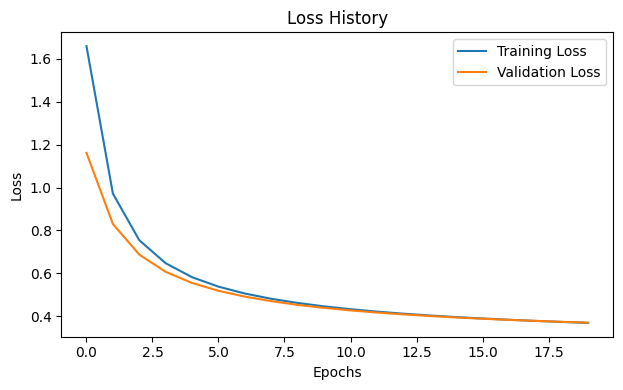


Evaluating model with linear activation...
Accuracy: 0.8948
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1343
           1       0.93      0.96      0.94      1600
           2       0.89      0.86      0.87      1380
           3       0.87      0.88      0.87      1433
           4       0.89      0.92      0.90      1295
           5       0.86      0.83      0.84      1273
           6       0.92      0.93      0.93      1396
           7       0.91      0.91      0.91      1503
           8       0.85      0.82      0.84      1357
           9       0.87      0.88      0.87      1420

    accuracy                           0.89     14000
   macro avg       0.89      0.89      0.89     14000
weighted avg       0.89      0.89      0.89     14000



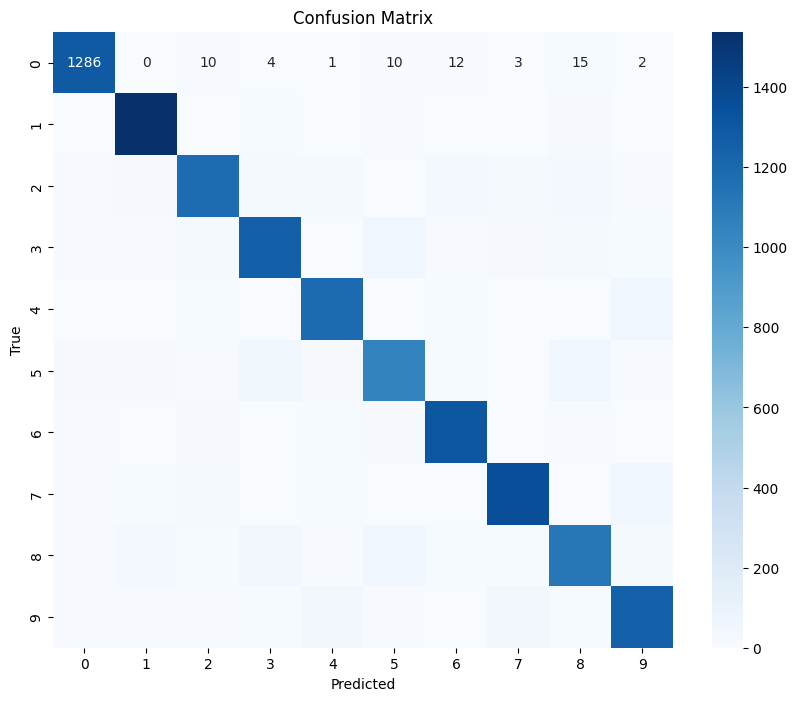

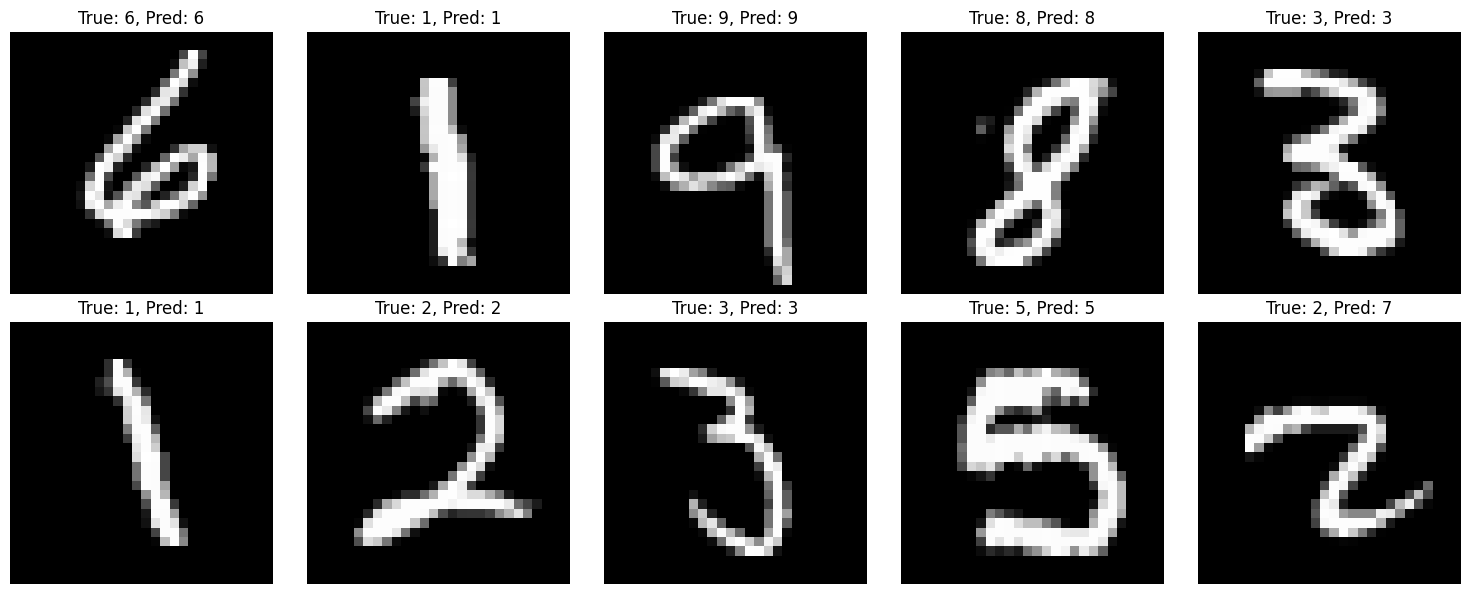


Weight distributions:


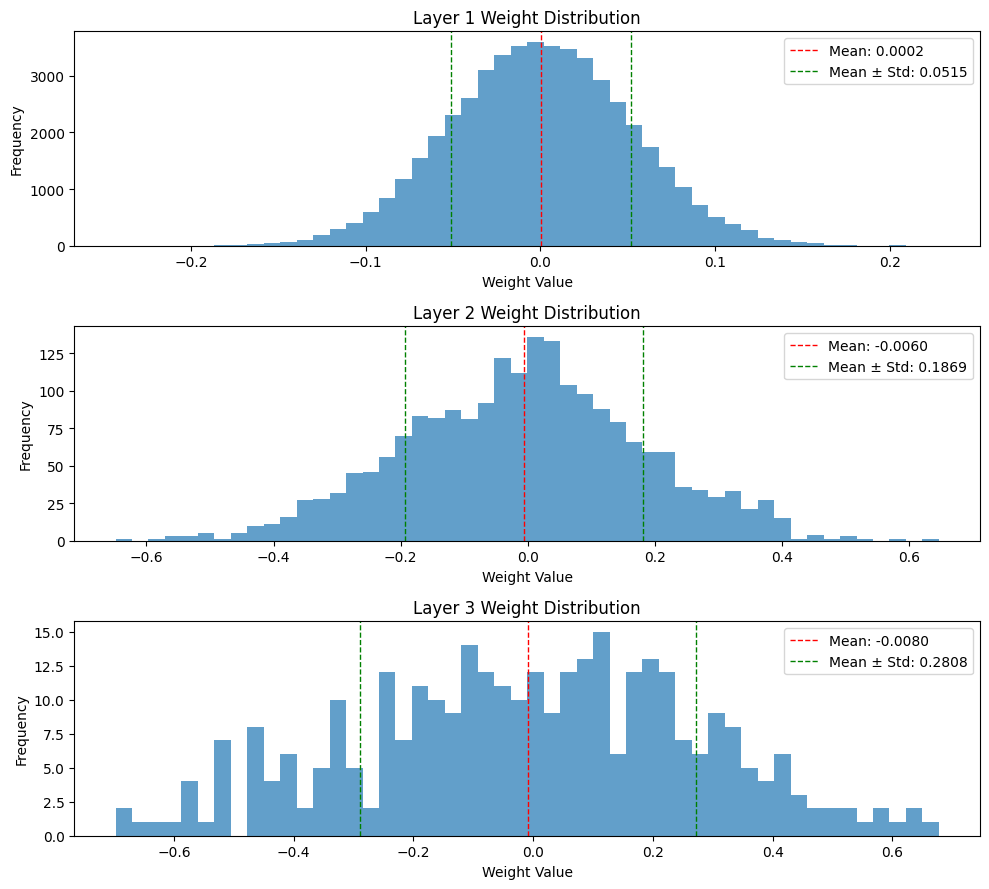


Gradient distributions:


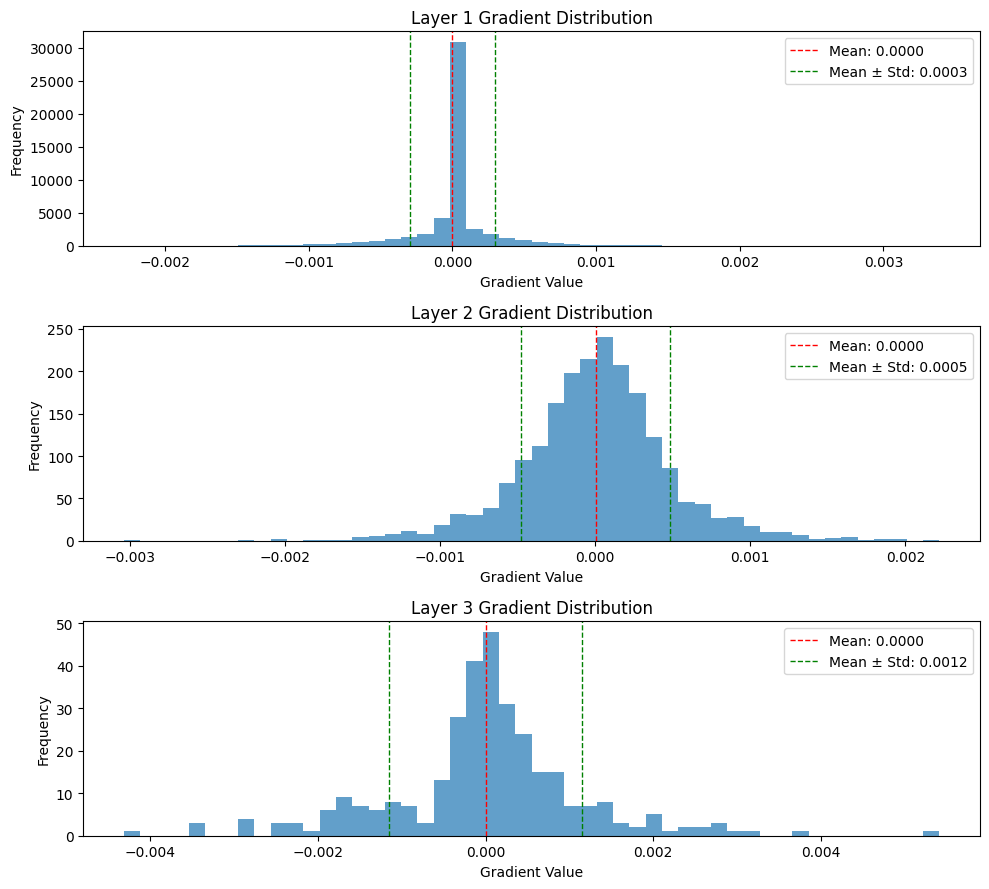


Training model with activation: relu
Epoch 1/20 [5.0%] - train_loss: 2.1180 - val_loss: 1.9161
Epoch 2/20 [10.0%] - train_loss: 1.7458 - val_loss: 1.5832
Epoch 3/20 [15.0%] - train_loss: 1.4312 - val_loss: 1.2799
Epoch 4/20 [20.0%] - train_loss: 1.1564 - val_loss: 1.0378
Epoch 5/20 [25.0%] - train_loss: 0.9552 - val_loss: 0.8712
Epoch 6/20 [30.0%] - train_loss: 0.8179 - val_loss: 0.7580
Epoch 7/20 [35.0%] - train_loss: 0.7225 - val_loss: 0.6783
Epoch 8/20 [40.0%] - train_loss: 0.6538 - val_loss: 0.6197
Epoch 9/20 [45.0%] - train_loss: 0.6024 - val_loss: 0.5753
Epoch 10/20 [50.0%] - train_loss: 0.5626 - val_loss: 0.5404
Epoch 11/20 [55.0%] - train_loss: 0.5310 - val_loss: 0.5124
Epoch 12/20 [60.0%] - train_loss: 0.5051 - val_loss: 0.4893
Epoch 13/20 [65.0%] - train_loss: 0.4836 - val_loss: 0.4696
Epoch 14/20 [70.0%] - train_loss: 0.4652 - val_loss: 0.4530
Epoch 15/20 [75.0%] - train_loss: 0.4494 - val_loss: 0.4386
Epoch 16/20 [80.0%] - train_loss: 0.4357 - val_loss: 0.4259
Epoch 17/20 

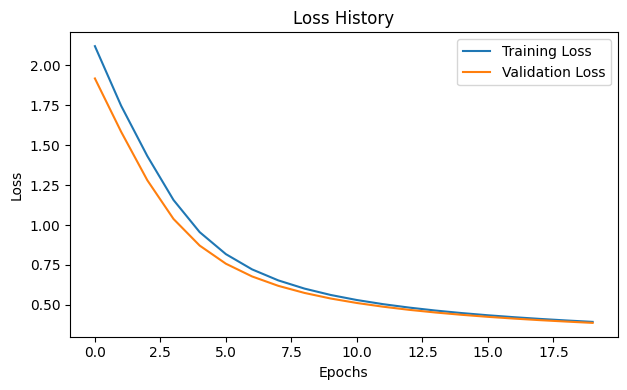


Evaluating model with relu activation...
Accuracy: 0.8918
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1343
           1       0.92      0.97      0.95      1600
           2       0.89      0.85      0.87      1380
           3       0.86      0.86      0.86      1433
           4       0.89      0.90      0.89      1295
           5       0.86      0.80      0.83      1273
           6       0.89      0.93      0.91      1396
           7       0.91      0.92      0.91      1503
           8       0.86      0.82      0.84      1357
           9       0.87      0.87      0.87      1420

    accuracy                           0.89     14000
   macro avg       0.89      0.89      0.89     14000
weighted avg       0.89      0.89      0.89     14000



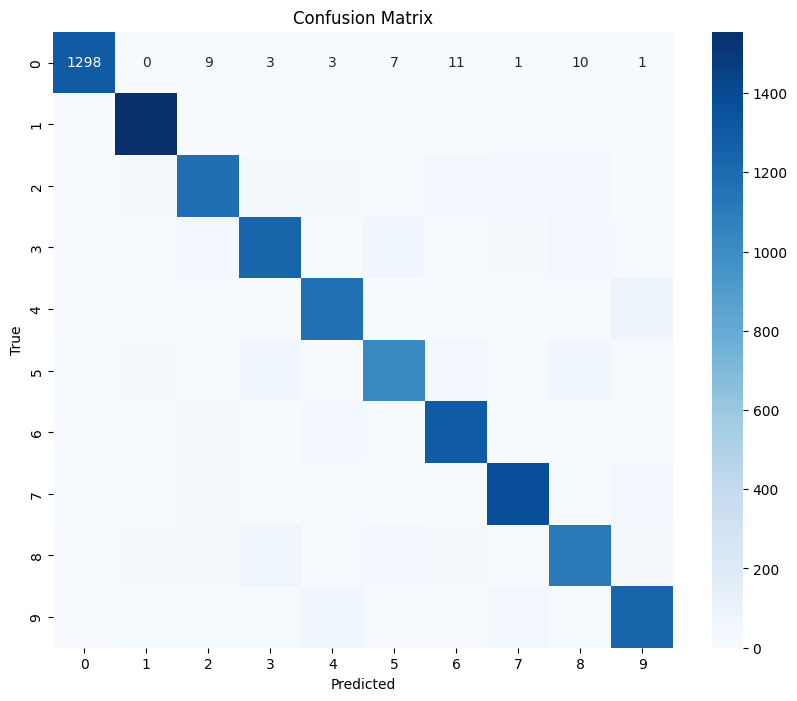

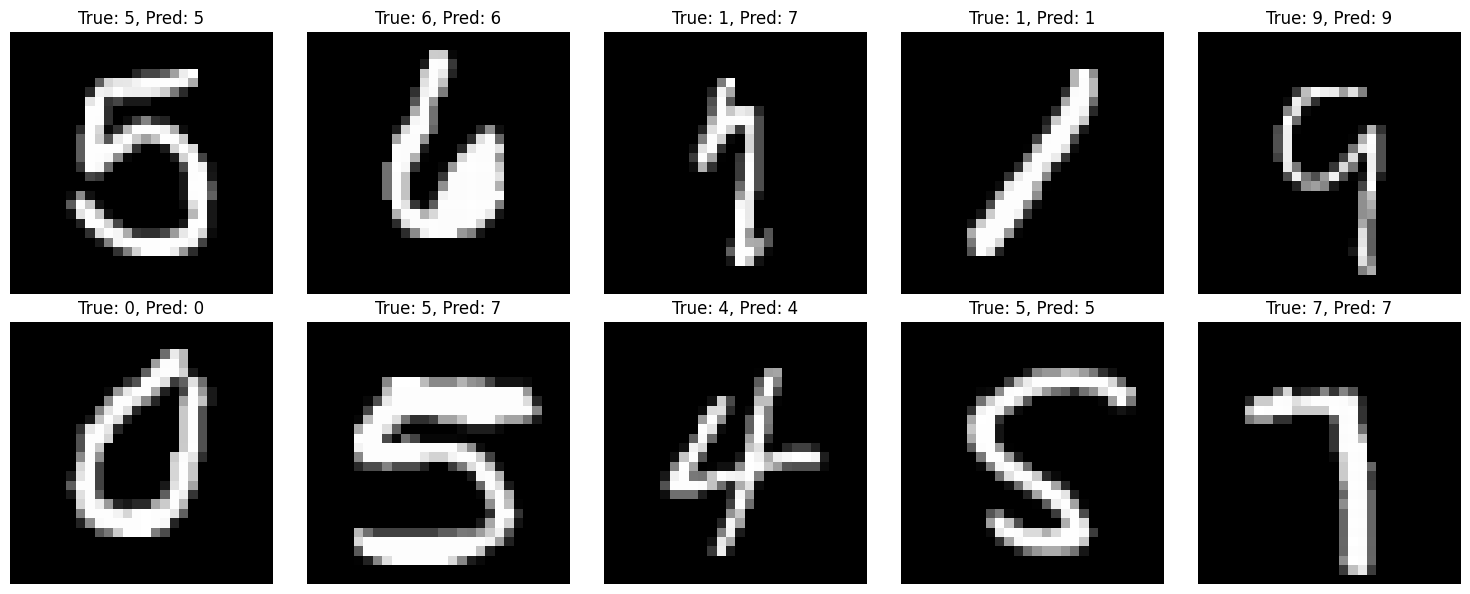


Weight distributions:


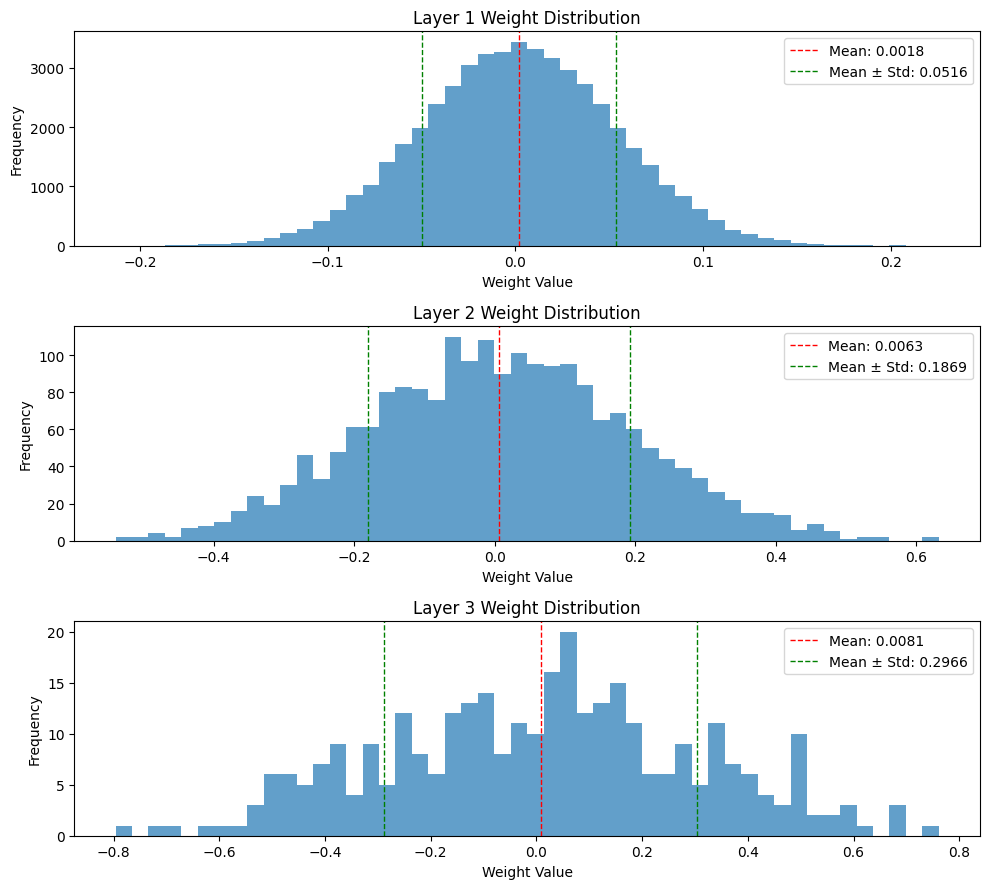


Gradient distributions:


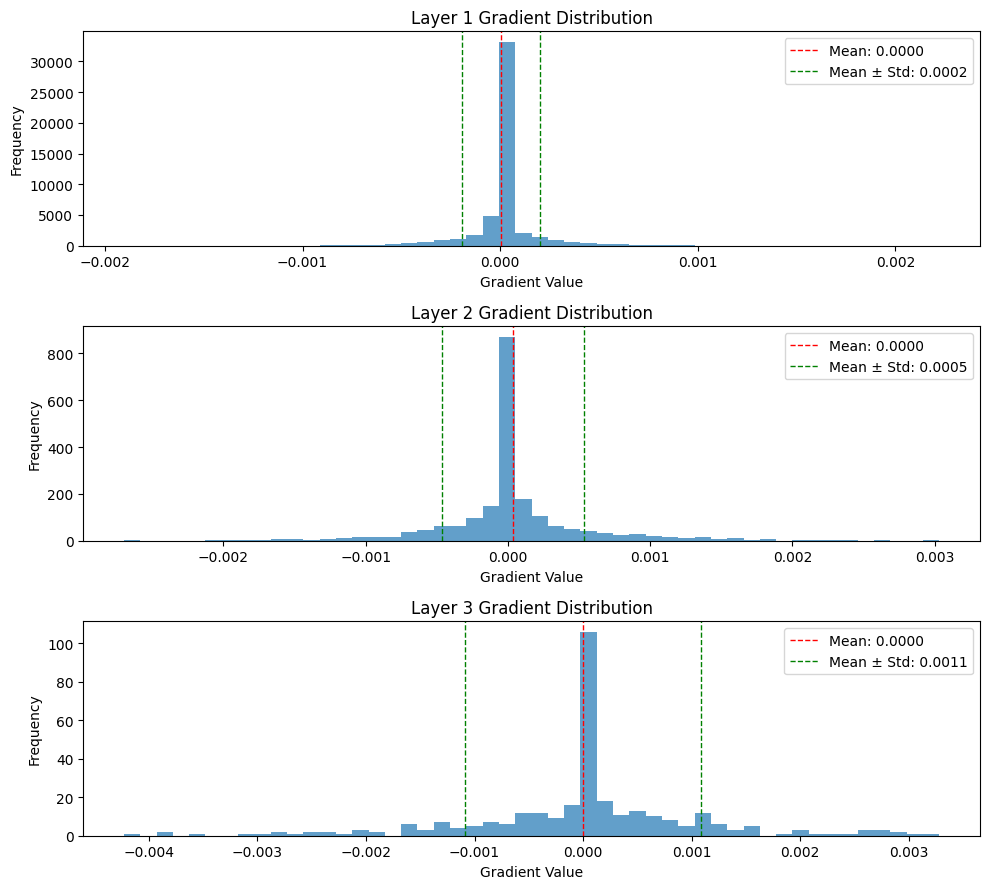


Training model with activation: sigmoid
Epoch 1/20 [5.0%] - train_loss: 2.4622 - val_loss: 2.3736
Epoch 2/20 [10.0%] - train_loss: 2.3401 - val_loss: 2.3151
Epoch 3/20 [15.0%] - train_loss: 2.3033 - val_loss: 2.2931
Epoch 4/20 [20.0%] - train_loss: 2.2872 - val_loss: 2.2815
Epoch 5/20 [25.0%] - train_loss: 2.2775 - val_loss: 2.2733
Epoch 6/20 [30.0%] - train_loss: 2.2699 - val_loss: 2.2661
Epoch 7/20 [35.0%] - train_loss: 2.2630 - val_loss: 2.2593
Epoch 8/20 [40.0%] - train_loss: 2.2563 - val_loss: 2.2526
Epoch 9/20 [45.0%] - train_loss: 2.2495 - val_loss: 2.2457
Epoch 10/20 [50.0%] - train_loss: 2.2425 - val_loss: 2.2387
Epoch 11/20 [55.0%] - train_loss: 2.2355 - val_loss: 2.2315
Epoch 12/20 [60.0%] - train_loss: 2.2282 - val_loss: 2.2242
Epoch 13/20 [65.0%] - train_loss: 2.2208 - val_loss: 2.2166
Epoch 14/20 [70.0%] - train_loss: 2.2132 - val_loss: 2.2088
Epoch 15/20 [75.0%] - train_loss: 2.2053 - val_loss: 2.2008
Epoch 16/20 [80.0%] - train_loss: 2.1971 - val_loss: 2.1925
Epoch 17/

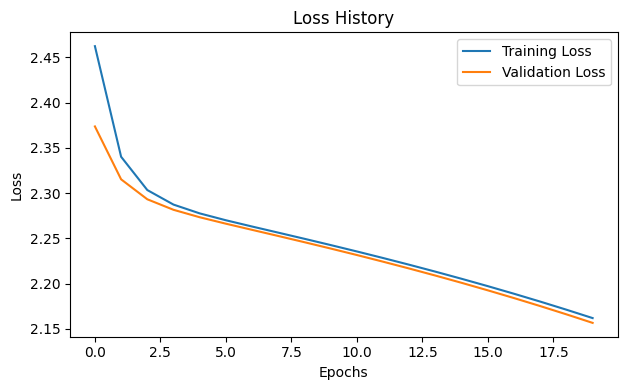


Evaluating model with sigmoid activation...
Accuracy: 0.5521
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.78      0.83      1343
           1       0.35      0.99      0.52      1600
           2       0.79      0.44      0.57      1380
           3       0.56      0.64      0.60      1433
           4       0.77      0.46      0.58      1295
           5       1.00      0.00      0.00      1273
           6       0.82      0.75      0.78      1396
           7       0.44      0.92      0.59      1503
           8       0.80      0.35      0.49      1357
           9       0.55      0.05      0.10      1420

    accuracy                           0.55     14000
   macro avg       0.70      0.54      0.51     14000
weighted avg       0.69      0.55      0.51     14000



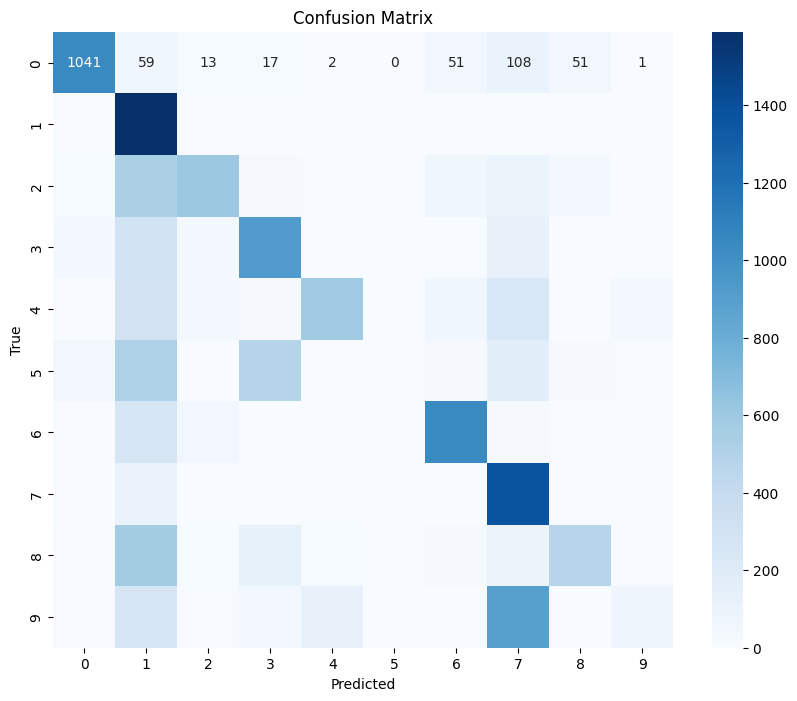

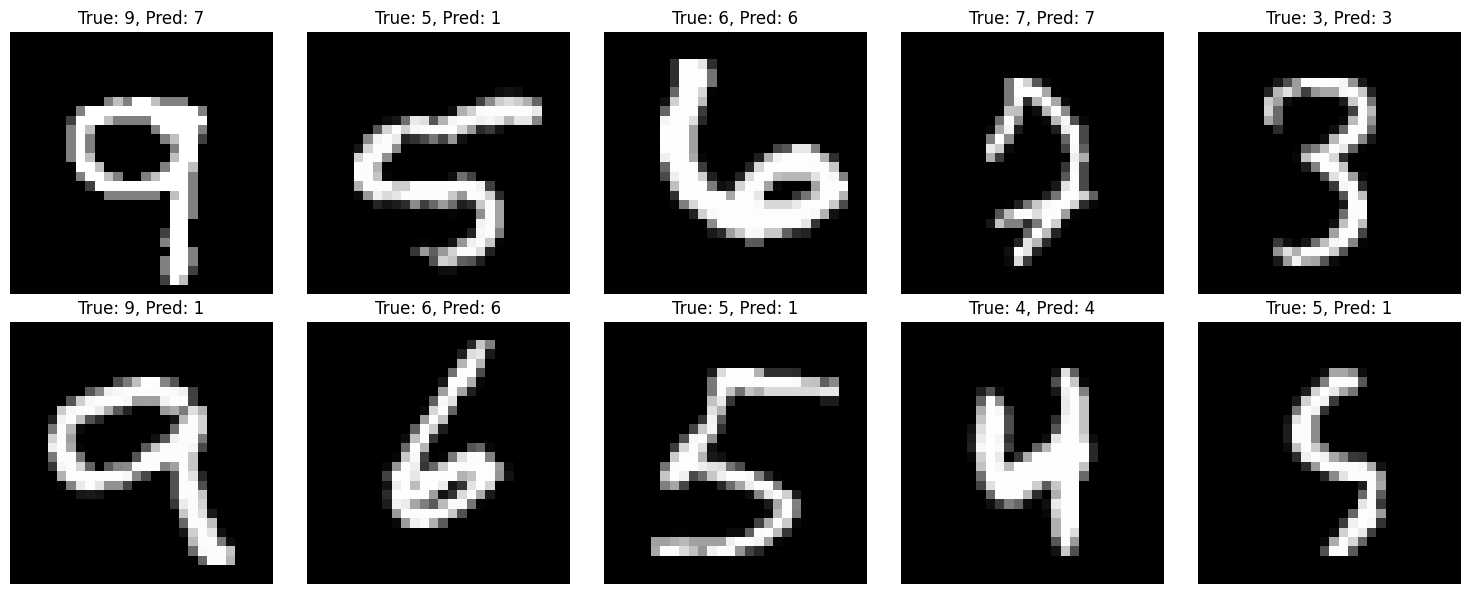


Weight distributions:


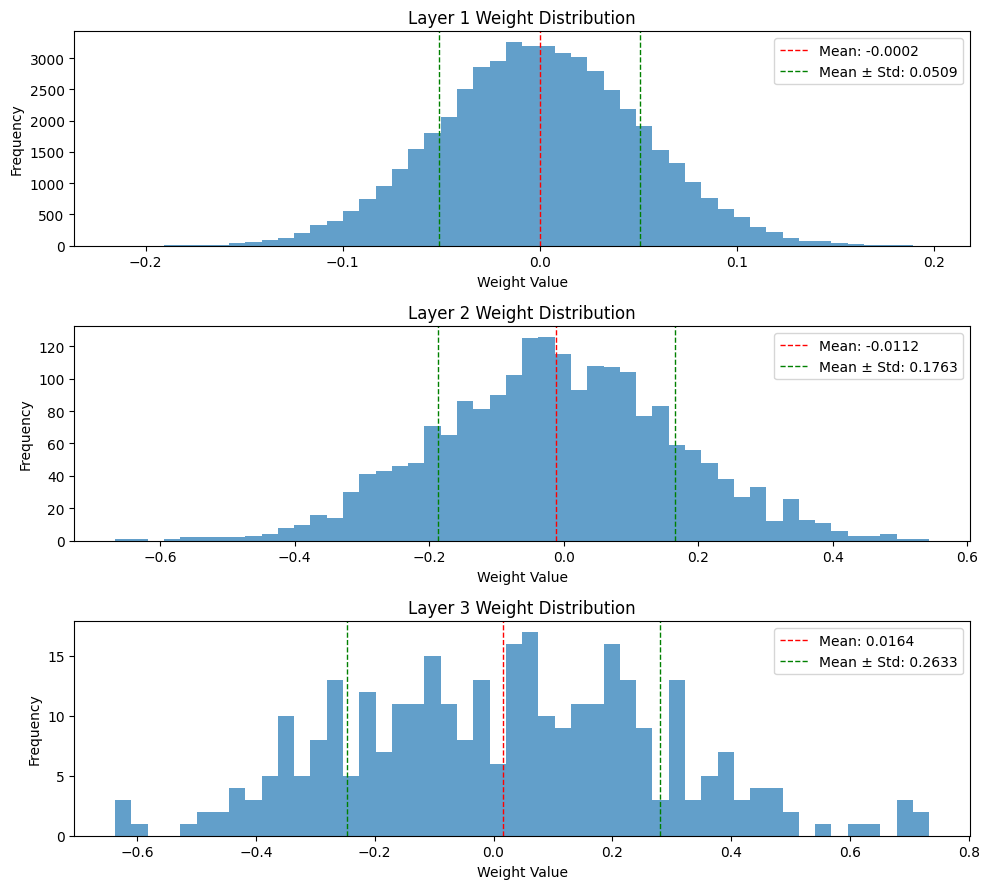


Gradient distributions:


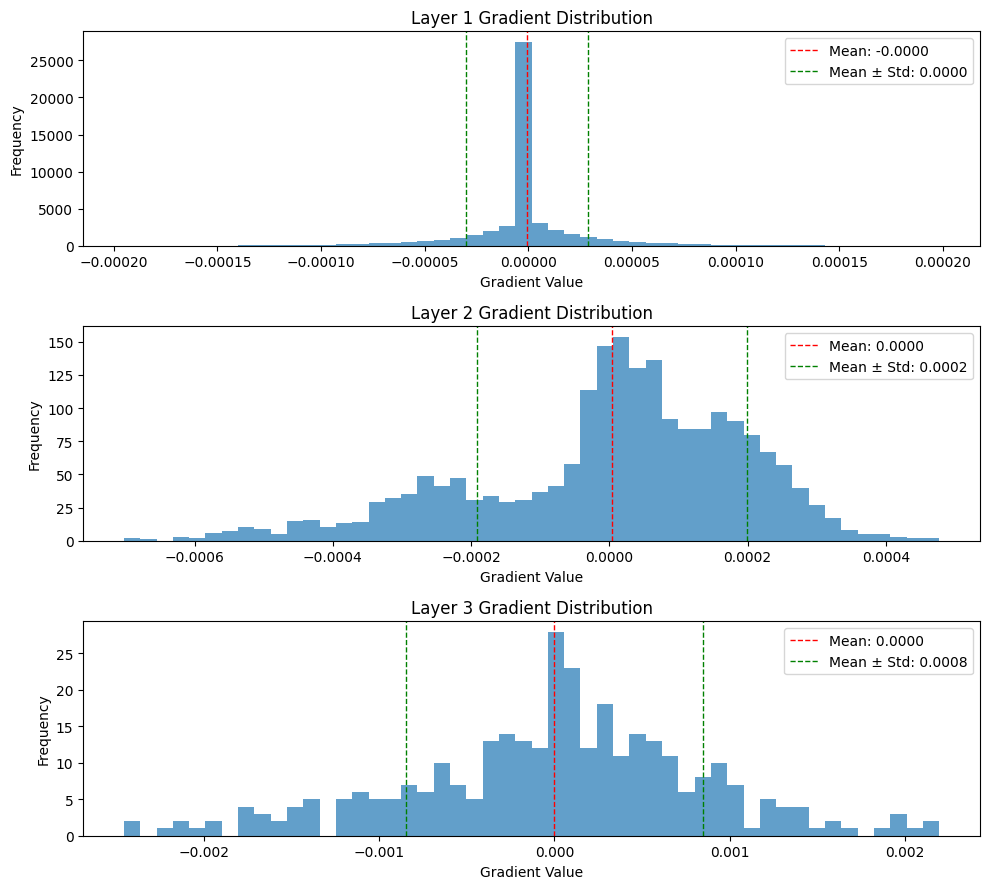


Training model with activation: tanh
Epoch 1/20 [5.0%] - train_loss: 1.9759 - val_loss: 1.6193
Epoch 2/20 [10.0%] - train_loss: 1.4217 - val_loss: 1.2565
Epoch 3/20 [15.0%] - train_loss: 1.1522 - val_loss: 1.0555
Epoch 4/20 [20.0%] - train_loss: 0.9904 - val_loss: 0.9257
Epoch 5/20 [25.0%] - train_loss: 0.8807 - val_loss: 0.8339
Epoch 6/20 [30.0%] - train_loss: 0.8009 - val_loss: 0.7655
Epoch 7/20 [35.0%] - train_loss: 0.7401 - val_loss: 0.7123
Epoch 8/20 [40.0%] - train_loss: 0.6919 - val_loss: 0.6696
Epoch 9/20 [45.0%] - train_loss: 0.6528 - val_loss: 0.6346
Epoch 10/20 [50.0%] - train_loss: 0.6203 - val_loss: 0.6052
Epoch 11/20 [55.0%] - train_loss: 0.5928 - val_loss: 0.5803
Epoch 12/20 [60.0%] - train_loss: 0.5693 - val_loss: 0.5588
Epoch 13/20 [65.0%] - train_loss: 0.5489 - val_loss: 0.5399
Epoch 14/20 [70.0%] - train_loss: 0.5310 - val_loss: 0.5234
Epoch 15/20 [75.0%] - train_loss: 0.5151 - val_loss: 0.5087
Epoch 16/20 [80.0%] - train_loss: 0.5009 - val_loss: 0.4956
Epoch 17/20 

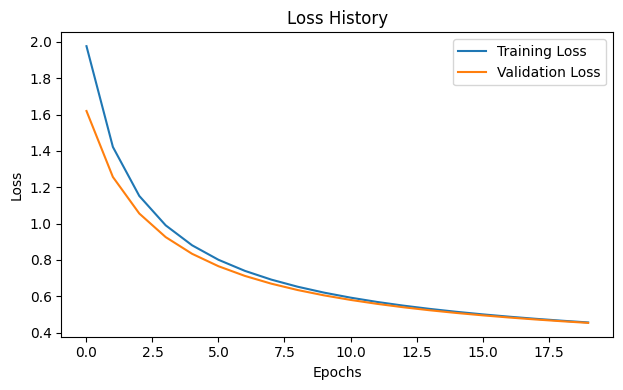


Evaluating model with tanh activation...
Accuracy: 0.8849
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.94      1343
           1       0.91      0.96      0.94      1600
           2       0.88      0.83      0.86      1380
           3       0.85      0.87      0.86      1433
           4       0.88      0.89      0.89      1295
           5       0.85      0.81      0.83      1273
           6       0.91      0.93      0.92      1396
           7       0.90      0.91      0.91      1503
           8       0.85      0.81      0.83      1357
           9       0.86      0.87      0.86      1420

    accuracy                           0.88     14000
   macro avg       0.88      0.88      0.88     14000
weighted avg       0.88      0.88      0.88     14000



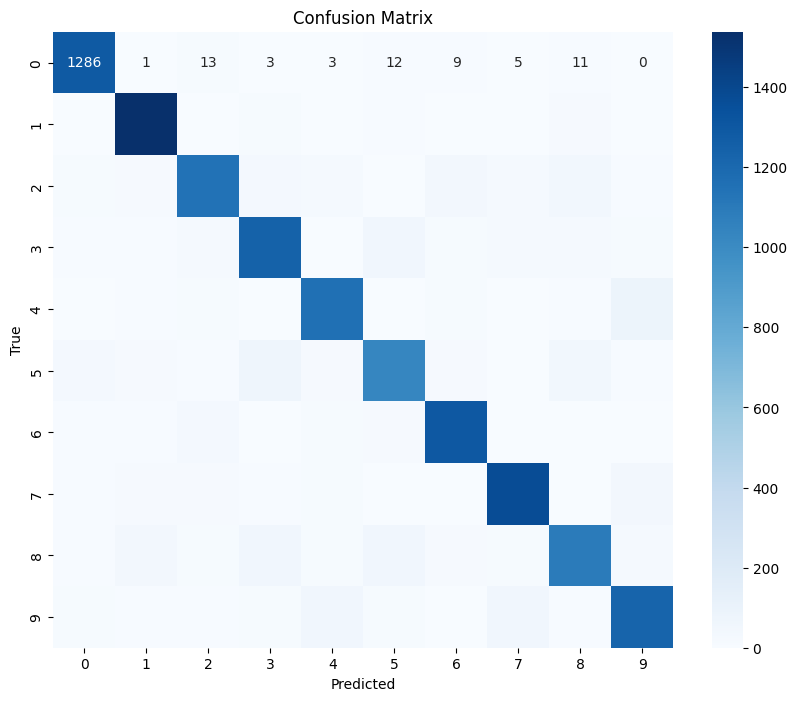

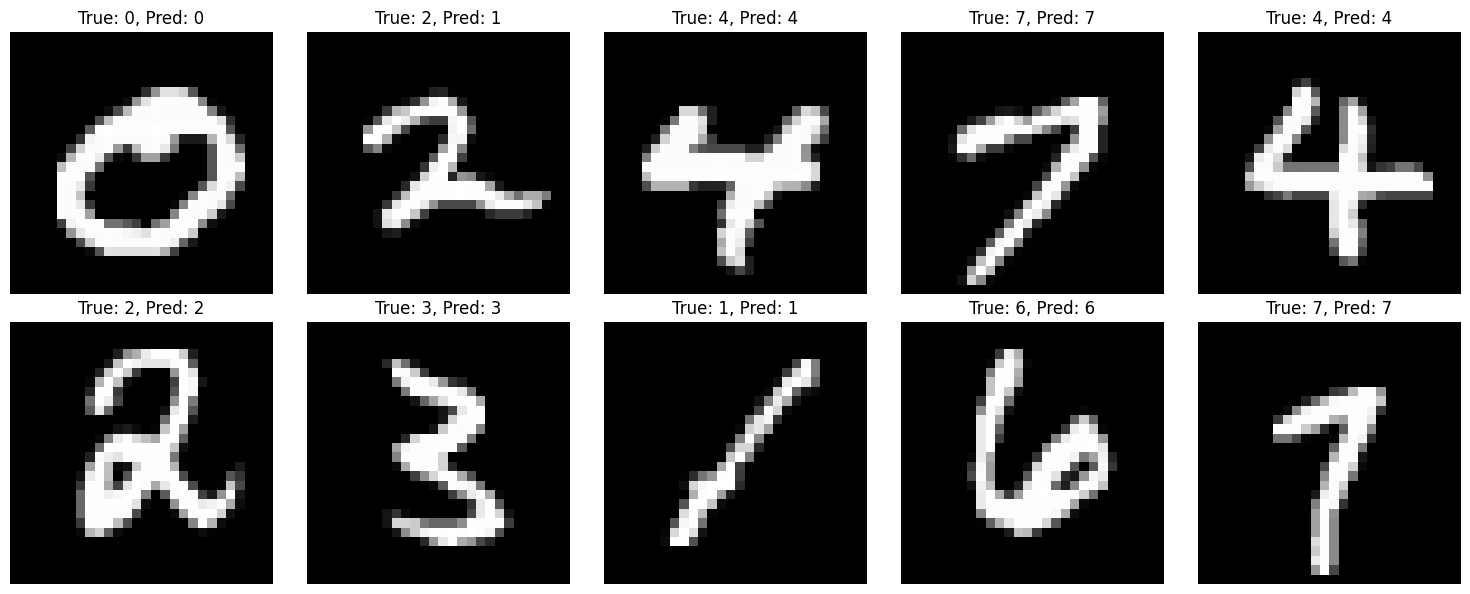


Weight distributions:


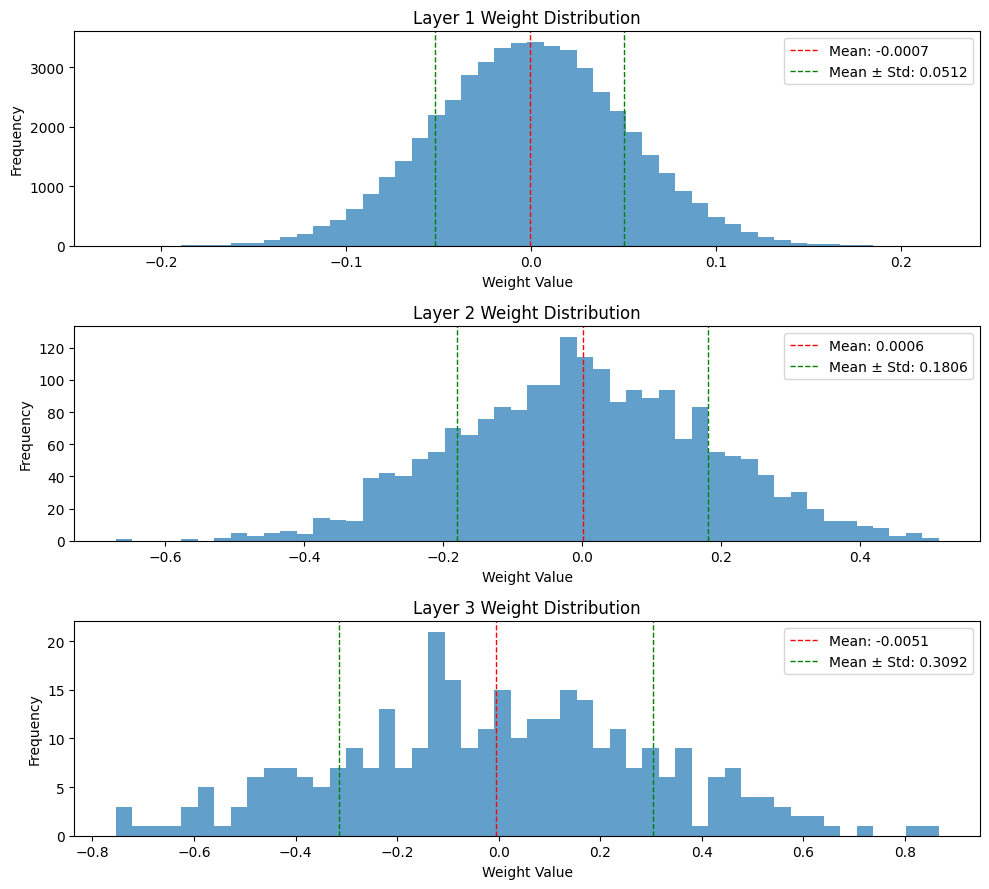


Gradient distributions:


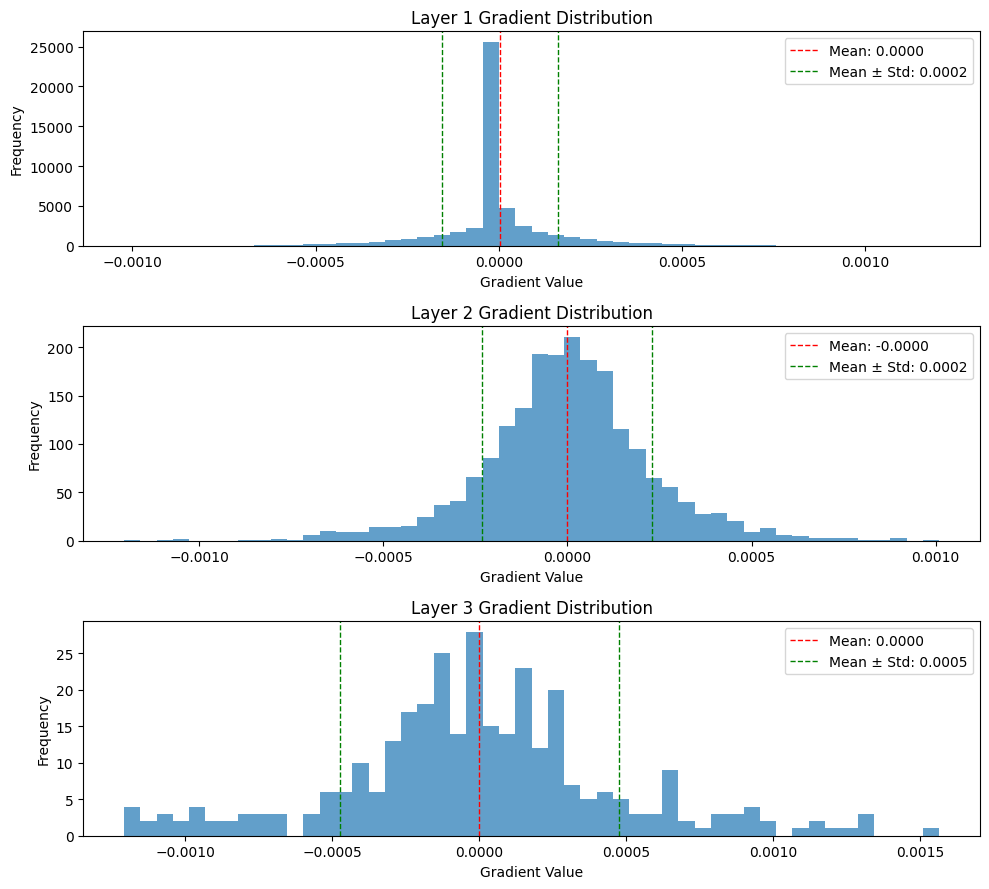


Activation Function Comparison Results:
  activation  accuracy  final_train_loss  final_val_loss  training_time
0     linear  0.894786          0.369739        0.370755      30.713777
1       relu  0.891786          0.394382        0.388035      30.235011
2    sigmoid  0.552143          2.161883        2.156583      32.659835
3       tanh  0.884929          0.456399        0.453952      35.362973


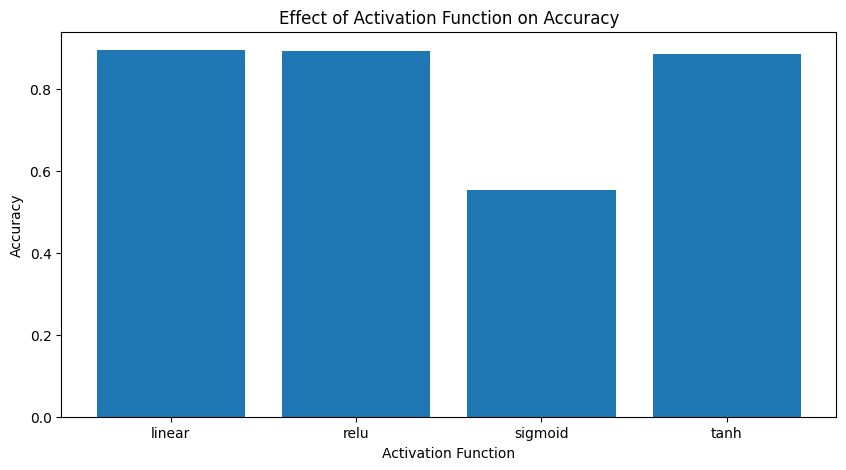

In [12]:
activation_results = []

for activation in activation_functions:
    print(f"\nTraining model with activation: {activation}")
    
    # Create activations list (softmax for output layer)
    activations = [activation] * (len(base_architecture['layers']) - 1) + ['softmax']
    
    # Initialize model
    model = FFNN_model.FeedforwardNeuralNetwork(
        input_size=X_train.shape[1],
        layer_sizes=base_architecture['layers'],
        activations=activations,
        loss=base_architecture['loss']
    )
    
    # Train the model
    start_time = time.time()
    history = model.train(
        X_train=X_train,
        y_train=y_train_onehot,
        X_val=X_test,
        y_val=y_test_onehot,
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        learning_rate=params['learning_rate'],
        verbose=1
    )
    training_time = time.time() - start_time
    
    # Plot training history
    plot_history(history)
    
    # Evaluate model
    print(f"\nEvaluating model with {activation} activation...")
    accuracy, _ = evaluate_model(model, X_test, y_test_onehot, y_test)
    
    # Plot weight and gradient distributions
    print("\nWeight distributions:")
    model.plot_weight_distribution(list(range(len(base_architecture['layers']))))
    plt.show()
    
    print("\nGradient distributions:")
    model.plot_gradient_distribution(list(range(len(base_architecture['layers']))))
    plt.show()
    
    # Store results
    activation_results.append({
        'activation': activation,
        'accuracy': accuracy,
        'training_time': training_time,
        'final_train_loss': history['train_loss'][-1],
        'final_val_loss': history['val_loss'][-1] if 'val_loss' in history else None
    })

# Display activation results
print("\nActivation Function Comparison Results:")
activation_df = pd.DataFrame(activation_results)
print(activation_df[['activation', 'accuracy', 'final_train_loss', 'final_val_loss', 'training_time']])

# Plot comparative results
plt.figure(figsize=(10, 5))
plt.bar([r['activation'] for r in activation_results], [r['accuracy'] for r in activation_results])
plt.xlabel('Activation Function')
plt.ylabel('Accuracy')
plt.title('Effect of Activation Function on Accuracy')
plt.show()

## Experiment 3 : Effect of learning rate

In [13]:
learning_rates = [0.001, 0.01, 0.1]

base_architecture = {
    'layers': [64, 32, 10],
    'activations': ['relu', 'relu', 'softmax'],
    'loss': 'categorical_cross_entropy'
}
params = {
    'epochs': 20,
    'batch_size': 32
}


Training model with learning rate: 0.001
Epoch 1/20 [5.0%] - train_loss: 2.3511 - val_loss: 2.3129
Epoch 2/20 [10.0%] - train_loss: 2.2790 - val_loss: 2.2525
Epoch 3/20 [15.0%] - train_loss: 2.2252 - val_loss: 2.2040
Epoch 4/20 [20.0%] - train_loss: 2.1800 - val_loss: 2.1615
Epoch 5/20 [25.0%] - train_loss: 2.1393 - val_loss: 2.1222
Epoch 6/20 [30.0%] - train_loss: 2.1010 - val_loss: 2.0846
Epoch 7/20 [35.0%] - train_loss: 2.0639 - val_loss: 2.0479
Epoch 8/20 [40.0%] - train_loss: 2.0273 - val_loss: 2.0114
Epoch 9/20 [45.0%] - train_loss: 1.9909 - val_loss: 1.9750
Epoch 10/20 [50.0%] - train_loss: 1.9543 - val_loss: 1.9383
Epoch 11/20 [55.0%] - train_loss: 1.9175 - val_loss: 1.9013
Epoch 12/20 [60.0%] - train_loss: 1.8804 - val_loss: 1.8639
Epoch 13/20 [65.0%] - train_loss: 1.8431 - val_loss: 1.8263
Epoch 14/20 [70.0%] - train_loss: 1.8056 - val_loss: 1.7887
Epoch 15/20 [75.0%] - train_loss: 1.7683 - val_loss: 1.7512
Epoch 16/20 [80.0%] - train_loss: 1.7310 - val_loss: 1.7138
Epoch 17

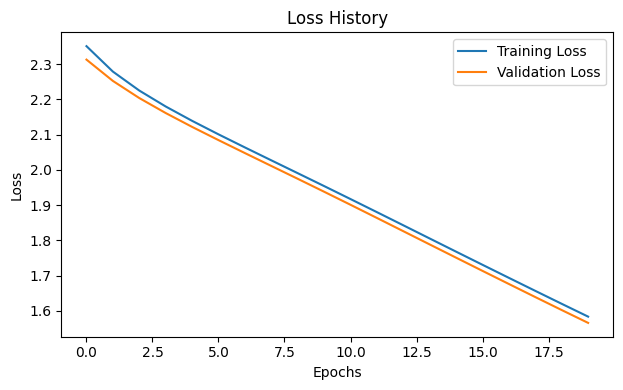


Evaluating model with learning rate 0.001...
Accuracy: 0.6037
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.89      0.78      1343
           1       0.91      0.85      0.88      1600
           2       0.68      0.56      0.61      1380
           3       0.55      0.76      0.64      1433
           4       0.93      0.05      0.09      1295
           5       0.31      0.40      0.35      1273
           6       0.84      0.59      0.69      1396
           7       0.51      0.77      0.61      1503
           8       0.50      0.66      0.57      1357
           9       0.63      0.42      0.51      1420

    accuracy                           0.60     14000
   macro avg       0.65      0.59      0.57     14000
weighted avg       0.66      0.60      0.58     14000



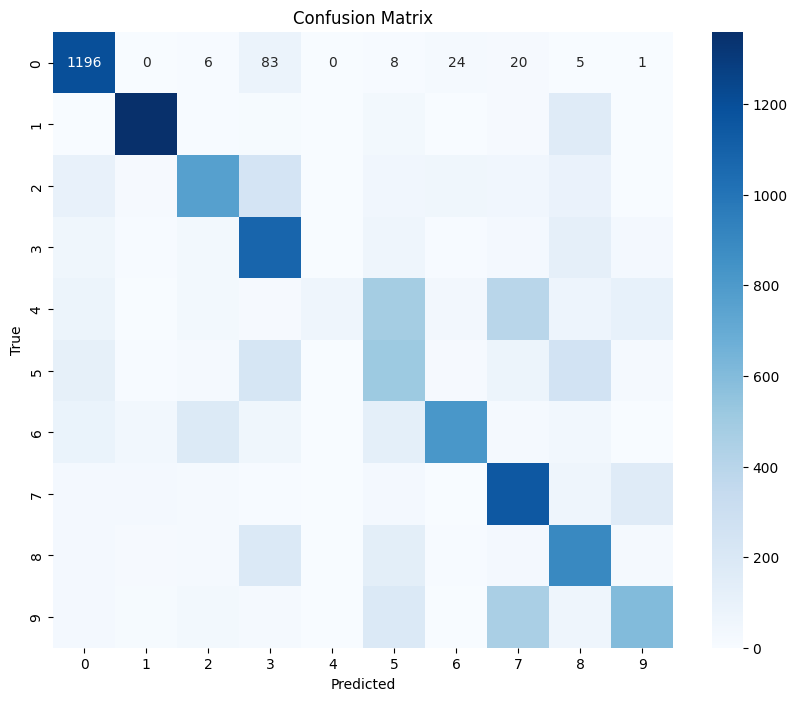

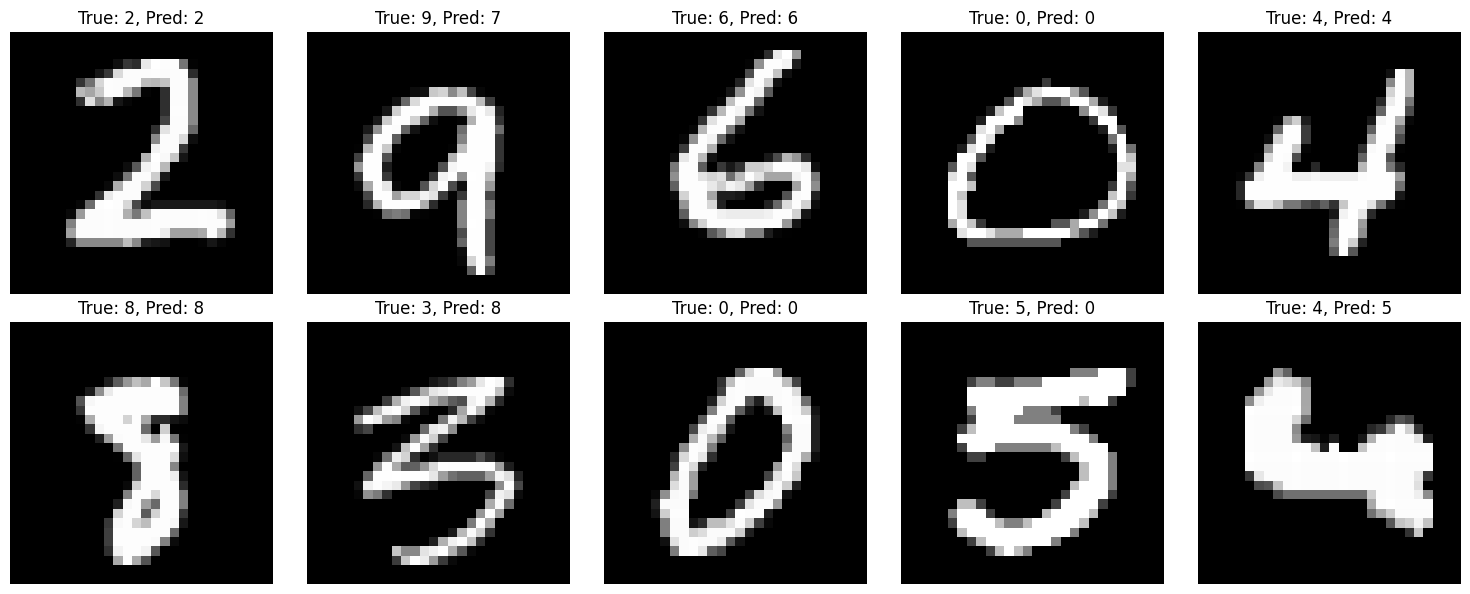


Weight distributions:


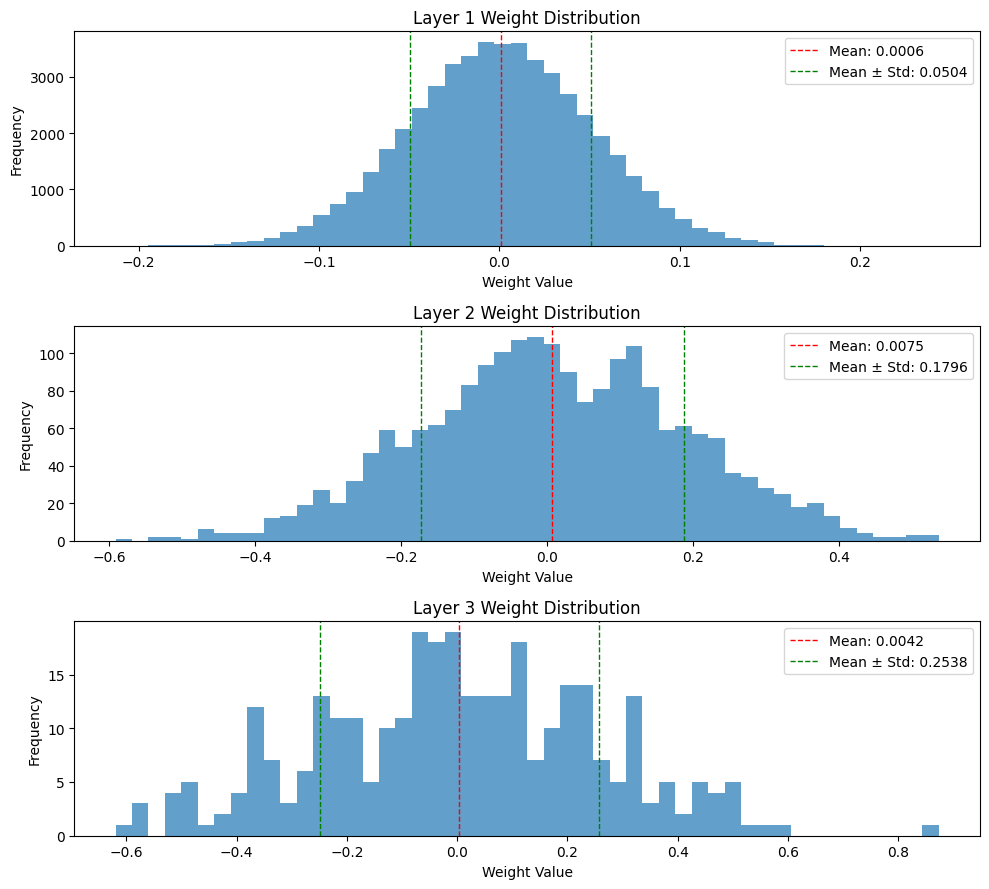


Gradient distributions:


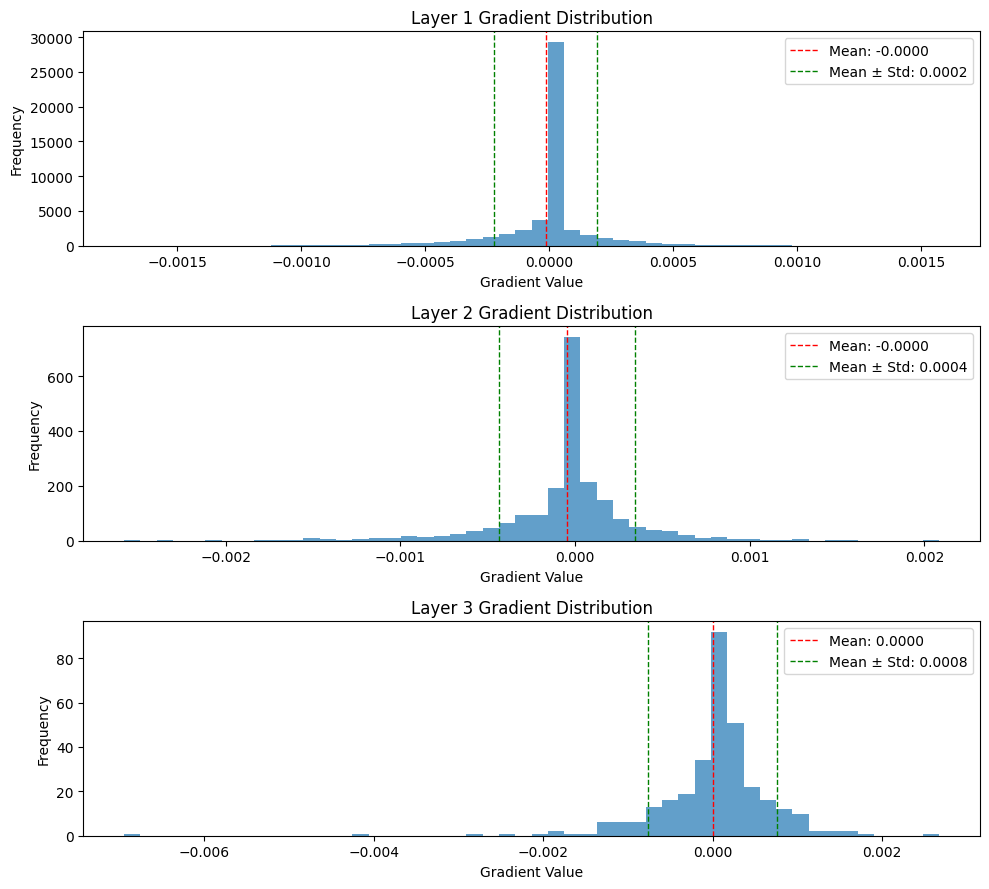


Training model with learning rate: 0.01
Epoch 1/20 [5.0%] - train_loss: 2.1510 - val_loss: 1.9927
Epoch 2/20 [10.0%] - train_loss: 1.8294 - val_loss: 1.6585
Epoch 3/20 [15.0%] - train_loss: 1.4929 - val_loss: 1.3325
Epoch 4/20 [20.0%] - train_loss: 1.1954 - val_loss: 1.0706
Epoch 5/20 [25.0%] - train_loss: 0.9716 - val_loss: 0.8863
Epoch 6/20 [30.0%] - train_loss: 0.8192 - val_loss: 0.7627
Epoch 7/20 [35.0%] - train_loss: 0.7160 - val_loss: 0.6772
Epoch 8/20 [40.0%] - train_loss: 0.6431 - val_loss: 0.6155
Epoch 9/20 [45.0%] - train_loss: 0.5892 - val_loss: 0.5692
Epoch 10/20 [50.0%] - train_loss: 0.5481 - val_loss: 0.5333
Epoch 11/20 [55.0%] - train_loss: 0.5158 - val_loss: 0.5046
Epoch 12/20 [60.0%] - train_loss: 0.4896 - val_loss: 0.4813
Epoch 13/20 [65.0%] - train_loss: 0.4680 - val_loss: 0.4617
Epoch 14/20 [70.0%] - train_loss: 0.4498 - val_loss: 0.4453
Epoch 15/20 [75.0%] - train_loss: 0.4343 - val_loss: 0.4309
Epoch 16/20 [80.0%] - train_loss: 0.4208 - val_loss: 0.4186
Epoch 17/

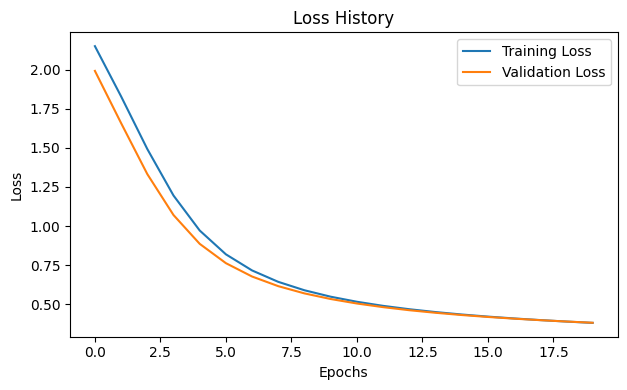


Evaluating model with learning rate 0.01...
Accuracy: 0.8932
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1343
           1       0.93      0.97      0.95      1600
           2       0.89      0.86      0.87      1380
           3       0.87      0.86      0.87      1433
           4       0.88      0.90      0.89      1295
           5       0.88      0.82      0.85      1273
           6       0.91      0.93      0.92      1396
           7       0.91      0.91      0.91      1503
           8       0.85      0.84      0.85      1357
           9       0.86      0.87      0.86      1420

    accuracy                           0.89     14000
   macro avg       0.89      0.89      0.89     14000
weighted avg       0.89      0.89      0.89     14000



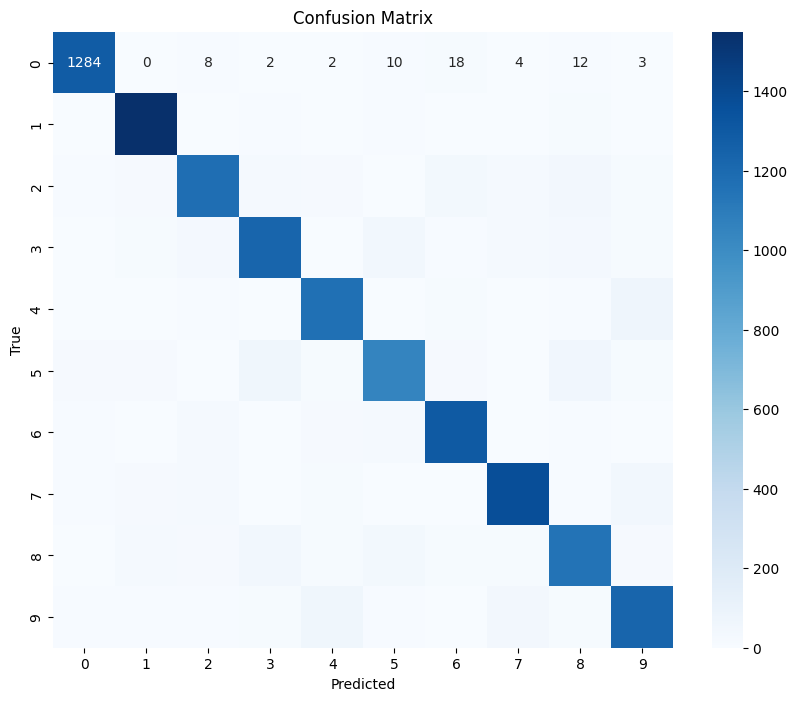

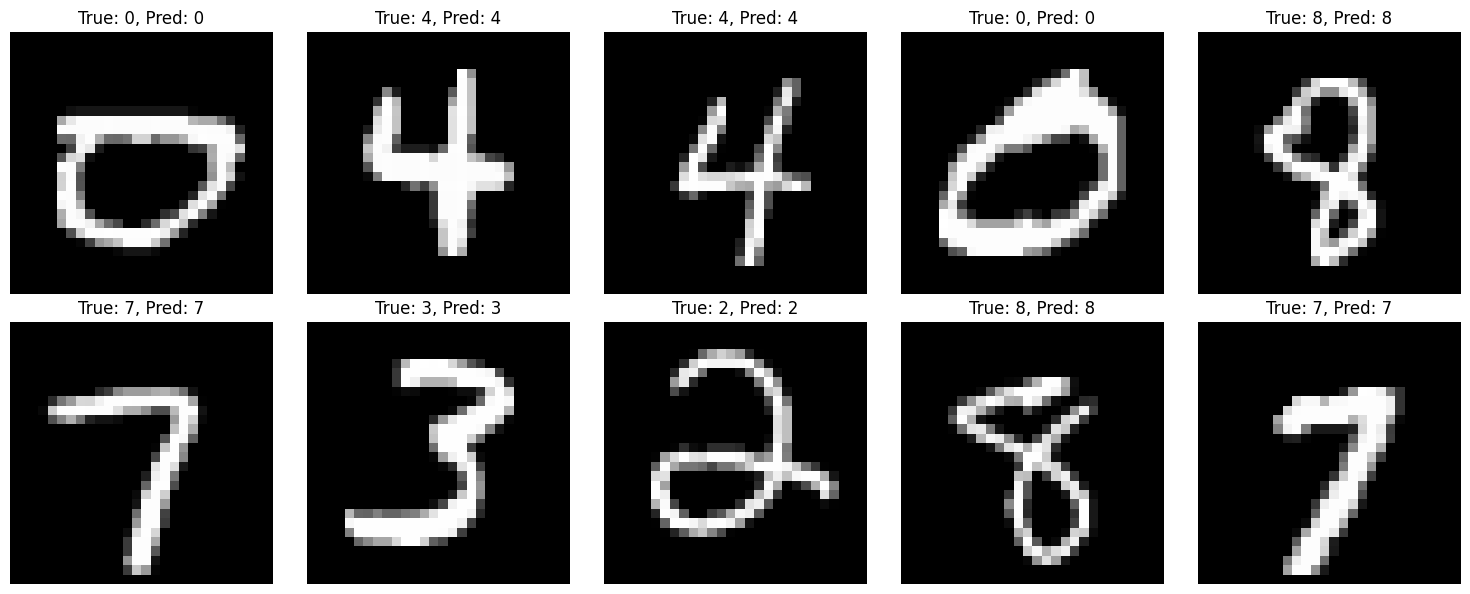


Weight distributions:


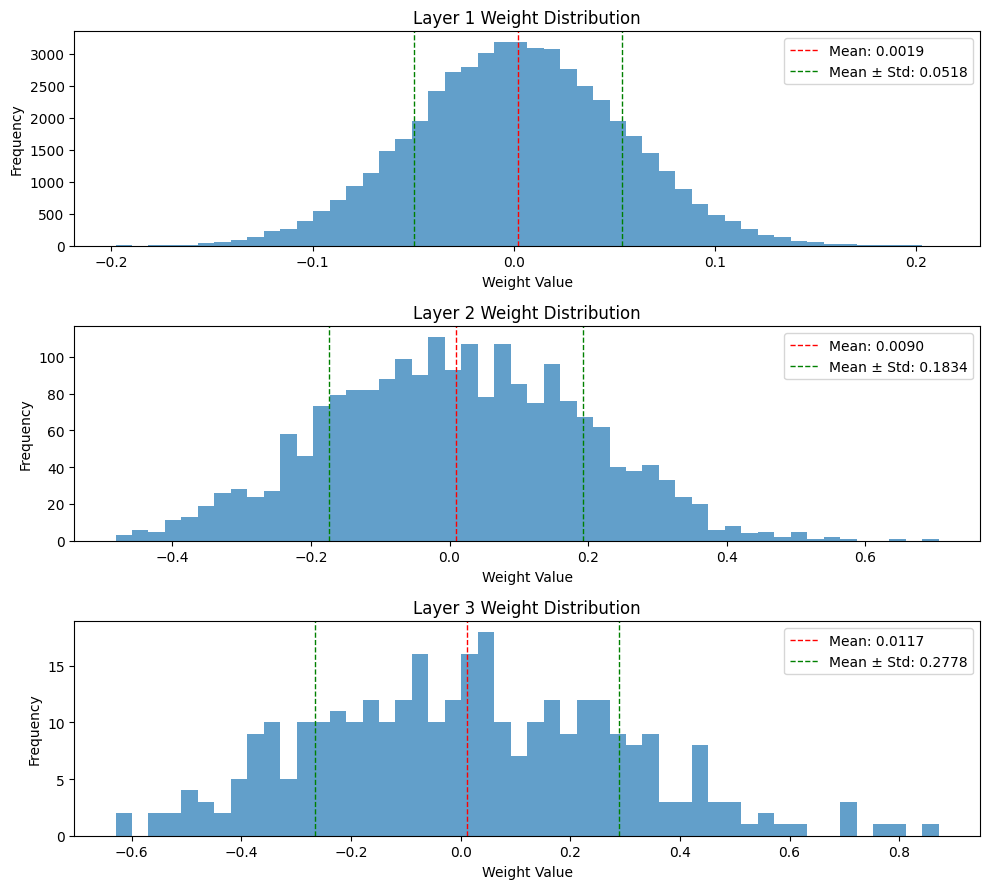


Gradient distributions:


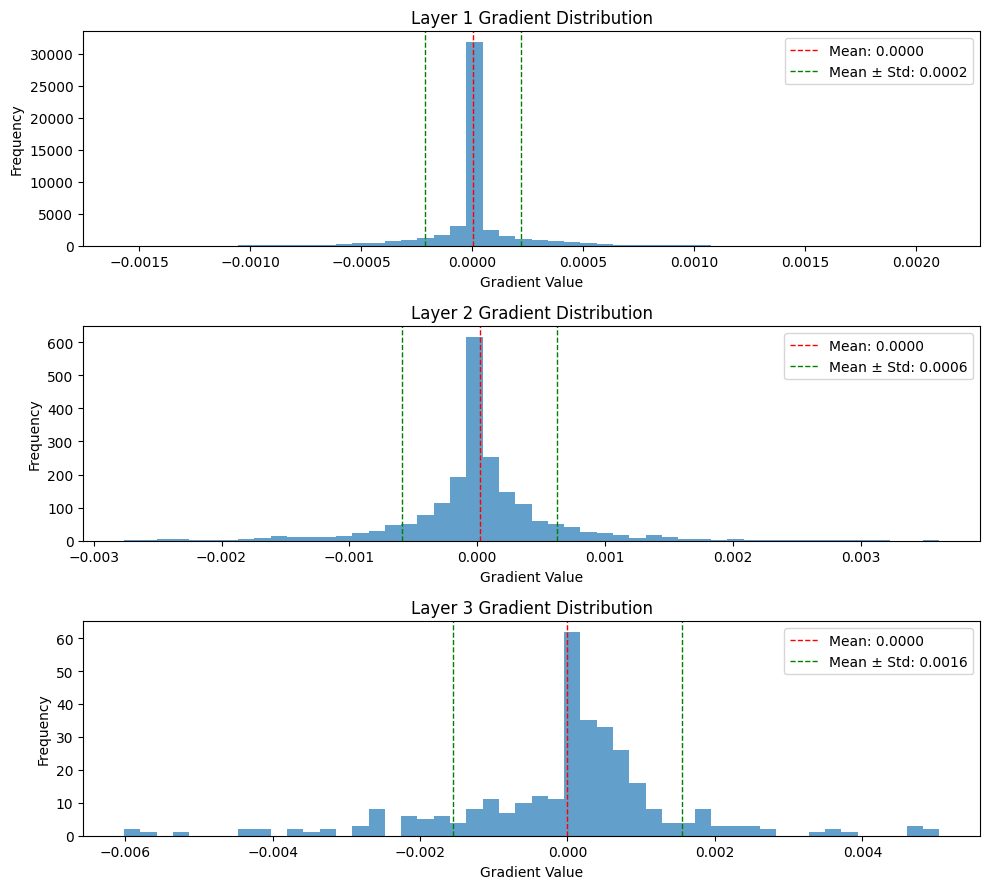


Training model with learning rate: 0.1
Epoch 1/20 [5.0%] - train_loss: 1.1051 - val_loss: 0.5616
Epoch 2/20 [10.0%] - train_loss: 0.4701 - val_loss: 0.3985
Epoch 3/20 [15.0%] - train_loss: 0.3713 - val_loss: 0.3440
Epoch 4/20 [20.0%] - train_loss: 0.3281 - val_loss: 0.3135
Epoch 5/20 [25.0%] - train_loss: 0.3012 - val_loss: 0.2944
Epoch 6/20 [30.0%] - train_loss: 0.2811 - val_loss: 0.2762
Epoch 7/20 [35.0%] - train_loss: 0.2647 - val_loss: 0.2643
Epoch 8/20 [40.0%] - train_loss: 0.2508 - val_loss: 0.2515
Epoch 9/20 [45.0%] - train_loss: 0.2382 - val_loss: 0.2430
Epoch 10/20 [50.0%] - train_loss: 0.2275 - val_loss: 0.2323
Epoch 11/20 [55.0%] - train_loss: 0.2172 - val_loss: 0.2278
Epoch 12/20 [60.0%] - train_loss: 0.2083 - val_loss: 0.2213
Epoch 13/20 [65.0%] - train_loss: 0.2003 - val_loss: 0.2104
Epoch 14/20 [70.0%] - train_loss: 0.1928 - val_loss: 0.2051
Epoch 15/20 [75.0%] - train_loss: 0.1858 - val_loss: 0.1987
Epoch 16/20 [80.0%] - train_loss: 0.1795 - val_loss: 0.1944
Epoch 17/2

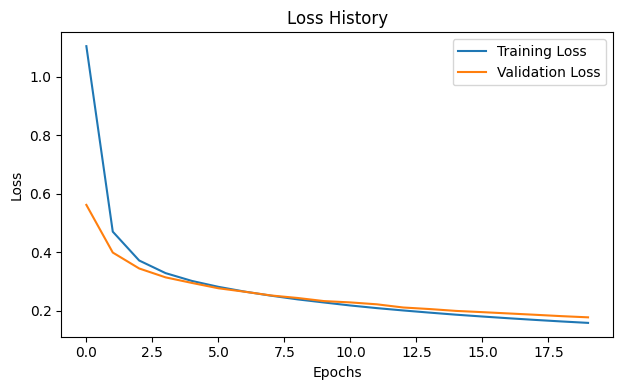


Evaluating model with learning rate 0.1...
Accuracy: 0.9506
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      1343
           1       0.97      0.98      0.97      1600
           2       0.95      0.95      0.95      1380
           3       0.94      0.93      0.94      1433
           4       0.94      0.95      0.95      1295
           5       0.94      0.95      0.94      1273
           6       0.96      0.97      0.96      1396
           7       0.95      0.95      0.95      1503
           8       0.95      0.92      0.94      1357
           9       0.93      0.94      0.93      1420

    accuracy                           0.95     14000
   macro avg       0.95      0.95      0.95     14000
weighted avg       0.95      0.95      0.95     14000



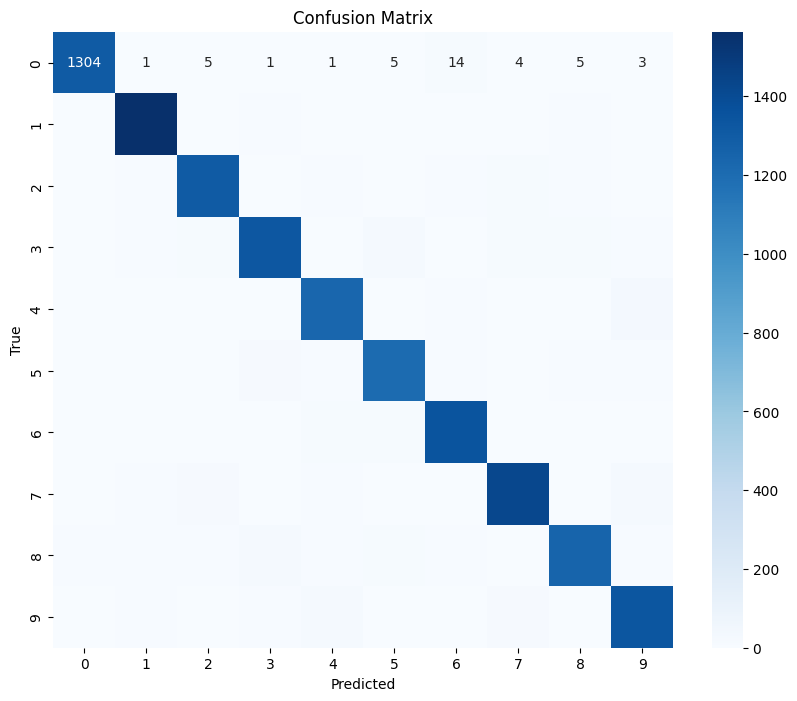

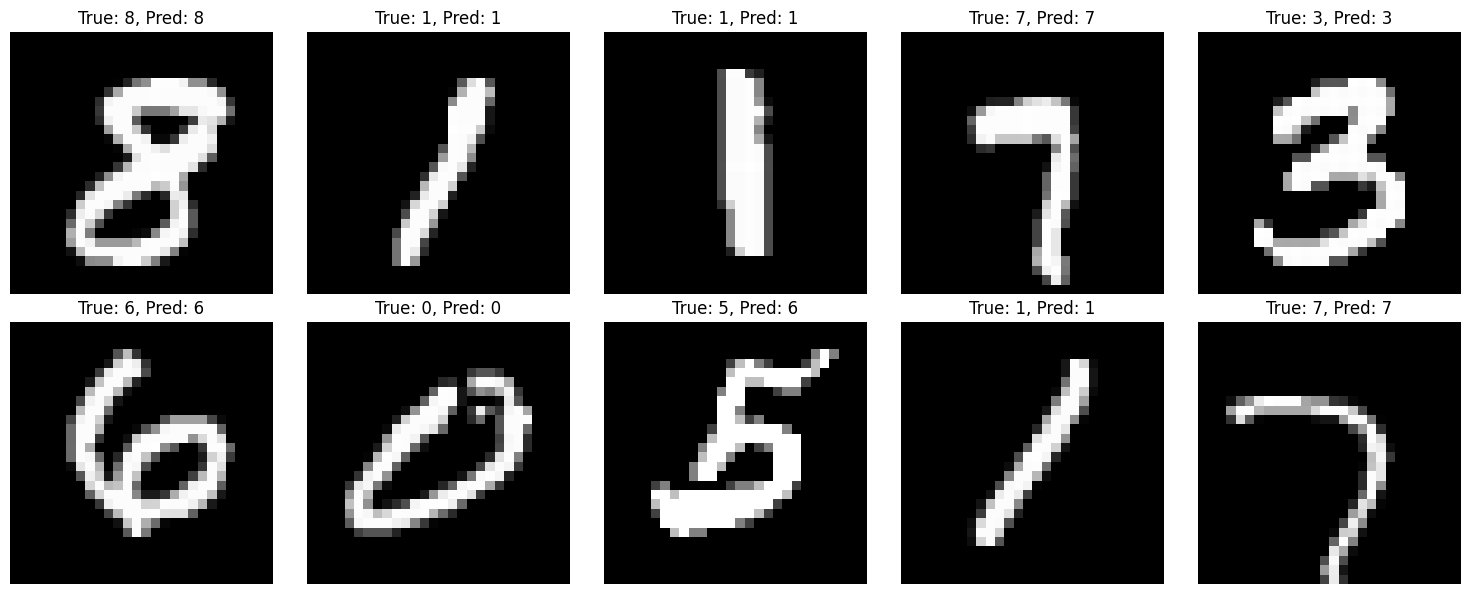


Weight distributions:


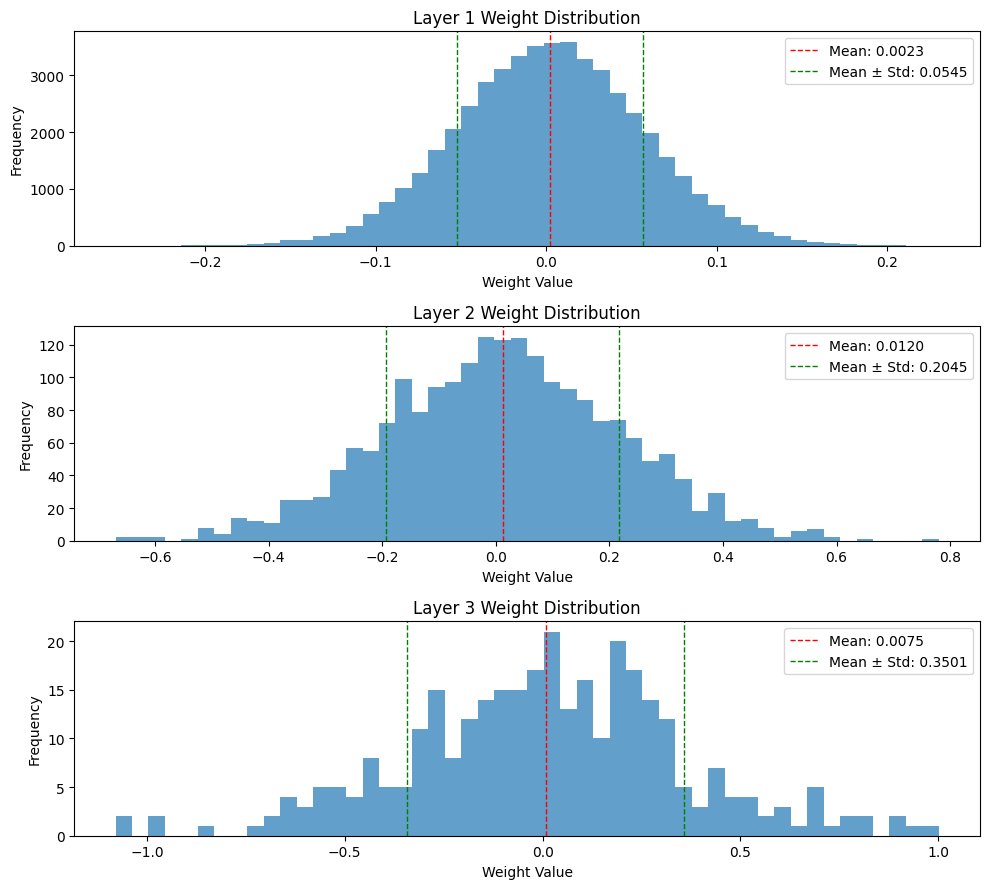


Gradient distributions:


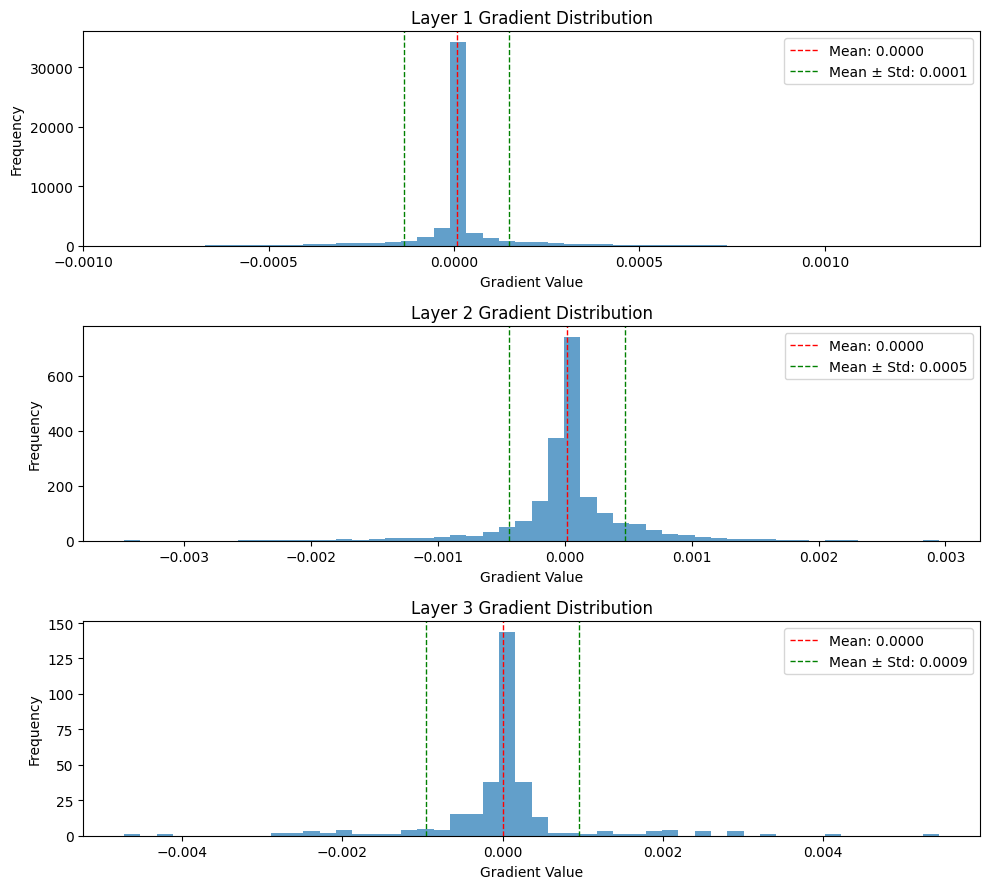


Learning Rate Comparison Results:
   learning_rate  accuracy  final_train_loss  final_val_loss  training_time
0          0.001  0.603714          1.584013        1.566282      31.308672
1          0.010  0.893214          0.380573        0.381392      30.163101
2          0.100  0.950643          0.157693        0.176695      30.282074


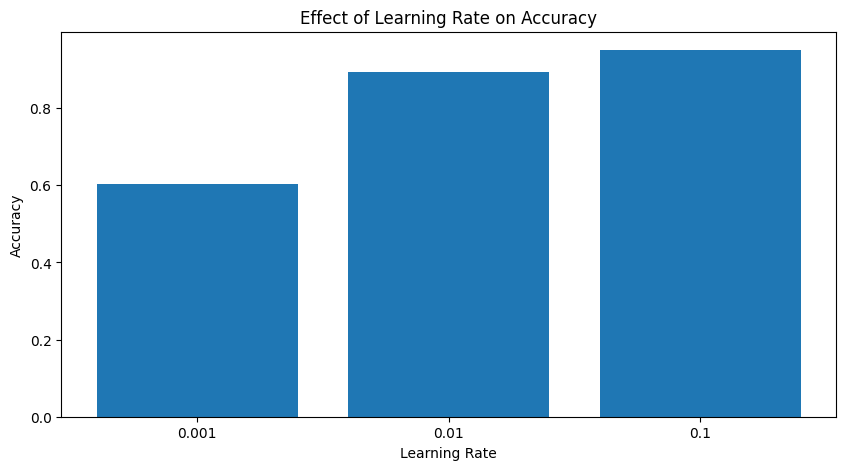

In [14]:
lr_results = []

for lr in learning_rates:
    print(f"\nTraining model with learning rate: {lr}")
    
    
    model = FFNN_model.FeedforwardNeuralNetwork(
        input_size=X_train.shape[1],
        layer_sizes=base_architecture['layers'],
        activations=base_architecture['activations'],
        loss=base_architecture['loss']
    )
    
    
    start_time = time.time()
    history = model.train(
        X_train=X_train,
        y_train=y_train_onehot,
        X_val=X_test,
        y_val=y_test_onehot,
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        learning_rate=lr,
        verbose=1
    )
    training_time = time.time() - start_time
    
    
    plot_history(history)
    
    
    print(f"\nEvaluating model with learning rate {lr}...")
    accuracy, _ = evaluate_model(model, X_test, y_test_onehot, y_test)
    
    
    print("\nWeight distributions:")
    model.plot_weight_distribution(list(range(len(base_architecture['layers']))))
    plt.show()
    
    print("\nGradient distributions:")
    model.plot_gradient_distribution(list(range(len(base_architecture['layers']))))
    plt.show()
    
    
    lr_results.append({
        'learning_rate': lr,
        'accuracy': accuracy,
        'training_time': training_time,
        'final_train_loss': history['train_loss'][-1],
        'final_val_loss': history['val_loss'][-1] if 'val_loss' in history else None
    })

# Display learning rate results
print("\nLearning Rate Comparison Results:")
lr_df = pd.DataFrame(lr_results)
print(lr_df[['learning_rate', 'accuracy', 'final_train_loss', 'final_val_loss', 'training_time']])

plt.figure(figsize=(10, 5))
plt.bar([str(r['learning_rate']) for r in lr_results], [r['accuracy'] for r in lr_results])
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.title('Effect of Learning Rate on Accuracy')
plt.show()

## Experiment 4 : Effect of Weight Initialization

In [15]:
weight_inits = [
    {
        'name': 'Zero',
        'method': 'zero',
        'params': {}
    },
    {
        'name': 'Uniform',
        'method': 'uniform',
        'params': {'low': -0.1, 'high': 0.1, 'seed': 42}
    },
    {
        'name': 'Normal',
        'method': 'normal',
        'params': {'mean': 0, 'var': 0.1, 'seed': 42}
    },
    {
        'name': 'Xavier',
        'method': 'xavier',
        'params': {'seed': 42}
    },
    {
        'name': 'He',
        'method': 'he',
        'params': {'seed': 42}
    }
]

base_architecture = {
    'layers': [64, 32, 10],
    'activations': ['relu', 'relu', 'softmax'],
    'loss': 'categorical_cross_entropy'
}

params = {
    'epochs': 15,
    'batch_size': 32,
    'learning_rate': 0.01
}


Training model with weight initialization: Zero
Epoch 1/15 [6.7%] - train_loss: 2.3025 - val_loss: 2.3024
Epoch 2/15 [13.3%] - train_loss: 2.3024 - val_loss: 2.3023
Epoch 3/15 [20.0%] - train_loss: 2.3023 - val_loss: 2.3021
Epoch 4/15 [26.7%] - train_loss: 2.3022 - val_loss: 2.3020
Epoch 5/15 [33.3%] - train_loss: 2.3021 - val_loss: 2.3019
Epoch 6/15 [40.0%] - train_loss: 2.3020 - val_loss: 2.3018
Epoch 7/15 [46.7%] - train_loss: 2.3019 - val_loss: 2.3017
Epoch 8/15 [53.3%] - train_loss: 2.3018 - val_loss: 2.3017
Epoch 9/15 [60.0%] - train_loss: 2.3018 - val_loss: 2.3016
Epoch 10/15 [66.7%] - train_loss: 2.3017 - val_loss: 2.3015
Epoch 11/15 [73.3%] - train_loss: 2.3017 - val_loss: 2.3015
Epoch 12/15 [80.0%] - train_loss: 2.3016 - val_loss: 2.3014
Epoch 13/15 [86.7%] - train_loss: 2.3016 - val_loss: 2.3014
Epoch 14/15 [93.3%] - train_loss: 2.3015 - val_loss: 2.3013
Epoch 15/15 [100.0%] - train_loss: 2.3015 - val_loss: 2.3013


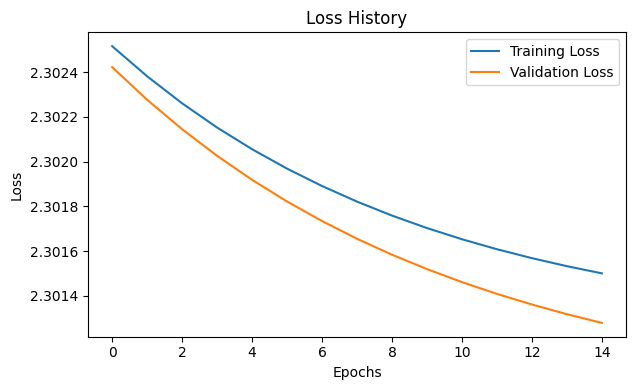


Evaluating model with Zero initialization...
Accuracy: 0.1143
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1343
           1       0.11      1.00      0.21      1600
           2       0.00      0.00      0.00      1380
           3       0.00      0.00      0.00      1433
           4       0.00      0.00      0.00      1295
           5       0.00      0.00      0.00      1273
           6       0.00      0.00      0.00      1396
           7       0.00      0.00      0.00      1503
           8       0.00      0.00      0.00      1357
           9       0.00      0.00      0.00      1420

    accuracy                           0.11     14000
   macro avg       0.01      0.10      0.02     14000
weighted avg       0.01      0.11      0.02     14000



c:\Users\A C E R\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\A C E R\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\A C E R\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

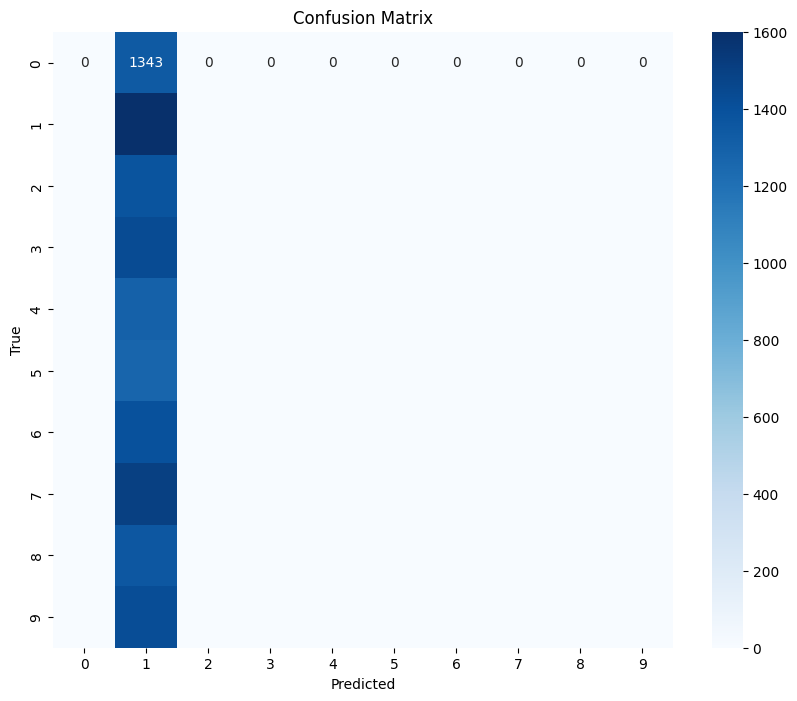

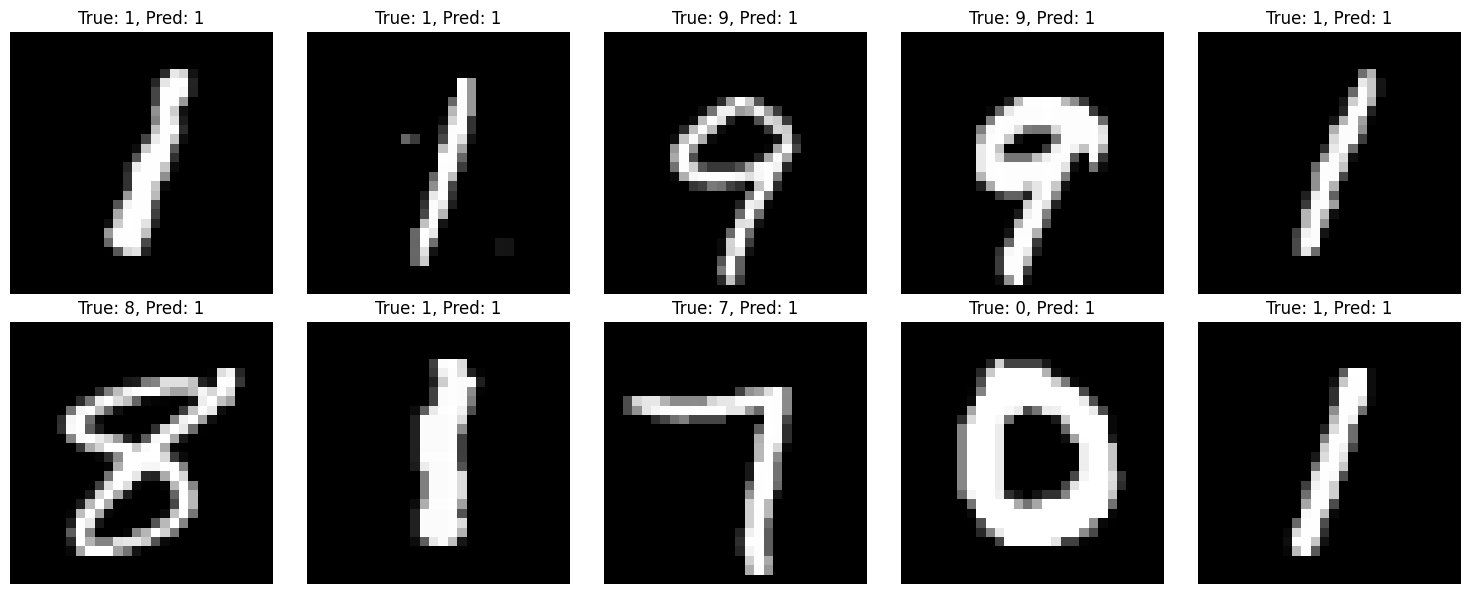


Weight distributions:


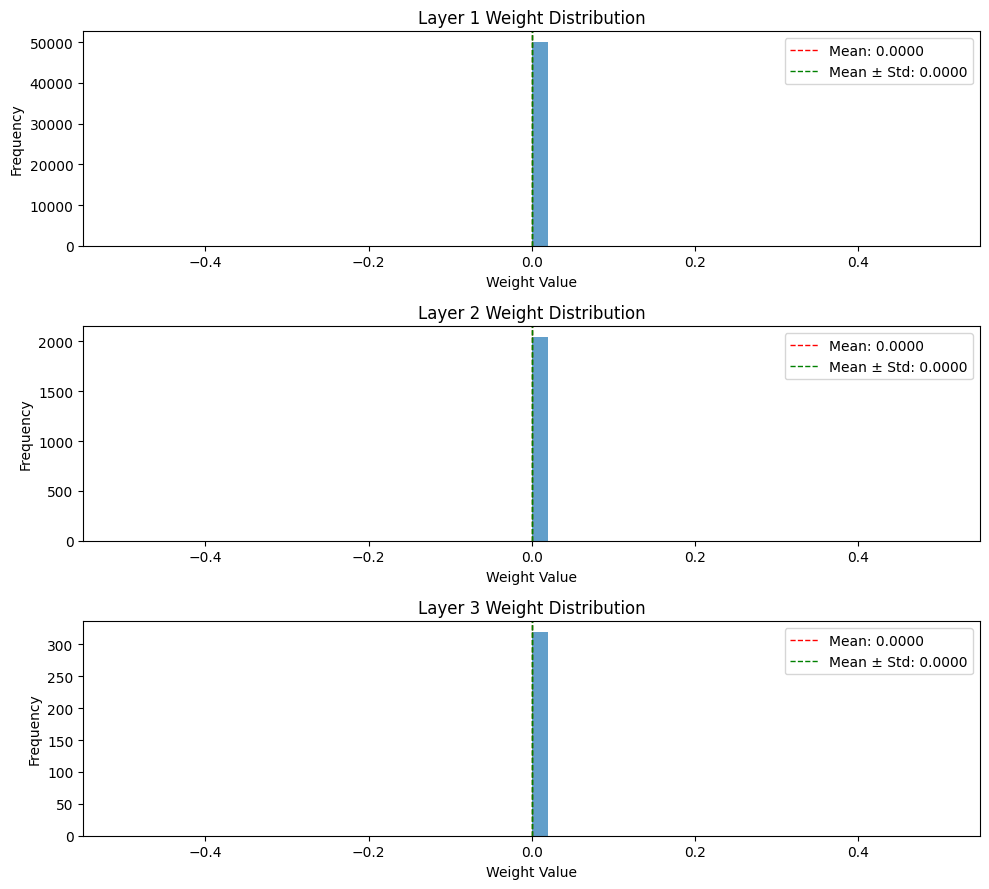


Training model with weight initialization: Uniform
Epoch 1/15 [6.7%] - train_loss: 2.3000 - val_loss: 2.2960
Epoch 2/15 [13.3%] - train_loss: 2.2911 - val_loss: 2.2869
Epoch 3/15 [20.0%] - train_loss: 2.2814 - val_loss: 2.2764
Epoch 4/15 [26.7%] - train_loss: 2.2699 - val_loss: 2.2638
Epoch 5/15 [33.3%] - train_loss: 2.2556 - val_loss: 2.2477
Epoch 6/15 [40.0%] - train_loss: 2.2368 - val_loss: 2.2262
Epoch 7/15 [46.7%] - train_loss: 2.2116 - val_loss: 2.1970
Epoch 8/15 [53.3%] - train_loss: 2.1770 - val_loss: 2.1572
Epoch 9/15 [60.0%] - train_loss: 2.1298 - val_loss: 2.1025
Epoch 10/15 [66.7%] - train_loss: 2.0655 - val_loss: 2.0287
Epoch 11/15 [73.3%] - train_loss: 1.9804 - val_loss: 1.9331
Epoch 12/15 [80.0%] - train_loss: 1.8742 - val_loss: 1.8173
Epoch 13/15 [86.7%] - train_loss: 1.7512 - val_loss: 1.6883
Epoch 14/15 [93.3%] - train_loss: 1.6202 - val_loss: 1.5561
Epoch 15/15 [100.0%] - train_loss: 1.4914 - val_loss: 1.4303


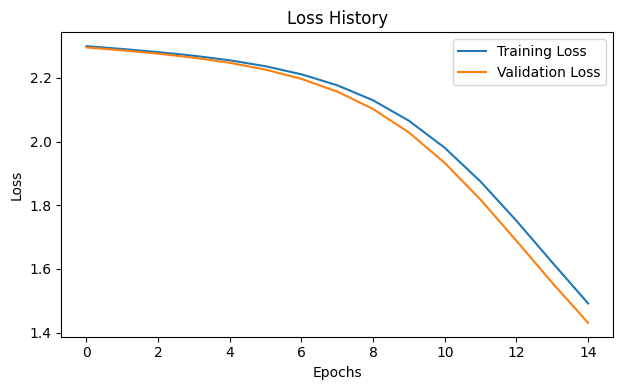


Evaluating model with Uniform initialization...
Accuracy: 0.6374
Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.95      0.74      1343
           1       0.70      0.97      0.81      1600
           2       0.79      0.59      0.67      1380
           3       0.50      0.76      0.61      1433
           4       0.62      0.65      0.64      1295
           5       0.98      0.04      0.08      1273
           6       0.77      0.52      0.62      1396
           7       0.71      0.79      0.75      1503
           8       0.50      0.40      0.45      1357
           9       0.61      0.58      0.60      1420

    accuracy                           0.64     14000
   macro avg       0.68      0.63      0.60     14000
weighted avg       0.68      0.64      0.60     14000



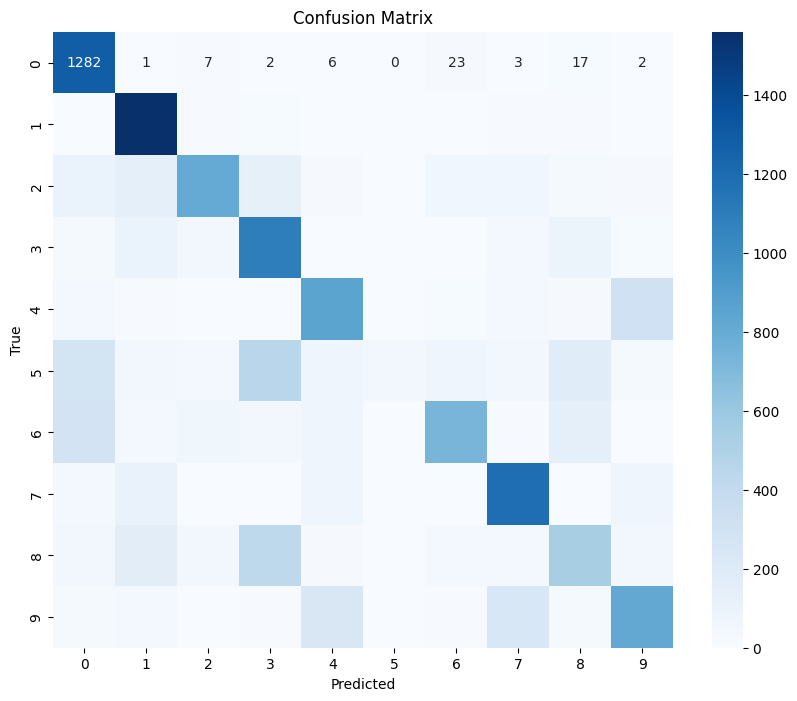

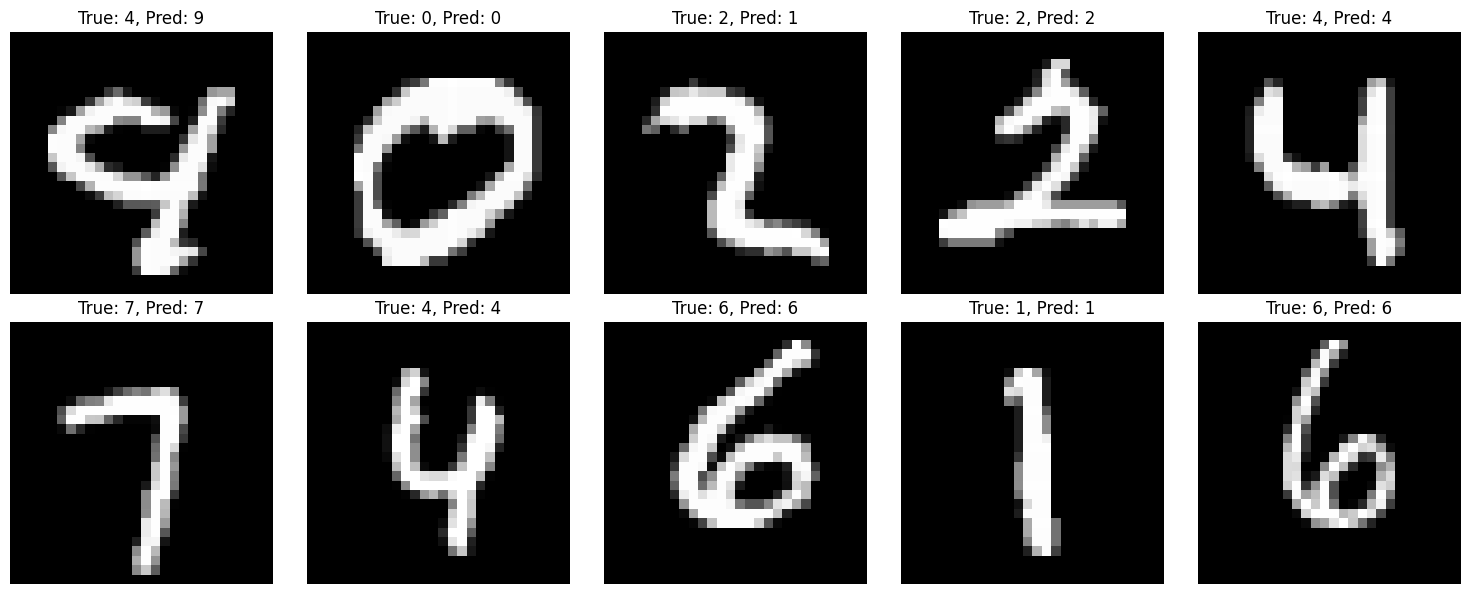


Weight distributions:


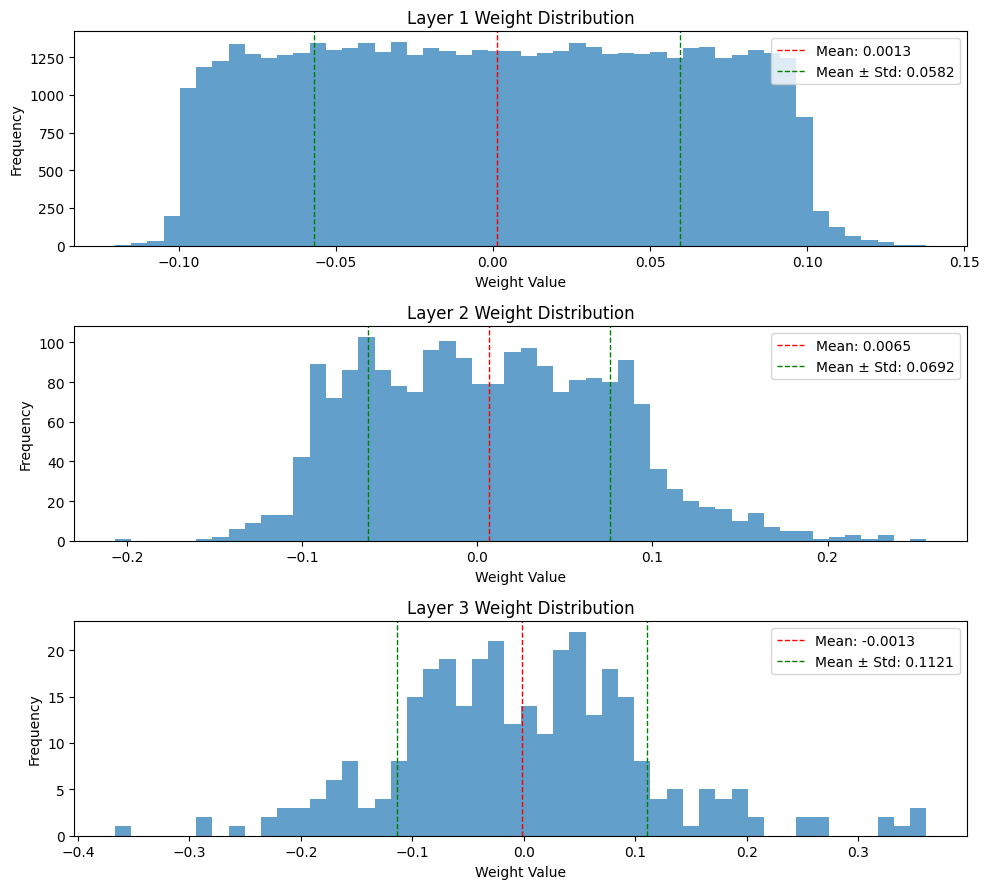


Training model with weight initialization: Normal
Epoch 1/15 [6.7%] - train_loss: 3.9263 - val_loss: 2.3379
Epoch 2/15 [13.3%] - train_loss: 1.9369 - val_loss: 1.6458
Epoch 3/15 [20.0%] - train_loss: 1.5031 - val_loss: 1.3765
Epoch 4/15 [26.7%] - train_loss: 1.3003 - val_loss: 1.2233
Epoch 5/15 [33.3%] - train_loss: 1.1744 - val_loss: 1.1190
Epoch 6/15 [40.0%] - train_loss: 1.0841 - val_loss: 1.0392
Epoch 7/15 [46.7%] - train_loss: 1.0145 - val_loss: 0.9768
Epoch 8/15 [53.3%] - train_loss: 0.9582 - val_loss: 0.9262
Epoch 9/15 [60.0%] - train_loss: 0.9114 - val_loss: 0.8820
Epoch 10/15 [66.7%] - train_loss: 0.8716 - val_loss: 0.8444
Epoch 11/15 [73.3%] - train_loss: 0.8374 - val_loss: 0.8118
Epoch 12/15 [80.0%] - train_loss: 0.8075 - val_loss: 0.7837
Epoch 13/15 [86.7%] - train_loss: 0.7810 - val_loss: 0.7590
Epoch 14/15 [93.3%] - train_loss: 0.7575 - val_loss: 0.7365
Epoch 15/15 [100.0%] - train_loss: 0.7365 - val_loss: 0.7156


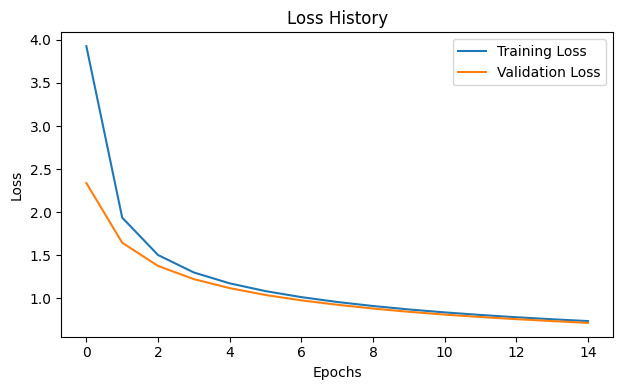


Evaluating model with Normal initialization...
Accuracy: 0.7761
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.88      0.88      1343
           1       0.89      0.94      0.91      1600
           2       0.76      0.74      0.75      1380
           3       0.75      0.76      0.75      1433
           4       0.73      0.73      0.73      1295
           5       0.70      0.65      0.68      1273
           6       0.82      0.83      0.82      1396
           7       0.83      0.82      0.83      1503
           8       0.65      0.65      0.65      1357
           9       0.72      0.72      0.72      1420

    accuracy                           0.78     14000
   macro avg       0.77      0.77      0.77     14000
weighted avg       0.77      0.78      0.78     14000



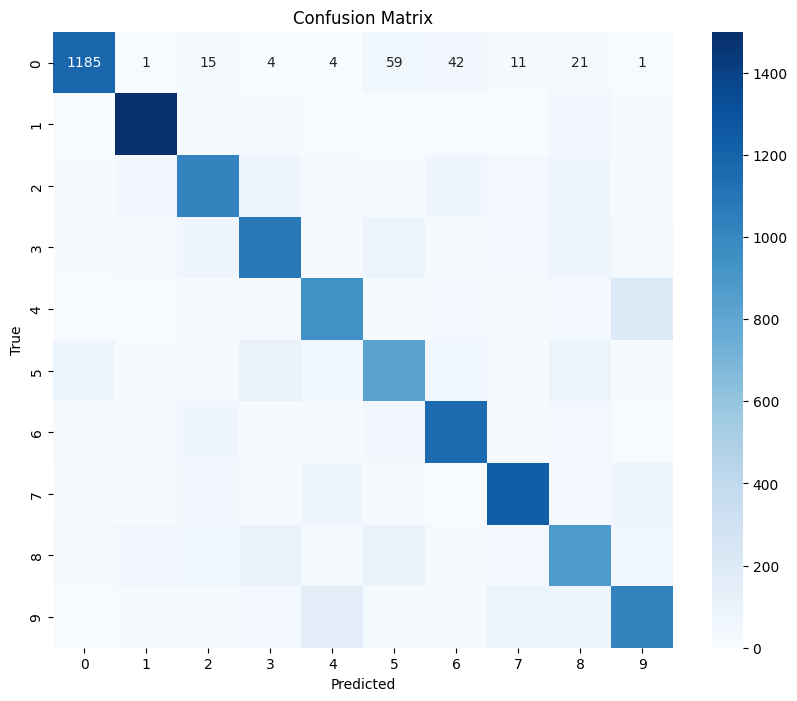

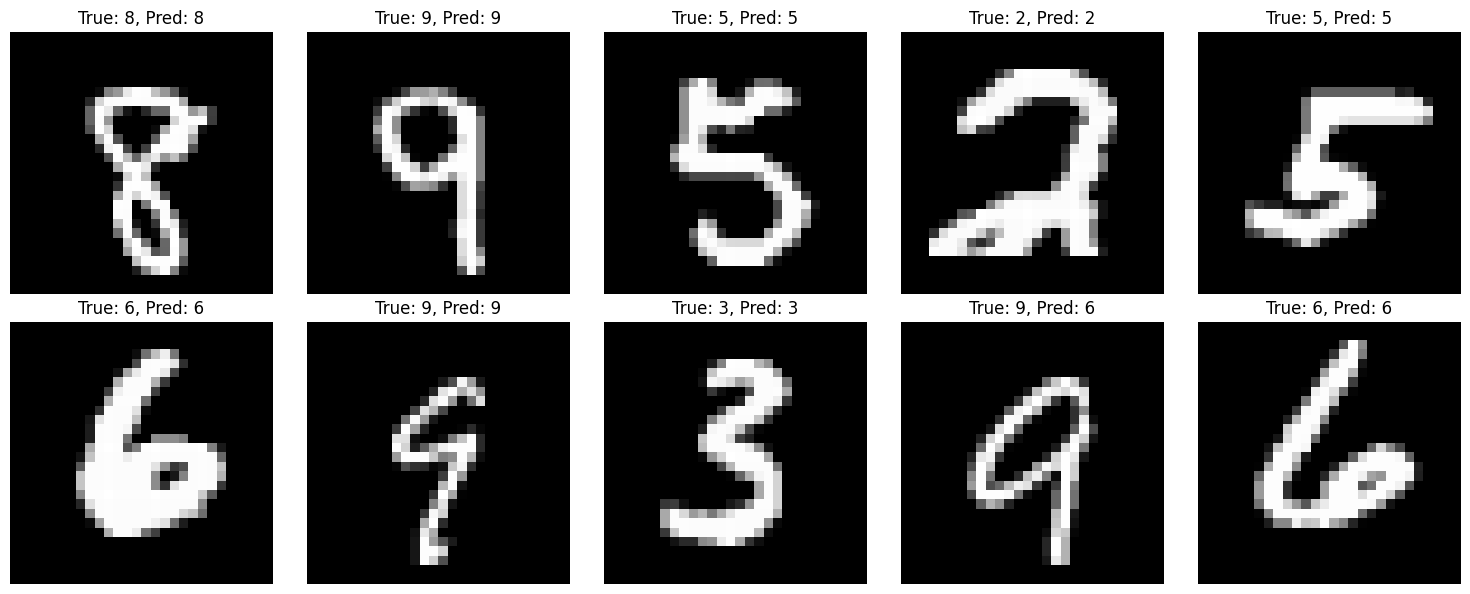


Weight distributions:


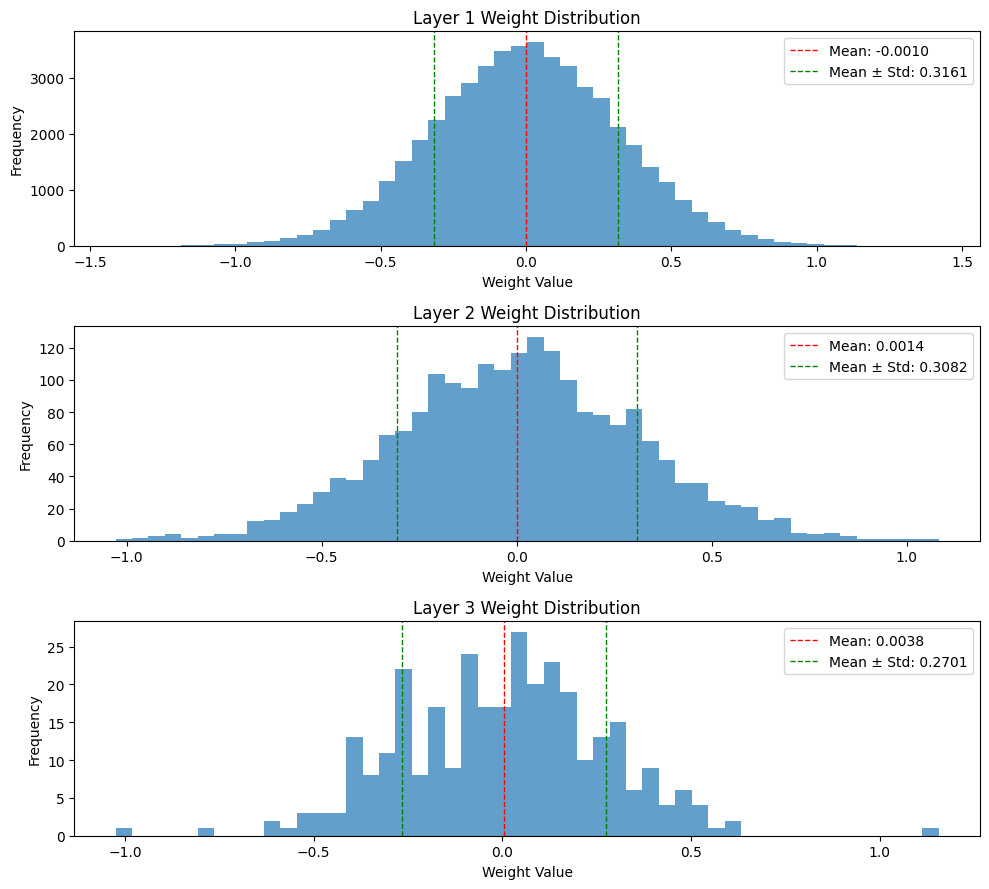


Training model with weight initialization: Xavier
Epoch 1/15 [6.7%] - train_loss: 2.1967 - val_loss: 2.0702
Epoch 2/15 [13.3%] - train_loss: 1.9346 - val_loss: 1.8000
Epoch 3/15 [20.0%] - train_loss: 1.6618 - val_loss: 1.5317
Epoch 4/15 [26.7%] - train_loss: 1.4085 - val_loss: 1.2934
Epoch 5/15 [33.3%] - train_loss: 1.1935 - val_loss: 1.0996
Epoch 6/15 [40.0%] - train_loss: 1.0249 - val_loss: 0.9525
Epoch 7/15 [46.7%] - train_loss: 0.8988 - val_loss: 0.8435
Epoch 8/15 [53.3%] - train_loss: 0.8043 - val_loss: 0.7615
Epoch 9/15 [60.0%] - train_loss: 0.7320 - val_loss: 0.6975
Epoch 10/15 [66.7%] - train_loss: 0.6752 - val_loss: 0.6470
Epoch 11/15 [73.3%] - train_loss: 0.6297 - val_loss: 0.6063
Epoch 12/15 [80.0%] - train_loss: 0.5926 - val_loss: 0.5731
Epoch 13/15 [86.7%] - train_loss: 0.5619 - val_loss: 0.5453
Epoch 14/15 [93.3%] - train_loss: 0.5360 - val_loss: 0.5221
Epoch 15/15 [100.0%] - train_loss: 0.5141 - val_loss: 0.5020


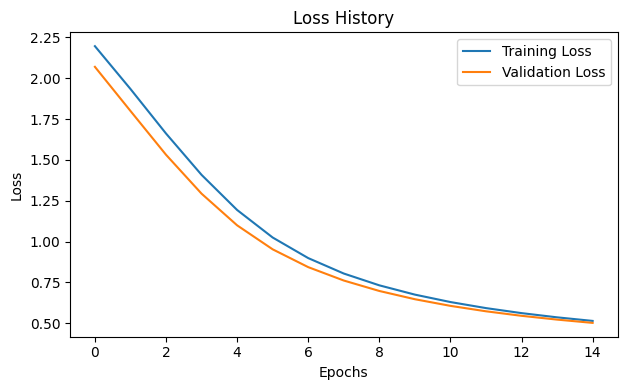


Evaluating model with Xavier initialization...
Accuracy: 0.8703
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      1343
           1       0.90      0.96      0.93      1600
           2       0.89      0.84      0.87      1380
           3       0.83      0.83      0.83      1433
           4       0.87      0.88      0.88      1295
           5       0.85      0.76      0.80      1273
           6       0.89      0.92      0.91      1396
           7       0.89      0.90      0.90      1503
           8       0.81      0.81      0.81      1357
           9       0.83      0.84      0.83      1420

    accuracy                           0.87     14000
   macro avg       0.87      0.87      0.87     14000
weighted avg       0.87      0.87      0.87     14000



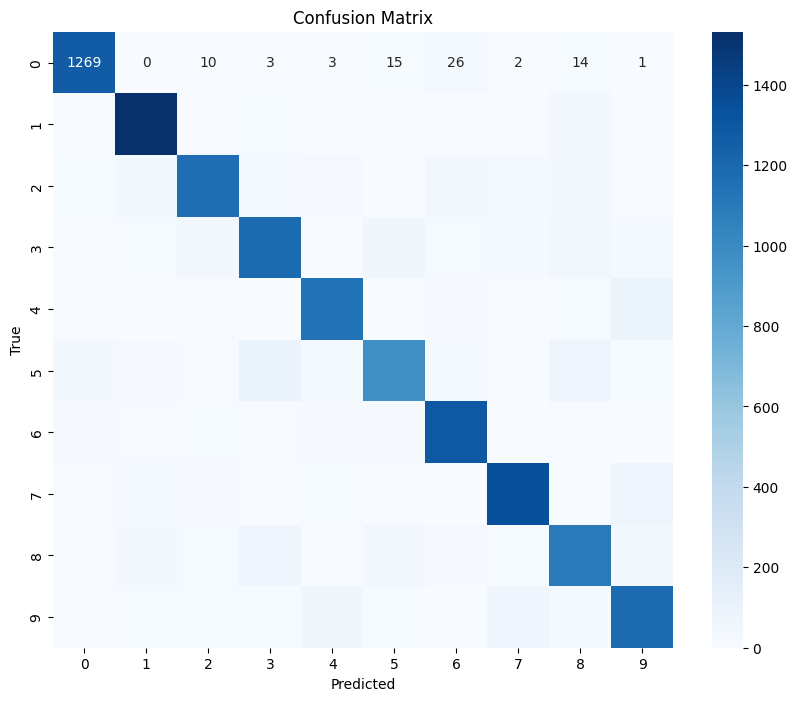

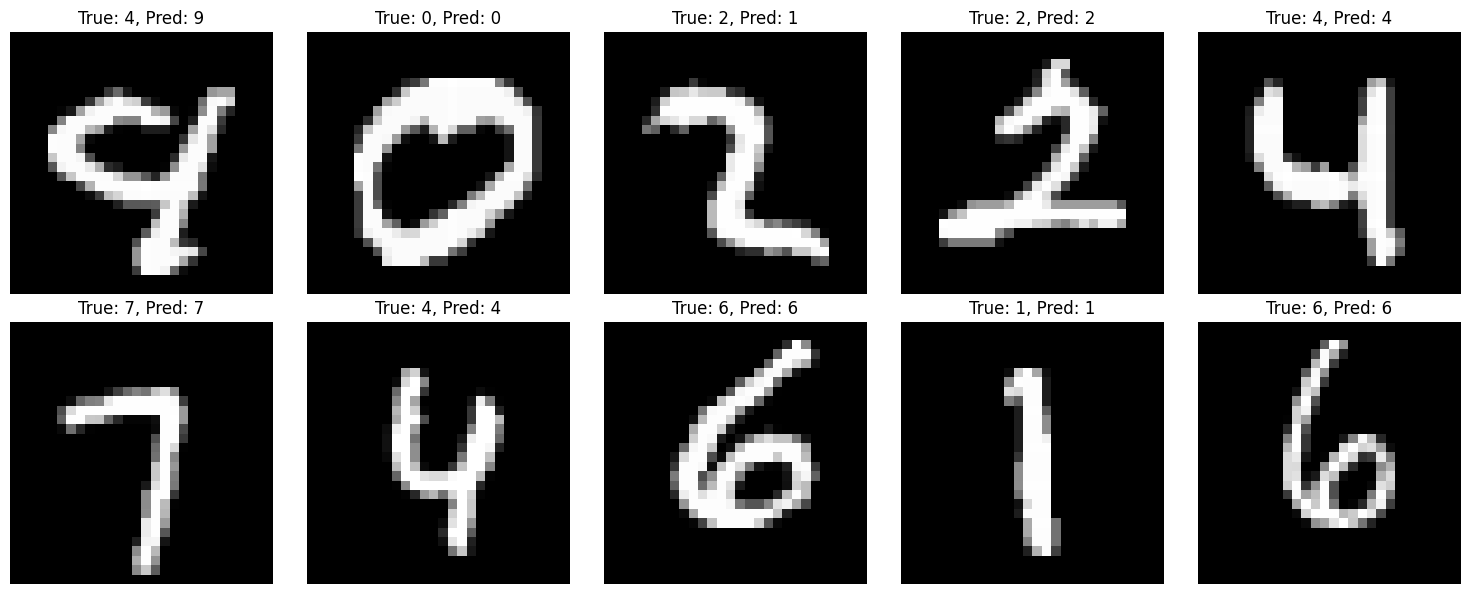


Weight distributions:


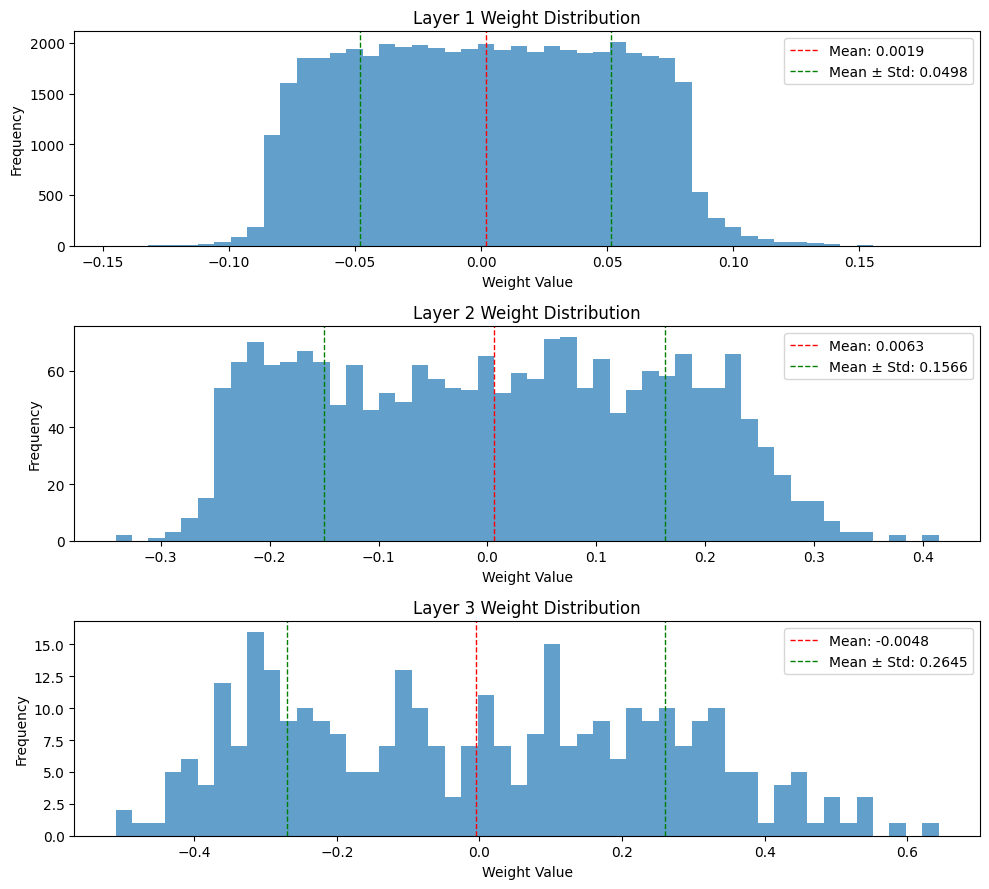


Training model with weight initialization: He
Epoch 1/15 [6.7%] - train_loss: 2.0968 - val_loss: 1.8448
Epoch 2/15 [13.3%] - train_loss: 1.6291 - val_loss: 1.4279
Epoch 3/15 [20.0%] - train_loss: 1.2717 - val_loss: 1.1299
Epoch 4/15 [26.7%] - train_loss: 1.0333 - val_loss: 0.9425
Epoch 5/15 [33.3%] - train_loss: 0.8835 - val_loss: 0.8221
Epoch 6/15 [40.0%] - train_loss: 0.7836 - val_loss: 0.7385
Epoch 7/15 [46.7%] - train_loss: 0.7121 - val_loss: 0.6770
Epoch 8/15 [53.3%] - train_loss: 0.6577 - val_loss: 0.6293
Epoch 9/15 [60.0%] - train_loss: 0.6145 - val_loss: 0.5906
Epoch 10/15 [66.7%] - train_loss: 0.5791 - val_loss: 0.5586
Epoch 11/15 [73.3%] - train_loss: 0.5494 - val_loss: 0.5315
Epoch 12/15 [80.0%] - train_loss: 0.5241 - val_loss: 0.5086
Epoch 13/15 [86.7%] - train_loss: 0.5021 - val_loss: 0.4888
Epoch 14/15 [93.3%] - train_loss: 0.4829 - val_loss: 0.4714
Epoch 15/15 [100.0%] - train_loss: 0.4661 - val_loss: 0.4556


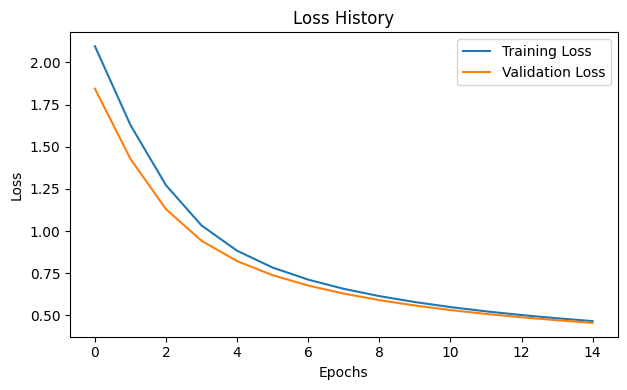


Evaluating model with He initialization...
Accuracy: 0.8779
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.93      0.94      1343
           1       0.91      0.97      0.94      1600
           2       0.89      0.84      0.86      1380
           3       0.84      0.85      0.84      1433
           4       0.86      0.90      0.88      1295
           5       0.85      0.80      0.82      1273
           6       0.89      0.92      0.91      1396
           7       0.91      0.90      0.91      1503
           8       0.82      0.79      0.80      1357
           9       0.86      0.86      0.86      1420

    accuracy                           0.88     14000
   macro avg       0.88      0.88      0.88     14000
weighted avg       0.88      0.88      0.88     14000



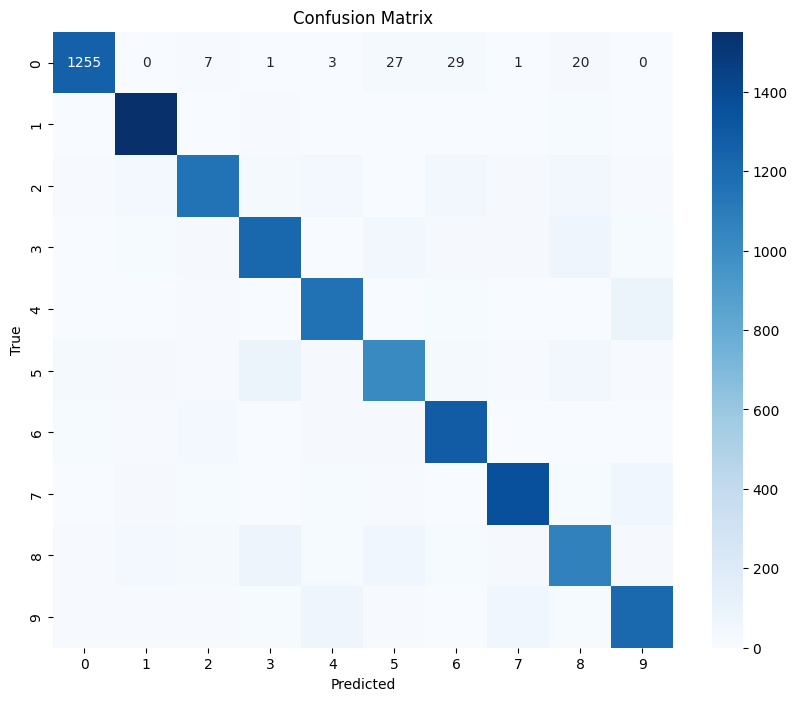

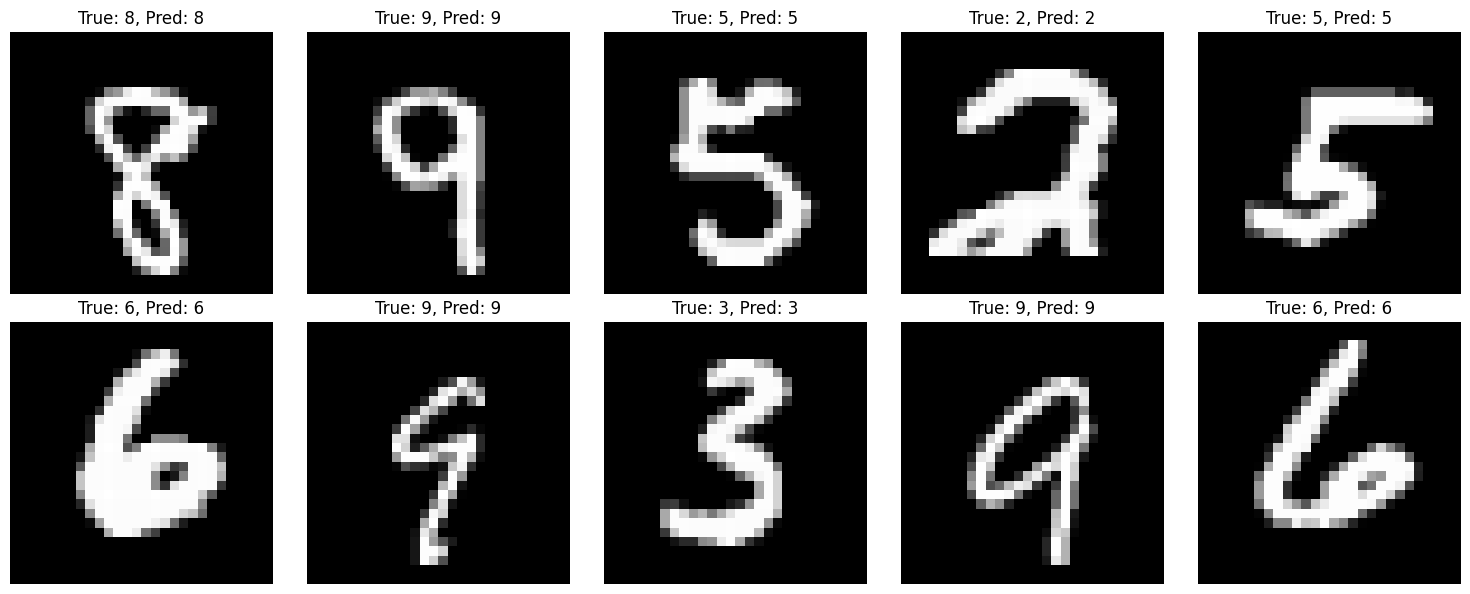


Weight distributions:


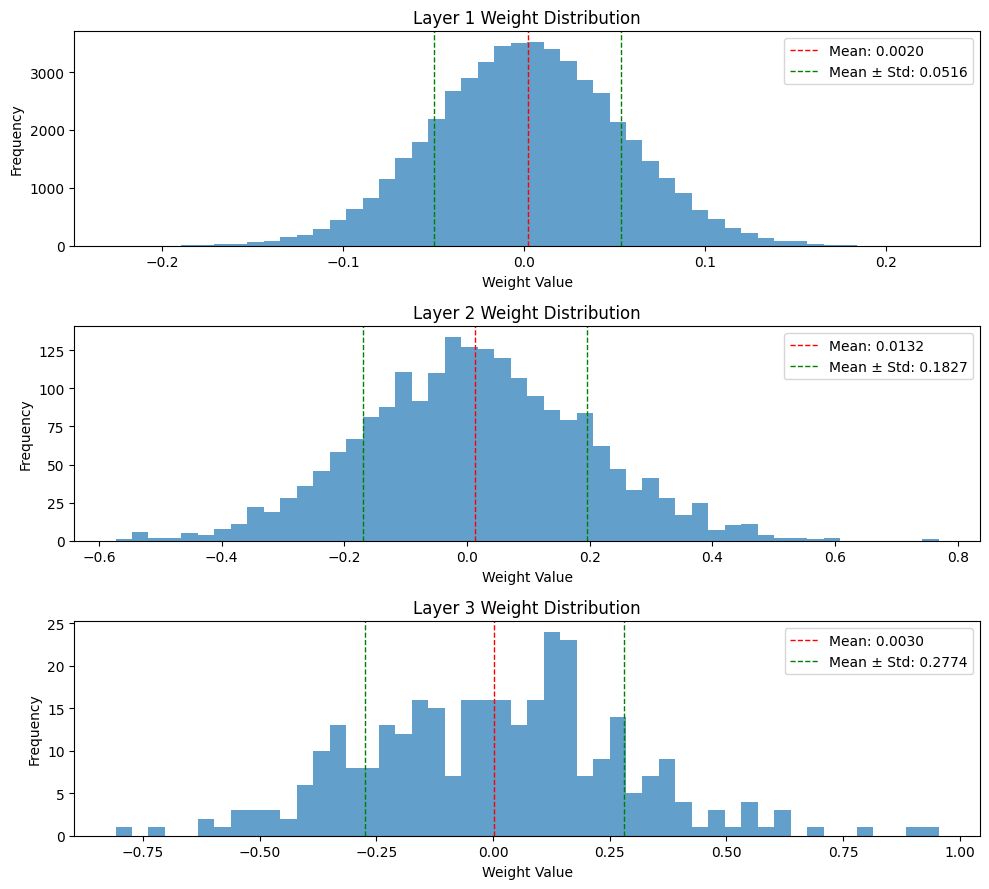


Weight Initialization Comparison Results:
  initialization  accuracy  final_train_loss  final_val_loss  training_time
0           Zero  0.114286          2.301500        2.301278      23.372697
1        Uniform  0.637429          1.491394        1.430305      22.263349
2         Normal  0.776071          0.736490        0.715627      22.204436
3         Xavier  0.870286          0.514117        0.502029      22.111952
4             He  0.877929          0.466123        0.455599      22.420305


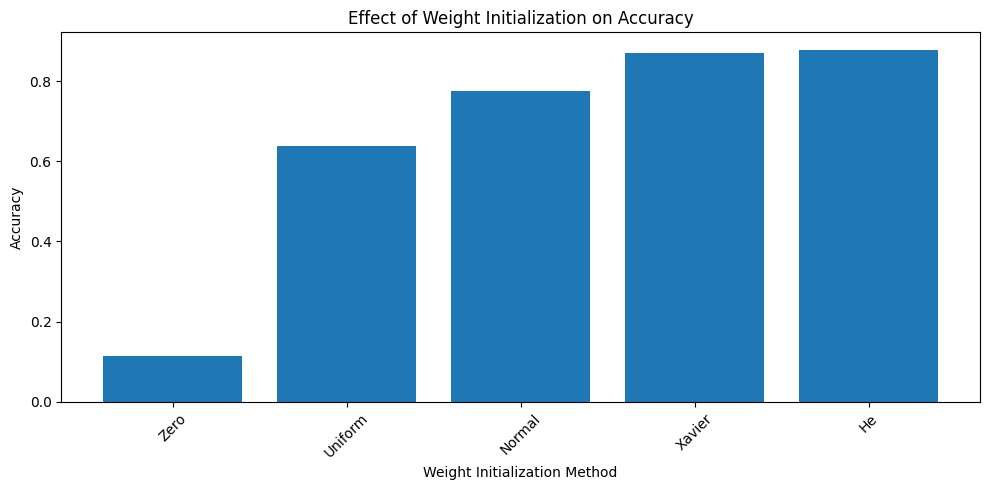

In [16]:
init_results = []

for init in weight_inits:
    print(f"\nTraining model with weight initialization: {init['name']}")
    
    # Create the model
    model = FFNN_model.FeedforwardNeuralNetwork(
        input_size=X_train.shape[1],
        layer_sizes=base_architecture['layers'],
        activations=base_architecture['activations'],
        loss=base_architecture['loss'],
        weight_init=init['method'],
        weight_init_params=init['params']
    )
    
    # Train the model
    start_time = time.time()
    history = model.train(
        X_train=X_train,
        y_train=y_train_onehot,
        X_val=X_test,
        y_val=y_test_onehot,
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        learning_rate=params['learning_rate'],
        verbose=1
    )
    training_time = time.time() - start_time
    
    # Plot training history
    plot_history(history)
    
    # Evaluate model
    print(f"\nEvaluating model with {init['name']} initialization...")
    accuracy, _ = evaluate_model(model, X_test, y_test_onehot, y_test)
    
    # Plot weight distributions for initial and final weights
    print("\nWeight distributions:")
    model.plot_weight_distribution(list(range(len(base_architecture['layers']))))
    plt.show()
    
    # Store results
    init_results.append({
        'initialization': init['name'],
        'accuracy': accuracy,
        'training_time': training_time,
        'final_train_loss': history['train_loss'][-1],
        'final_val_loss': history['val_loss'][-1] if 'val_loss' in history else None
    })

# Display initialization results
print("\nWeight Initialization Comparison Results:")
init_df = pd.DataFrame(init_results)
print(init_df[['initialization', 'accuracy', 'final_train_loss', 'final_val_loss', 'training_time']])

# Plot comparative results
plt.figure(figsize=(10, 5))
plt.bar([r['initialization'] for r in init_results], [r['accuracy'] for r in init_results])
plt.xlabel('Weight Initialization Method')
plt.ylabel('Accuracy')
plt.title('Effect of Weight Initialization on Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Experiment 5 : Comparison with sklearn MLP

In [17]:
base_architecture = {
    'layers': [64, 32, 10],
    'activations': ['relu', 'relu', 'softmax'],
    'loss': 'categorical_cross_entropy'
}

# Parameters for training
params = {
    'epochs': 30,
    'batch_size': 32,
    'learning_rate': 0.1
}


Training custom FFNN model...
Epoch 1/30 [3.3%] - train_loss: 1.1301 - val_loss: 0.5512
Epoch 2/30 [6.7%] - train_loss: 0.4540 - val_loss: 0.3912
Epoch 3/30 [10.0%] - train_loss: 0.3599 - val_loss: 0.3362
Epoch 4/30 [13.3%] - train_loss: 0.3176 - val_loss: 0.3050
Epoch 5/30 [16.7%] - train_loss: 0.2904 - val_loss: 0.2857
Epoch 6/30 [20.0%] - train_loss: 0.2699 - val_loss: 0.2678
Epoch 7/30 [23.3%] - train_loss: 0.2536 - val_loss: 0.2567
Epoch 8/30 [26.7%] - train_loss: 0.2400 - val_loss: 0.2434
Epoch 9/30 [30.0%] - train_loss: 0.2282 - val_loss: 0.2328
Epoch 10/30 [33.3%] - train_loss: 0.2176 - val_loss: 0.2252
Epoch 11/30 [36.7%] - train_loss: 0.2078 - val_loss: 0.2170
Epoch 12/30 [40.0%] - train_loss: 0.1995 - val_loss: 0.2097
Epoch 13/30 [43.3%] - train_loss: 0.1914 - val_loss: 0.2029
Epoch 14/30 [46.7%] - train_loss: 0.1844 - val_loss: 0.1964
Epoch 15/30 [50.0%] - train_loss: 0.1775 - val_loss: 0.1914
Epoch 16/30 [53.3%] - train_loss: 0.1713 - val_loss: 0.1860
Epoch 17/30 [56.7%] 

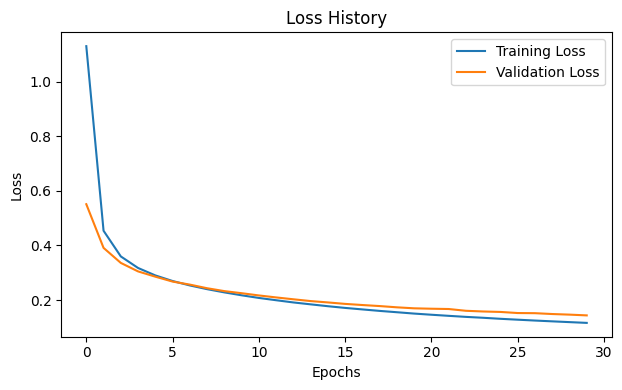


Evaluating custom FFNN model...
Accuracy: 0.9581
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1343
           1       0.97      0.98      0.97      1600
           2       0.96      0.95      0.96      1380
           3       0.95      0.95      0.95      1433
           4       0.96      0.96      0.96      1295
           5       0.95      0.95      0.95      1273
           6       0.97      0.97      0.97      1396
           7       0.95      0.96      0.96      1503
           8       0.94      0.94      0.94      1357
           9       0.95      0.94      0.95      1420

    accuracy                           0.96     14000
   macro avg       0.96      0.96      0.96     14000
weighted avg       0.96      0.96      0.96     14000



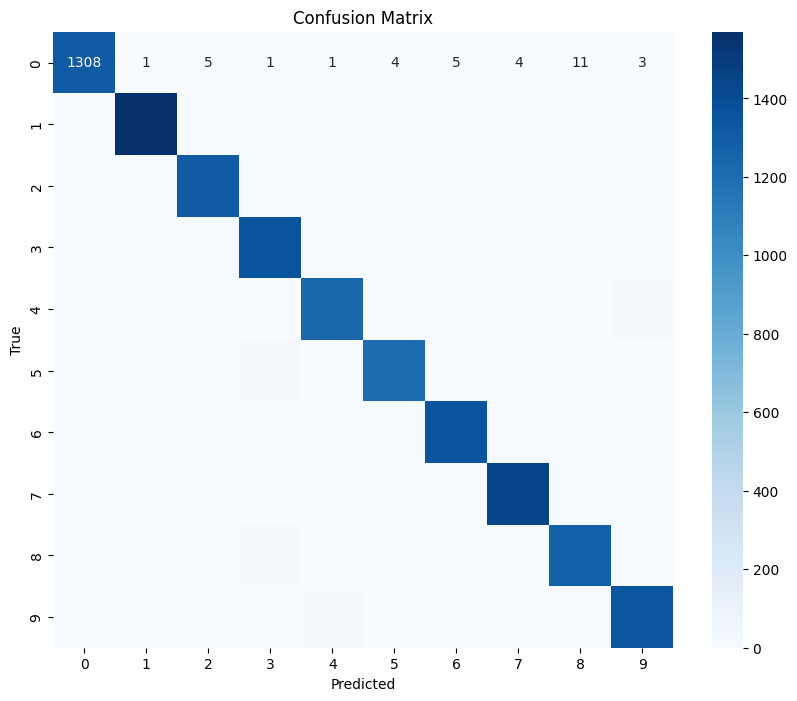

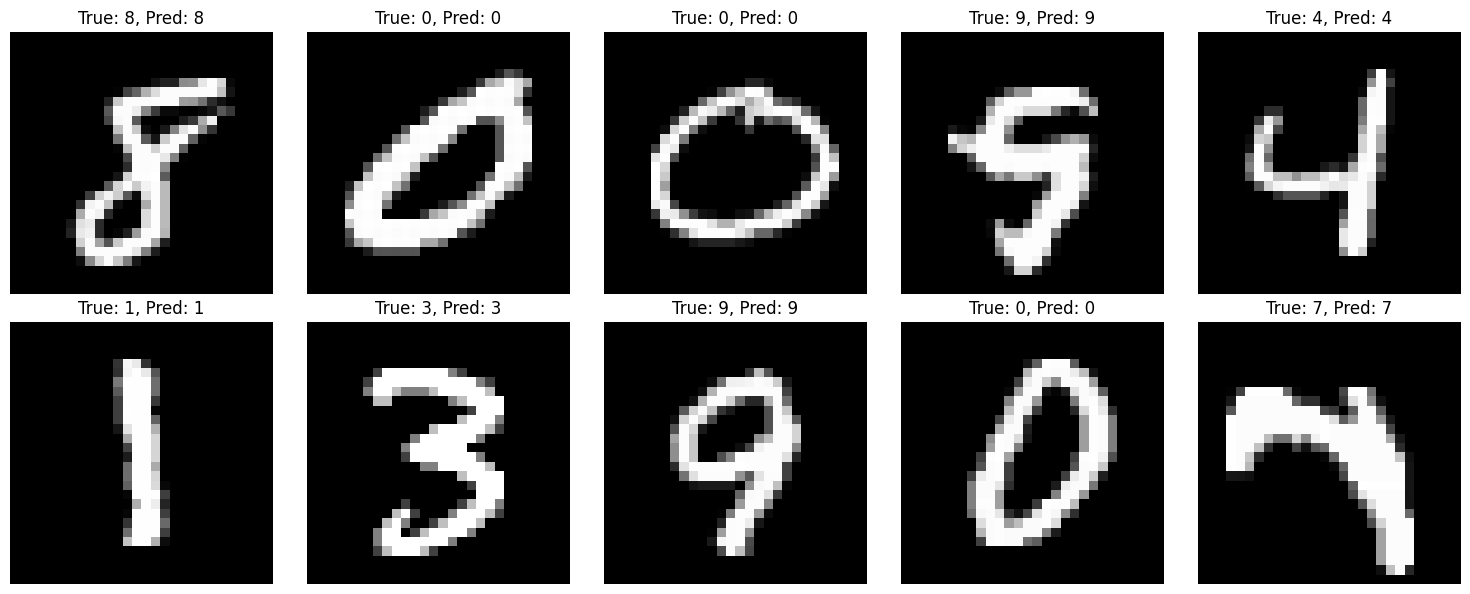


Training sklearn MLP model...
Iteration 1, loss = 0.34674316
Iteration 2, loss = 0.22350388
Iteration 3, loss = 0.21041965
Iteration 4, loss = 0.19229737
Iteration 5, loss = 0.18175761
Iteration 6, loss = 0.18888688
Iteration 7, loss = 0.17149717
Iteration 8, loss = 0.17369688
Iteration 9, loss = 0.16889438
Iteration 10, loss = 0.16916481
Iteration 11, loss = 0.17908212
Iteration 12, loss = 0.16705785
Iteration 13, loss = 0.16607019
Iteration 14, loss = 0.18737969
Iteration 15, loss = 0.20943558
Iteration 16, loss = 0.27201150
Iteration 17, loss = 0.26711886
Iteration 18, loss = 0.22776441
Iteration 19, loss = 0.91600923
Iteration 20, loss = 2.33762124
Iteration 21, loss = 2.33732296
Iteration 22, loss = 2.33684374
Iteration 23, loss = 2.33692162
Iteration 24, loss = 2.33645571
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.

Evaluating sklearn MLP model...
Sklearn MLP Accuracy: 0.1024
Classification Report for sklearn MLP:
              preci

c:\Users\A C E R\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\A C E R\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\A C E R\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

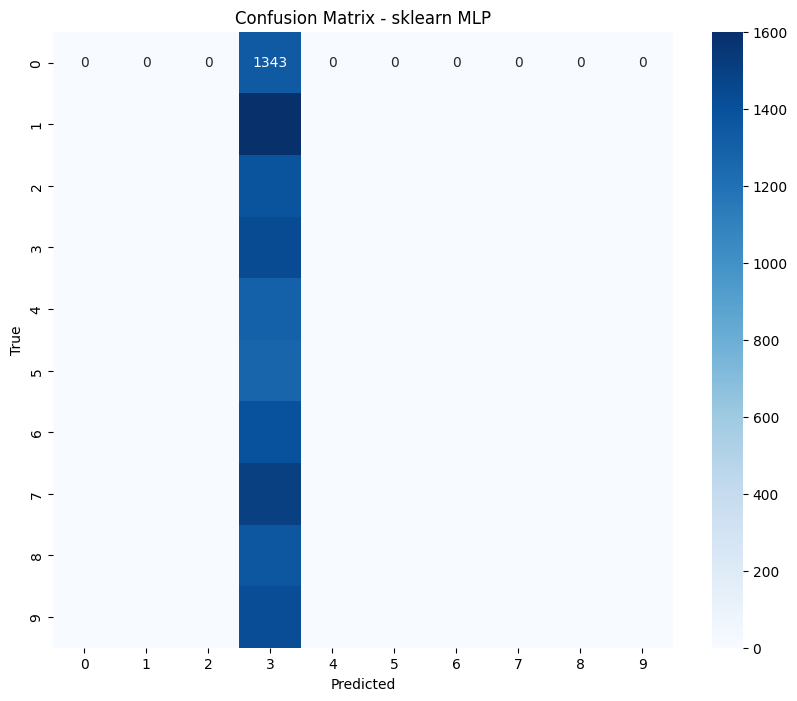


Model Comparison Results:
         model  accuracy  training_time
0  Custom FFNN  0.958071      47.121578
1  sklearn MLP  0.102357      39.484679


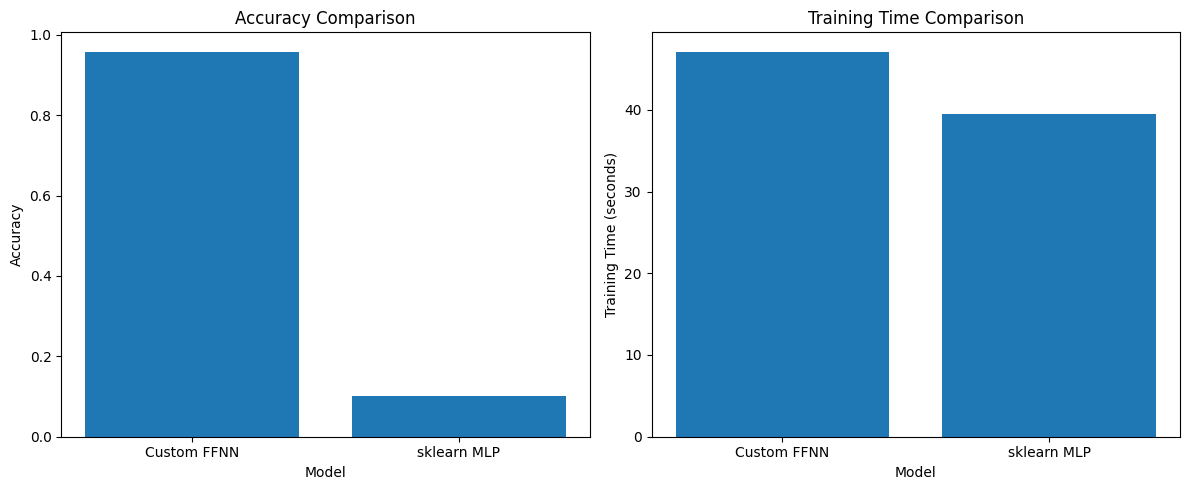

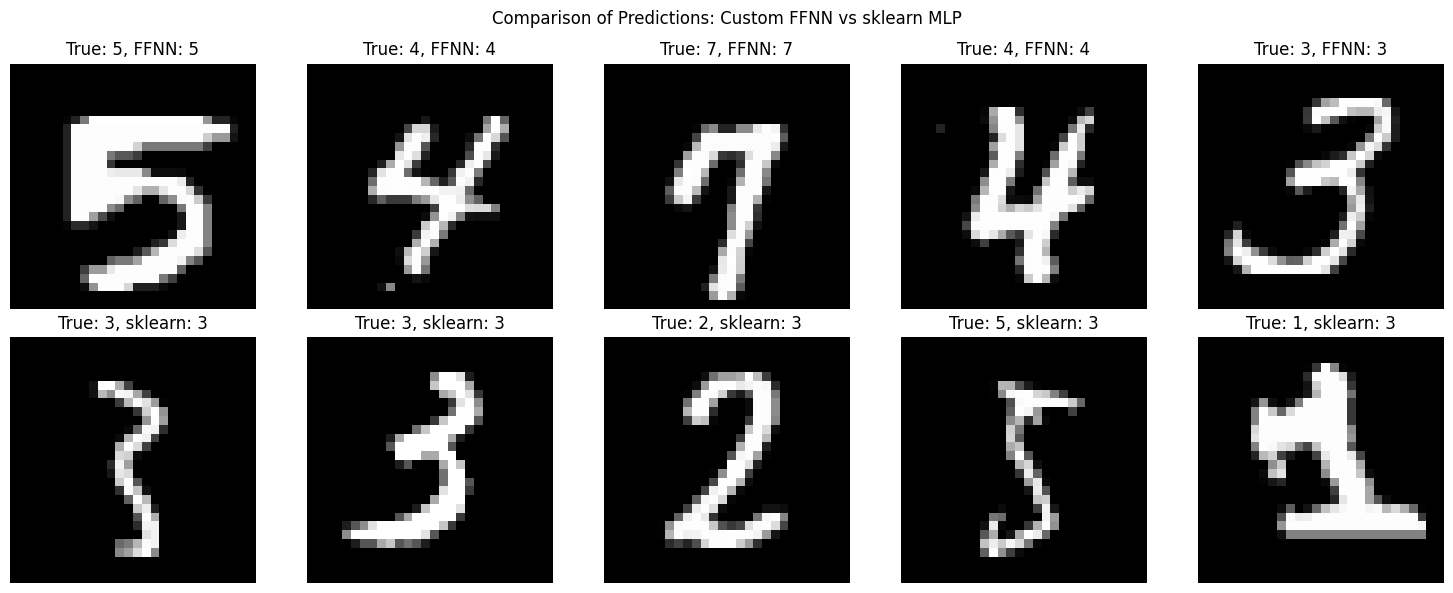

In [19]:
sklearn_mlp = MLPClassifier(
    hidden_layer_sizes=(64, 32),  # Not including the output layer
    activation='relu',
    solver='sgd',
    learning_rate_init=params['learning_rate'],
    batch_size=params['batch_size'],
    max_iter=params['epochs'],
    random_state=42,
    verbose=True
)

custom_model = FFNN_model.FeedforwardNeuralNetwork(
    input_size=X_train.shape[1],
    layer_sizes=base_architecture['layers'],
    activations=base_architecture['activations'],
    loss=base_architecture['loss']
)

comparison_results = []

# Train and evaluate custom model
print("\nTraining custom FFNN model...")
start_time = time.time()
custom_history = custom_model.train(
    X_train=X_train,
    y_train=y_train_onehot,
    X_val=X_test,
    y_val=y_test_onehot,
    epochs=params['epochs'],
    batch_size=params['batch_size'],
    learning_rate=params['learning_rate'],
    verbose=1
)
custom_training_time = time.time() - start_time

plot_history(custom_history)

print("\nEvaluating custom FFNN model...")
custom_accuracy, custom_preds = evaluate_model(custom_model, X_test, y_test_onehot, y_test)

# Train sklearn model (with one-hot encoded or integer labels based on the model requirement)
print("\nTraining sklearn MLP model...")
start_time = time.time()
# Convert one-hot encoded targets back to integers for sklearn
y_train_int = np.argmax(y_train_onehot, axis=1)
sklearn_mlp.fit(X_train, y_train_int)
sklearn_training_time = time.time() - start_time


print("\nEvaluating sklearn MLP model...")
sklearn_preds = sklearn_mlp.predict(X_test)
sklearn_probs = sklearn_mlp.predict_proba(X_test)
sklearn_accuracy = accuracy_score(np.argmax(y_test_onehot, axis=1), sklearn_preds)
print(f"Sklearn MLP Accuracy: {sklearn_accuracy:.4f}")


print("Classification Report for sklearn MLP:")
print(classification_report(np.argmax(y_test_onehot, axis=1), sklearn_preds))

# Plot confusion matrix for sklearn
plt.figure(figsize=(10, 8))
cm = confusion_matrix(np.argmax(y_test_onehot, axis=1), sklearn_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - sklearn MLP')
plt.show()

# Compare both models
comparison_results = [
    {
        'model': 'Custom FFNN',
        'accuracy': custom_accuracy,
        'training_time': custom_training_time,
        'final_train_loss': custom_history['train_loss'][-1],
        'final_val_loss': custom_history['val_loss'][-1] if 'val_loss' in custom_history else None
    },
    {
        'model': 'sklearn MLP',
        'accuracy': sklearn_accuracy,
        'training_time': sklearn_training_time,
        'final_train_loss': sklearn_mlp.loss_,
        'final_val_loss': None  # sklearn doesn't provide validation loss
    }
]

# Display comparison results
print("\nModel Comparison Results:")
comparison_df = pd.DataFrame(comparison_results)
print(comparison_df[['model', 'accuracy', 'training_time']])

# Plot comparative results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.bar([r['model'] for r in comparison_results], [r['accuracy'] for r in comparison_results])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')

plt.subplot(1, 2, 2)
plt.bar([r['model'] for r in comparison_results], [r['training_time'] for r in comparison_results])
plt.xlabel('Model')
plt.ylabel('Training Time (seconds)')
plt.title('Training Time Comparison')

plt.tight_layout()
plt.show()

# Visualize a few example predictions from both models
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Comparison of Predictions: Custom FFNN vs sklearn MLP')

for i, ax in enumerate(axes[0]):
    idx = np.random.randint(0, len(X_test))
    img = X_test[idx].reshape(28, 28)
    ax.imshow(img, cmap='gray')
    true_label = np.argmax(y_test_onehot[idx])
    custom_pred = np.argmax(custom_model.predict(X_test[idx:idx+1]), axis=1)[0]
    ax.set_title(f"True: {true_label}, FFNN: {custom_pred}")
    ax.axis('off')

for i, ax in enumerate(axes[1]):
    idx = np.random.randint(0, len(X_test))
    img = X_test[idx].reshape(28, 28)
    ax.imshow(img, cmap='gray')
    true_label = np.argmax(y_test_onehot[idx])
    sklearn_pred = sklearn_mlp.predict(X_test[idx:idx+1])[0]
    ax.set_title(f"True: {true_label}, sklearn: {sklearn_pred}")
    ax.axis('off')

plt.tight_layout()
plt.show()

## Bonus Experiment 1: Effect of Regularization (L1 and L2)

In [20]:
regularizations = [
    {
        'name': 'No Regularization',
        'l1_lambda': 0.0,
        'l2_lambda': 0.0
    },
    {
        'name': 'L1 Regularization',
        'l1_lambda': 0.001,
        'l2_lambda': 0.0
    },
    {
        'name': 'L2 Regularization',
        'l1_lambda': 0.0,
        'l2_lambda': 0.001
    }
]

base_architecture = {
    'layers': [64, 32, 10],
    'activations': ['relu', 'relu', 'softmax'],
    'loss': 'categorical_cross_entropy'
}


params = {
    'epochs': 15,
    'batch_size': 32,
    'learning_rate': 0.01
}


Training model with regularization: No Regularization
Epoch 1/15 [6.7%] - train_loss: 2.2452 - val_loss: 2.1119
Epoch 2/15 [13.3%] - train_loss: 1.9933 - val_loss: 1.8561
Epoch 3/15 [20.0%] - train_loss: 1.7219 - val_loss: 1.5678
Epoch 4/15 [26.7%] - train_loss: 1.4364 - val_loss: 1.2986
Epoch 5/15 [33.3%] - train_loss: 1.1919 - val_loss: 1.0831
Epoch 6/15 [40.0%] - train_loss: 1.0031 - val_loss: 0.9224
Epoch 7/15 [46.7%] - train_loss: 0.8647 - val_loss: 0.8057
Epoch 8/15 [53.3%] - train_loss: 0.7641 - val_loss: 0.7204
Epoch 9/15 [60.0%] - train_loss: 0.6898 - val_loss: 0.6562
Epoch 10/15 [66.7%] - train_loss: 0.6333 - val_loss: 0.6071
Epoch 11/15 [73.3%] - train_loss: 0.5895 - val_loss: 0.5684
Epoch 12/15 [80.0%] - train_loss: 0.5546 - val_loss: 0.5373
Epoch 13/15 [86.7%] - train_loss: 0.5264 - val_loss: 0.5120
Epoch 14/15 [93.3%] - train_loss: 0.5030 - val_loss: 0.4909
Epoch 15/15 [100.0%] - train_loss: 0.4832 - val_loss: 0.4730


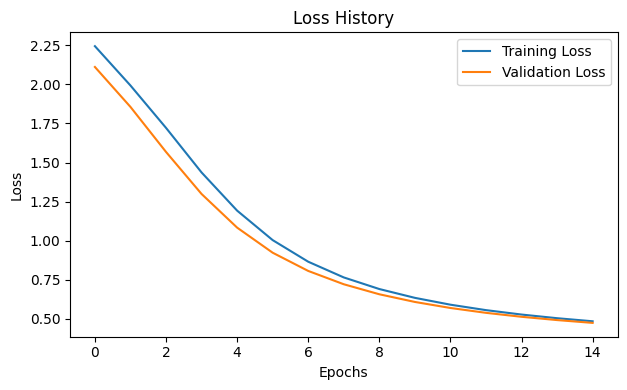


Evaluating model with No Regularization 
Accuracy: 0.8713
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1343
           1       0.90      0.97      0.93      1600
           2       0.87      0.81      0.84      1380
           3       0.85      0.84      0.84      1433
           4       0.84      0.87      0.86      1295
           5       0.83      0.79      0.81      1273
           6       0.89      0.92      0.90      1396
           7       0.91      0.90      0.90      1503
           8       0.84      0.81      0.82      1357
           9       0.83      0.85      0.84      1420

    accuracy                           0.87     14000
   macro avg       0.87      0.87      0.87     14000
weighted avg       0.87      0.87      0.87     14000



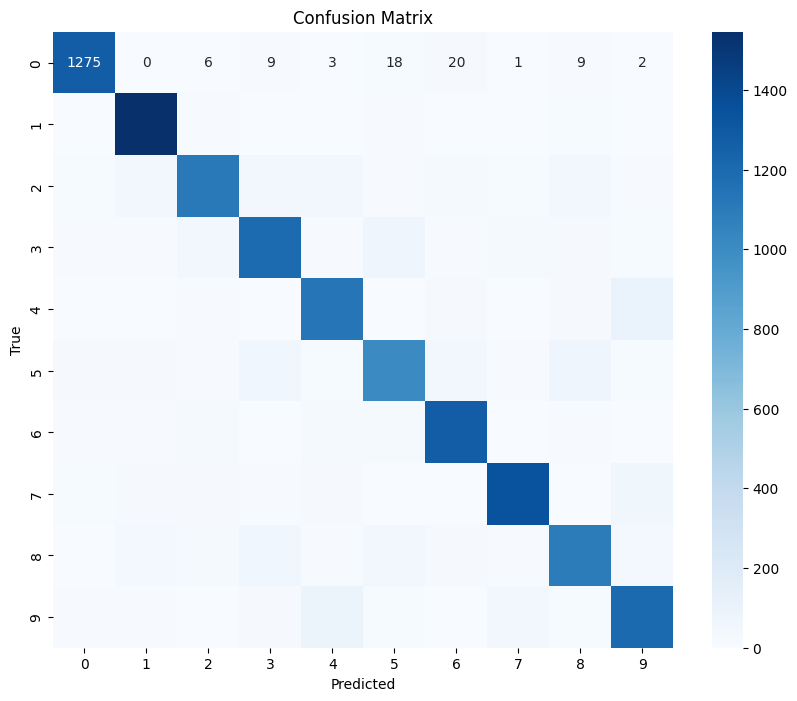

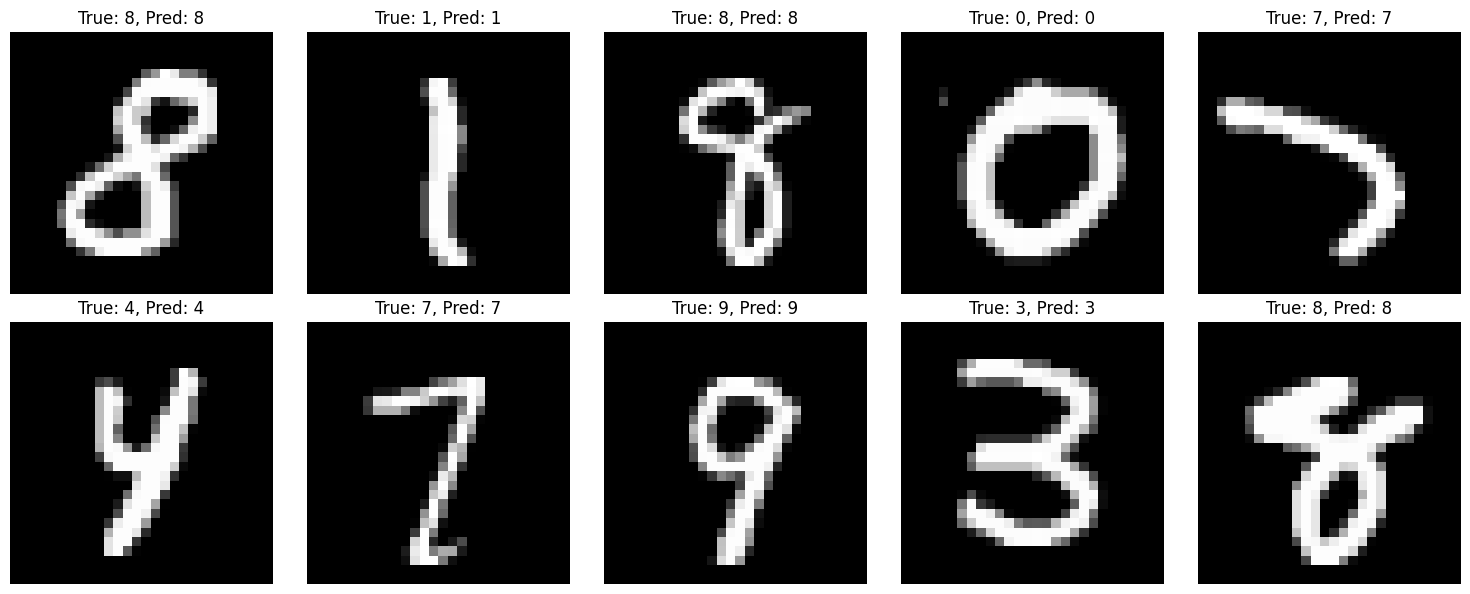


Weight distributions:


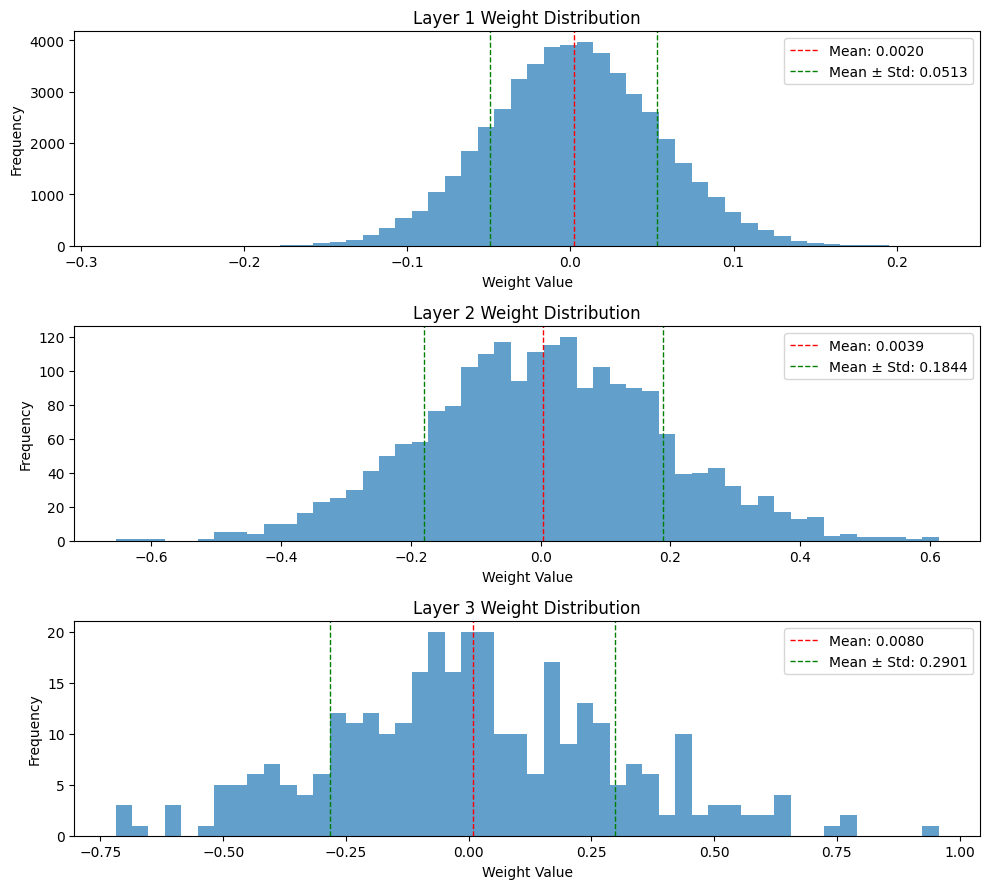


Gradient distributions:


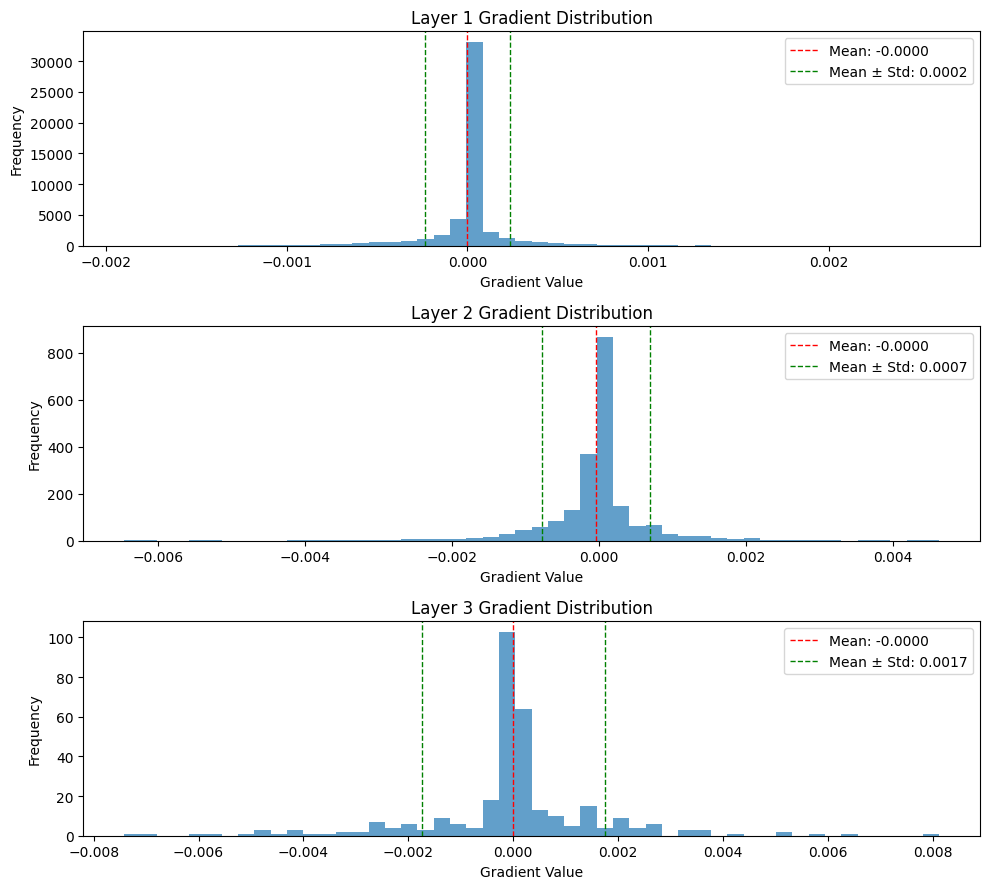


Training model with regularization: L1 Regularization
Epoch 1/15 [6.7%] - train_loss: 2.1249 - val_loss: 1.9022
Epoch 2/15 [13.3%] - train_loss: 1.6679 - val_loss: 1.4599
Epoch 3/15 [20.0%] - train_loss: 1.2827 - val_loss: 1.1370
Epoch 4/15 [26.7%] - train_loss: 1.0195 - val_loss: 0.9255
Epoch 5/15 [33.3%] - train_loss: 0.8497 - val_loss: 0.7885
Epoch 6/15 [40.0%] - train_loss: 0.7374 - val_loss: 0.6958
Epoch 7/15 [46.7%] - train_loss: 0.6592 - val_loss: 0.6293
Epoch 8/15 [53.3%] - train_loss: 0.6023 - val_loss: 0.5805
Epoch 9/15 [60.0%] - train_loss: 0.5594 - val_loss: 0.5429
Epoch 10/15 [66.7%] - train_loss: 0.5260 - val_loss: 0.5133
Epoch 11/15 [73.3%] - train_loss: 0.4994 - val_loss: 0.4894
Epoch 12/15 [80.0%] - train_loss: 0.4776 - val_loss: 0.4699
Epoch 13/15 [86.7%] - train_loss: 0.4594 - val_loss: 0.4534
Epoch 14/15 [93.3%] - train_loss: 0.4439 - val_loss: 0.4392
Epoch 15/15 [100.0%] - train_loss: 0.4306 - val_loss: 0.4269


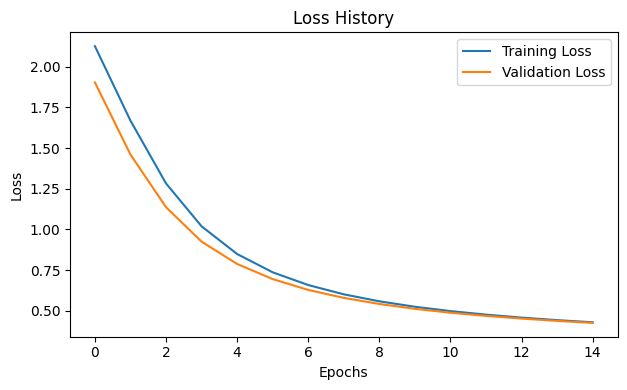


Evaluating model with L1 Regularization 
Accuracy: 0.8848
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.95      0.93      1343
           1       0.92      0.96      0.94      1600
           2       0.90      0.85      0.87      1380
           3       0.85      0.86      0.86      1433
           4       0.86      0.91      0.88      1295
           5       0.87      0.76      0.81      1273
           6       0.90      0.93      0.91      1396
           7       0.91      0.90      0.91      1503
           8       0.85      0.84      0.84      1357
           9       0.87      0.86      0.87      1420

    accuracy                           0.88     14000
   macro avg       0.88      0.88      0.88     14000
weighted avg       0.88      0.88      0.88     14000



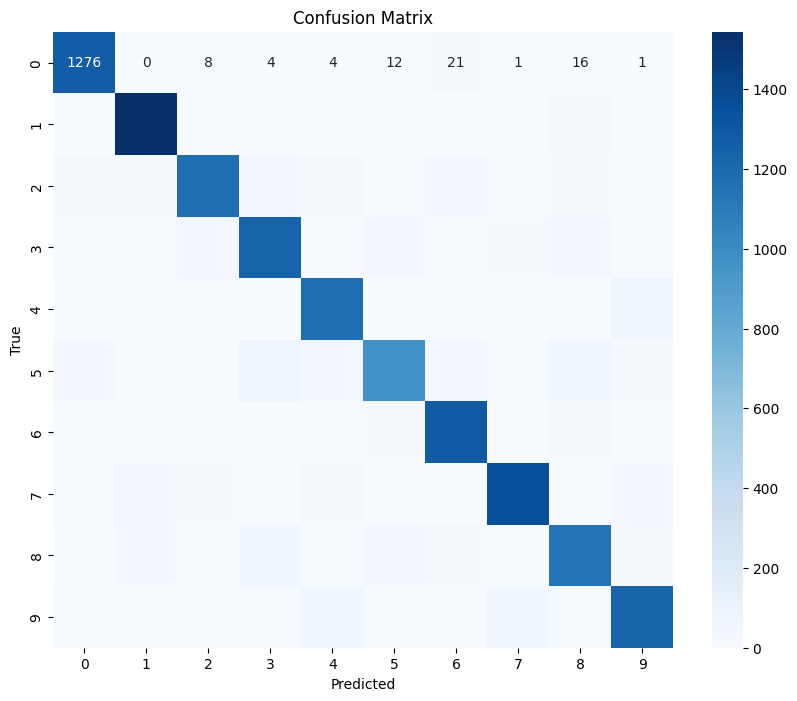

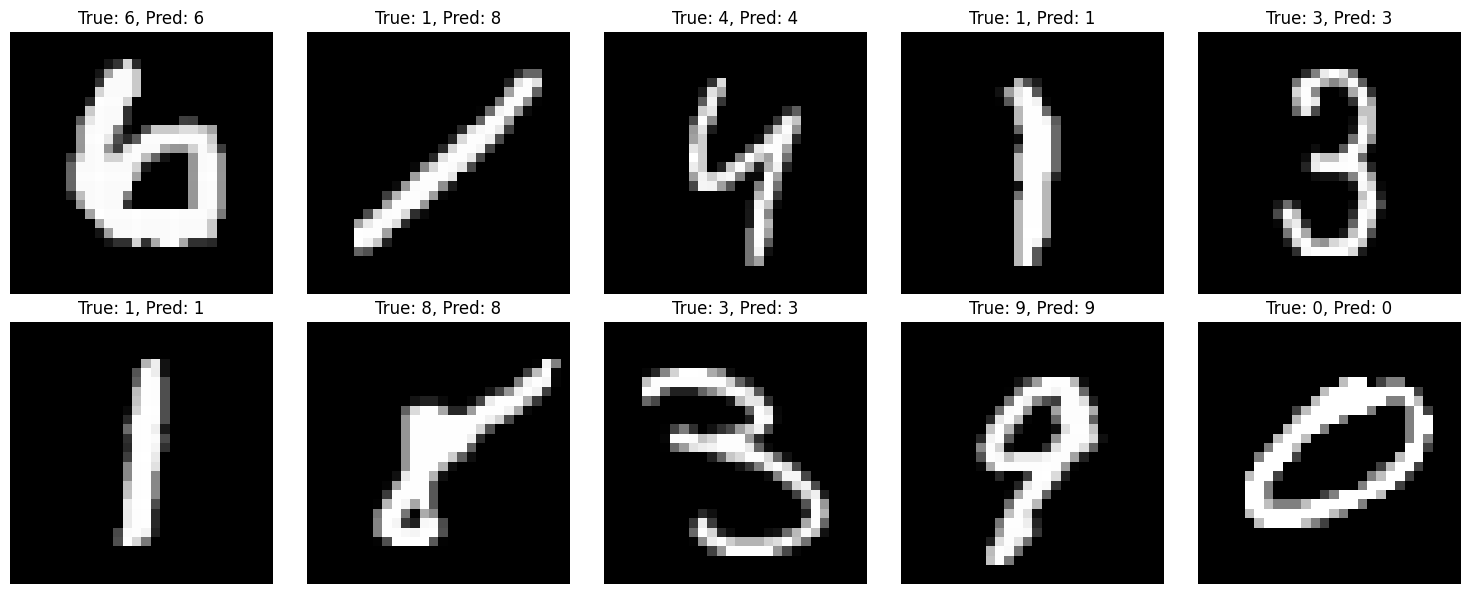


Weight distributions:


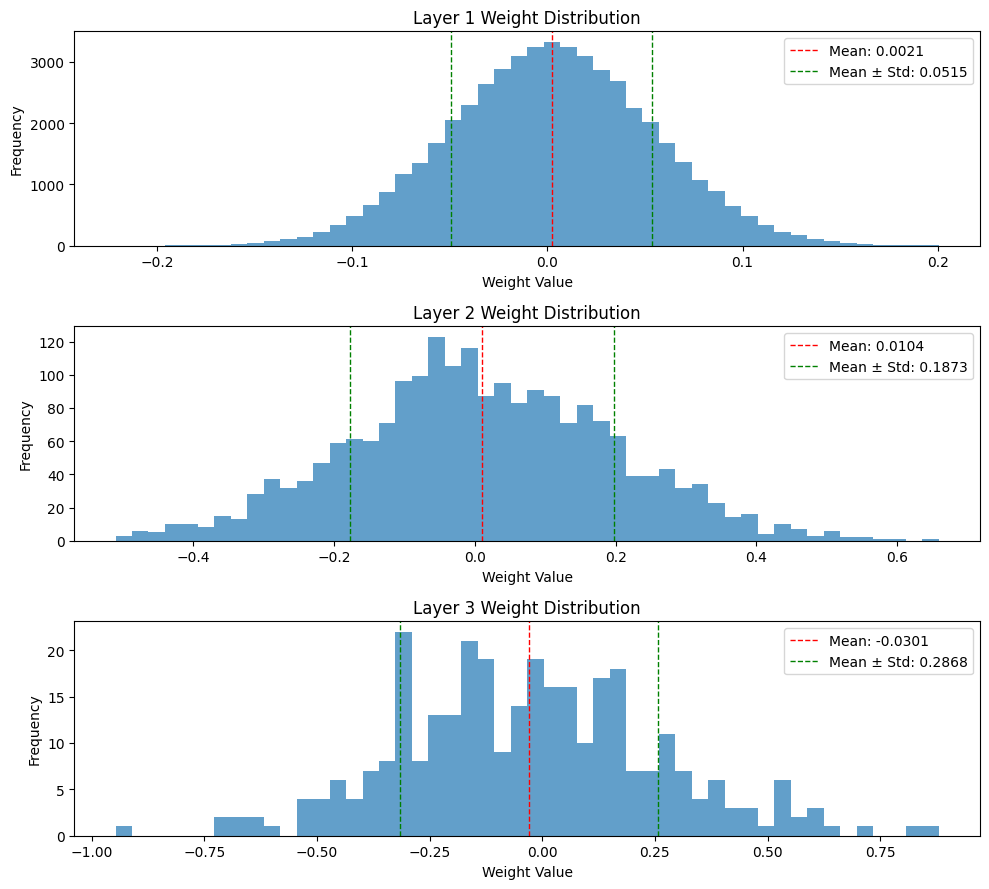


Gradient distributions:


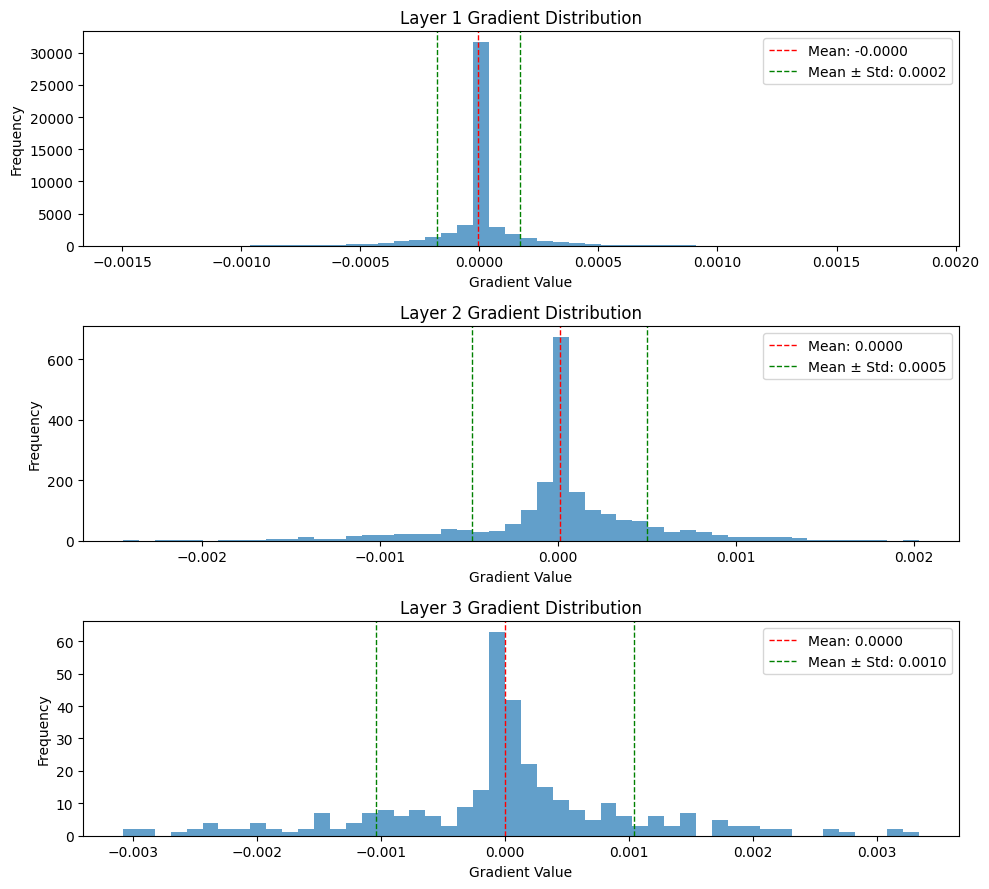


Training model with regularization: L2 Regularization
Epoch 1/15 [6.7%] - train_loss: 2.1893 - val_loss: 2.0275
Epoch 2/15 [13.3%] - train_loss: 1.8778 - val_loss: 1.7165
Epoch 3/15 [20.0%] - train_loss: 1.5579 - val_loss: 1.3940
Epoch 4/15 [26.7%] - train_loss: 1.2583 - val_loss: 1.1231
Epoch 5/15 [33.3%] - train_loss: 1.0240 - val_loss: 0.9267
Epoch 6/15 [40.0%] - train_loss: 0.8605 - val_loss: 0.7935
Epoch 7/15 [46.7%] - train_loss: 0.7496 - val_loss: 0.7029
Epoch 8/15 [53.3%] - train_loss: 0.6723 - val_loss: 0.6377
Epoch 9/15 [60.0%] - train_loss: 0.6160 - val_loss: 0.5891
Epoch 10/15 [66.7%] - train_loss: 0.5733 - val_loss: 0.5519
Epoch 11/15 [73.3%] - train_loss: 0.5398 - val_loss: 0.5223
Epoch 12/15 [80.0%] - train_loss: 0.5128 - val_loss: 0.4980
Epoch 13/15 [86.7%] - train_loss: 0.4905 - val_loss: 0.4778
Epoch 14/15 [93.3%] - train_loss: 0.4716 - val_loss: 0.4608
Epoch 15/15 [100.0%] - train_loss: 0.4556 - val_loss: 0.4459


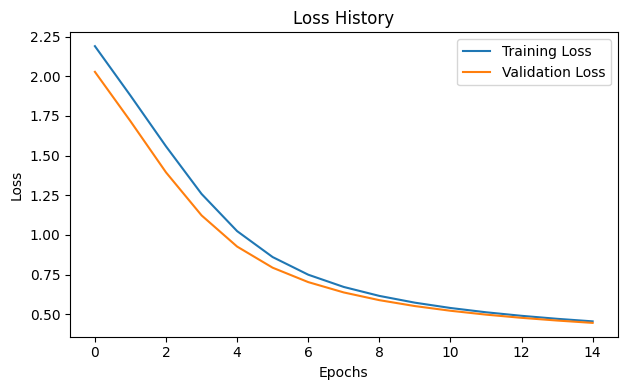


Evaluating model with L2 Regularization 
Accuracy: 0.8762
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1343
           1       0.91      0.96      0.94      1600
           2       0.87      0.85      0.86      1380
           3       0.85      0.84      0.84      1433
           4       0.87      0.88      0.87      1295
           5       0.85      0.79      0.82      1273
           6       0.91      0.92      0.91      1396
           7       0.89      0.89      0.89      1503
           8       0.83      0.83      0.83      1357
           9       0.84      0.84      0.84      1420

    accuracy                           0.88     14000
   macro avg       0.87      0.87      0.87     14000
weighted avg       0.88      0.88      0.88     14000



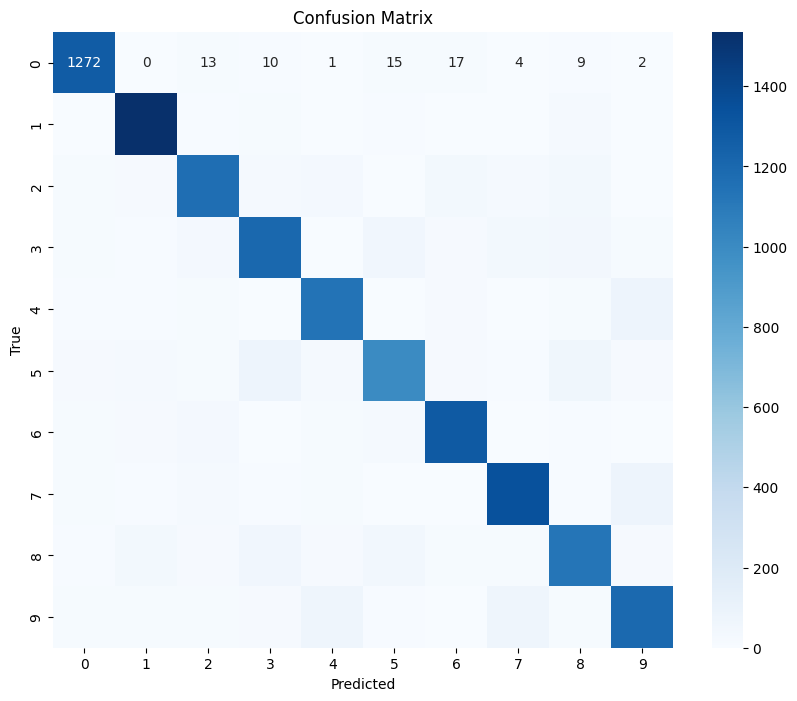

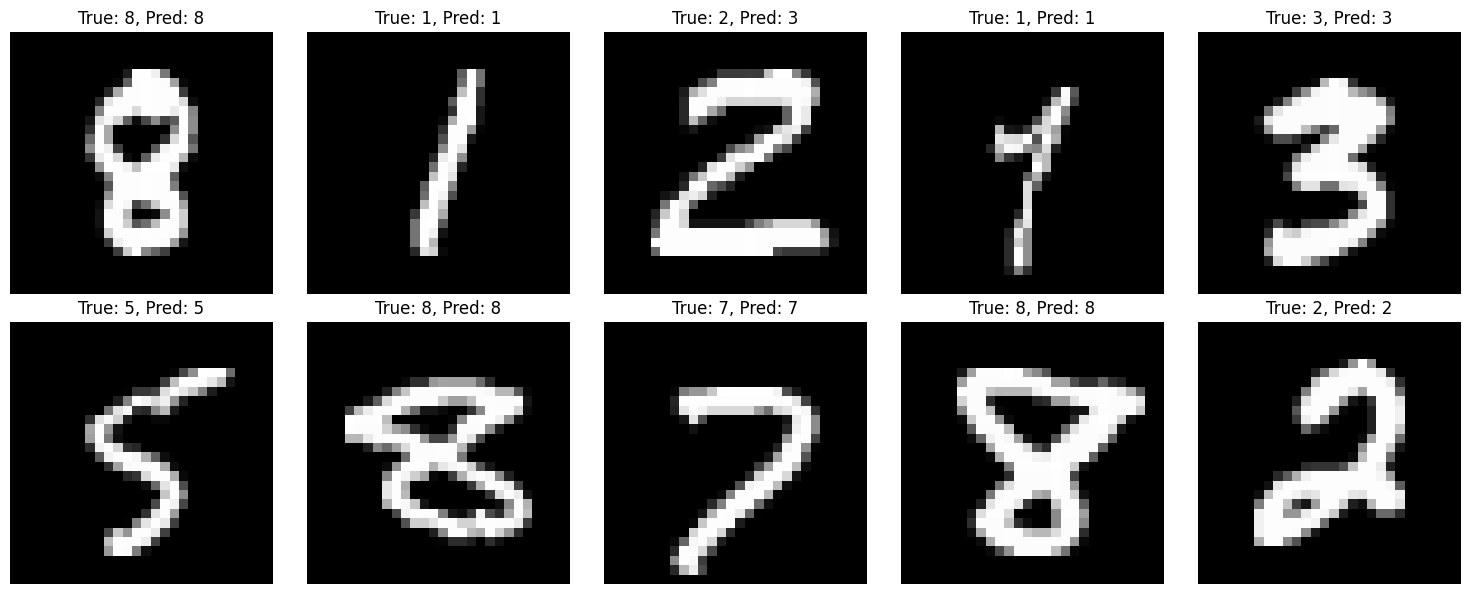


Weight distributions:


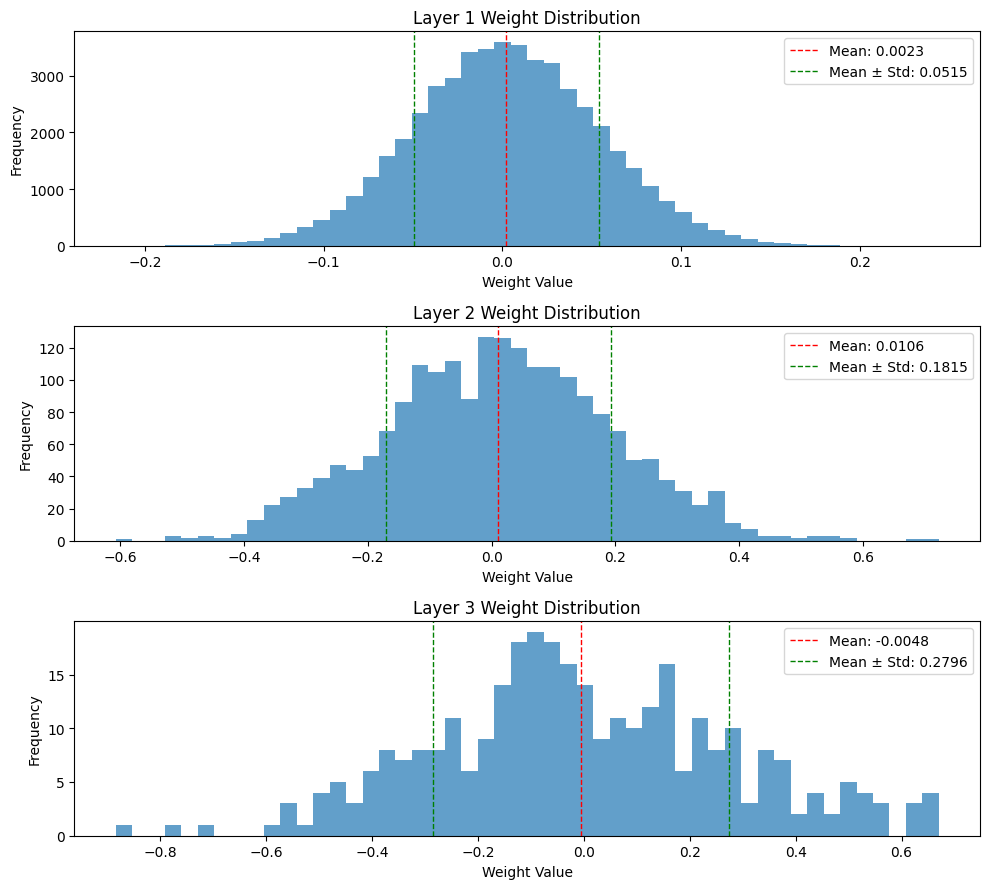


Gradient distributions:


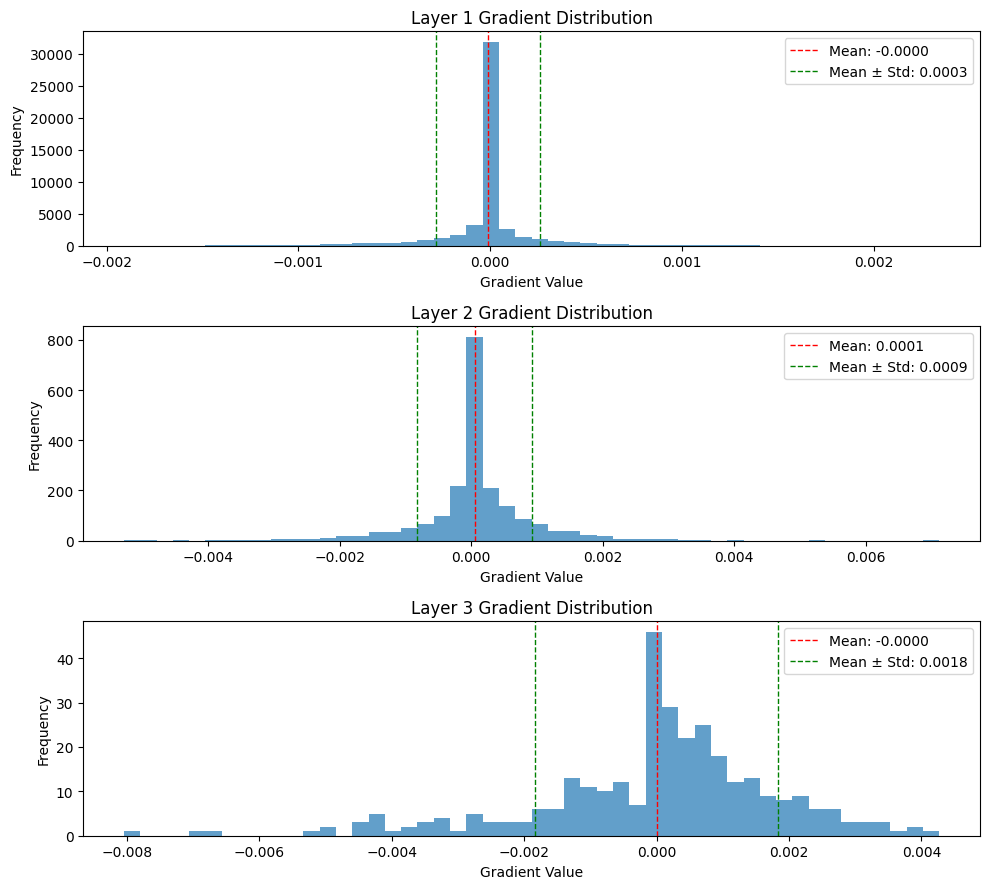


Regularization Comparison Results:
      regularization  accuracy  final_train_loss  final_val_loss  \
0  No Regularization  0.871286          0.483240        0.472955   
1  L1 Regularization  0.884786          0.430621        0.426949   
2  L2 Regularization  0.876214          0.455578        0.445925   

   training_time  
0      25.844643  
1      23.411364  
2      23.865172  


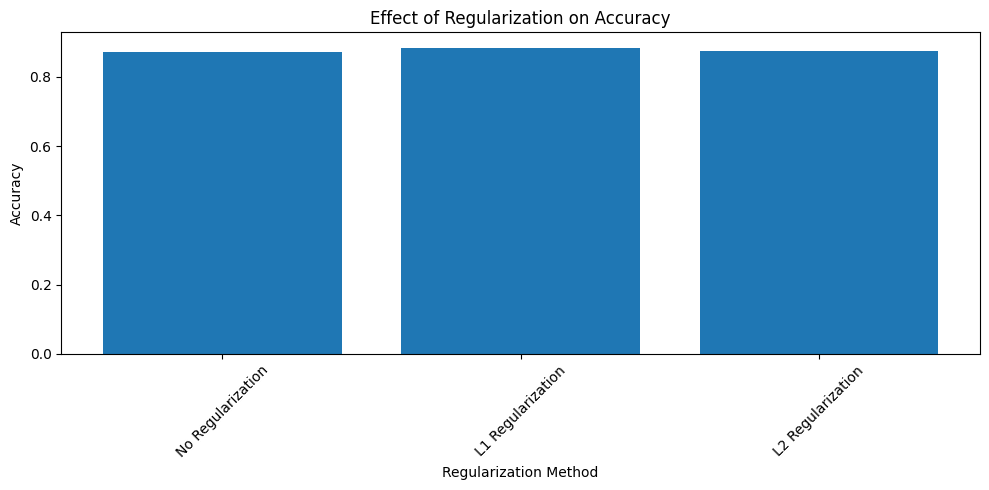

In [21]:
reg_results = []

for reg in regularizations:
    print(f"\nTraining model with regularization: {reg['name']}")
    
    
    model = FFNN_model.FeedforwardNeuralNetwork(
        input_size=X_train.shape[1],
        layer_sizes=base_architecture['layers'],
        activations=base_architecture['activations'],
        loss=base_architecture['loss']
    )
    
    
    start_time = time.time()
    history = model.train(
        X_train=X_train,
        y_train=y_train_onehot,
        X_val=X_test,
        y_val=y_test_onehot,
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        learning_rate=params['learning_rate'],
        verbose=1
    )
    training_time = time.time() - start_time

    plot_history(history)
    
    print(f"\nEvaluating model with {reg['name']} ")
    accuracy, _ = evaluate_model(model, X_test, y_test_onehot, y_test)

    print("\nWeight distributions:")
    model.plot_weight_distribution(list(range(len(base_architecture['layers']))))
    plt.show()
    
    print("\nGradient distributions:")
    model.plot_gradient_distribution(list(range(len(base_architecture['layers']))))
    plt.show()

    
    reg_results.append({
        'regularization': reg['name'],
        'accuracy': accuracy,
        'training_time': training_time,
        'final_train_loss': history['train_loss'][-1],
        'final_val_loss': history['val_loss'][-1] if 'val_loss' in history else None
    })


print("\nRegularization Comparison Results:")
reg_df = pd.DataFrame(reg_results)
print(reg_df[['regularization', 'accuracy', 'final_train_loss', 'final_val_loss', 'training_time']])


plt.figure(figsize=(10, 5))
plt.bar([r['regularization'] for r in reg_results], [r['accuracy'] for r in reg_results])
plt.xlabel('Regularization Method')
plt.ylabel('Accuracy')
plt.title('Effect of Regularization on Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Bonus Experiment 2: Additional Activation Functions

In [22]:
additional_activations = ['leaky_relu', 'elu']
standard_activations = ['relu']
all_activations = standard_activations + additional_activations

base_architecture = {
    'layers': [64, 32, 10],
    'loss': 'categorical_cross_entropy'
}

params = {
    'epochs': 15,
    'batch_size': 32,
    'learning_rate': 0.01
}


Training model with activation: relu
Epoch 1/15 [6.7%] - train_loss: 2.1415 - val_loss: 1.9495
Epoch 2/15 [13.3%] - train_loss: 1.7478 - val_loss: 1.5470
Epoch 3/15 [20.0%] - train_loss: 1.3748 - val_loss: 1.2119
Epoch 4/15 [26.7%] - train_loss: 1.0893 - val_loss: 0.9746
Epoch 5/15 [33.3%] - train_loss: 0.8953 - val_loss: 0.8193
Epoch 6/15 [40.0%] - train_loss: 0.7673 - val_loss: 0.7153
Epoch 7/15 [46.7%] - train_loss: 0.6800 - val_loss: 0.6429
Epoch 8/15 [53.3%] - train_loss: 0.6175 - val_loss: 0.5902
Epoch 9/15 [60.0%] - train_loss: 0.5709 - val_loss: 0.5500
Epoch 10/15 [66.7%] - train_loss: 0.5347 - val_loss: 0.5186
Epoch 11/15 [73.3%] - train_loss: 0.5061 - val_loss: 0.4928
Epoch 12/15 [80.0%] - train_loss: 0.4825 - val_loss: 0.4717
Epoch 13/15 [86.7%] - train_loss: 0.4629 - val_loss: 0.4542
Epoch 14/15 [93.3%] - train_loss: 0.4464 - val_loss: 0.4390
Epoch 15/15 [100.0%] - train_loss: 0.4321 - val_loss: 0.4261


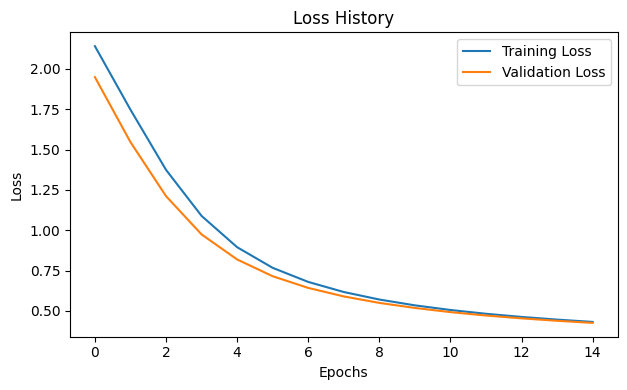


Evaluating model with relu activation...
Accuracy: 0.8860
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1343
           1       0.91      0.97      0.94      1600
           2       0.86      0.84      0.85      1380
           3       0.85      0.86      0.85      1433
           4       0.87      0.89      0.88      1295
           5       0.86      0.81      0.84      1273
           6       0.92      0.93      0.93      1396
           7       0.91      0.91      0.91      1503
           8       0.86      0.81      0.84      1357
           9       0.85      0.85      0.85      1420

    accuracy                           0.89     14000
   macro avg       0.88      0.88      0.88     14000
weighted avg       0.89      0.89      0.89     14000



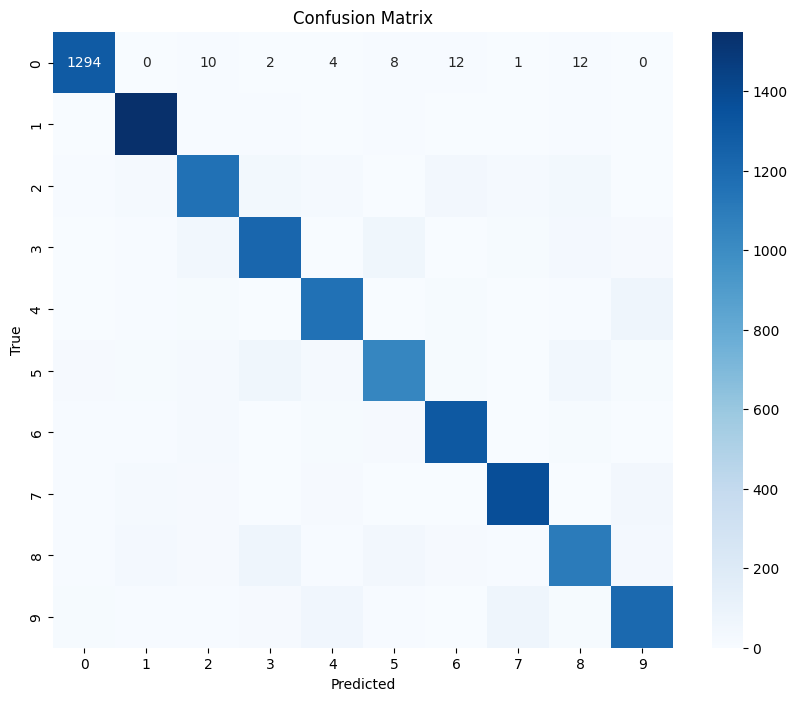

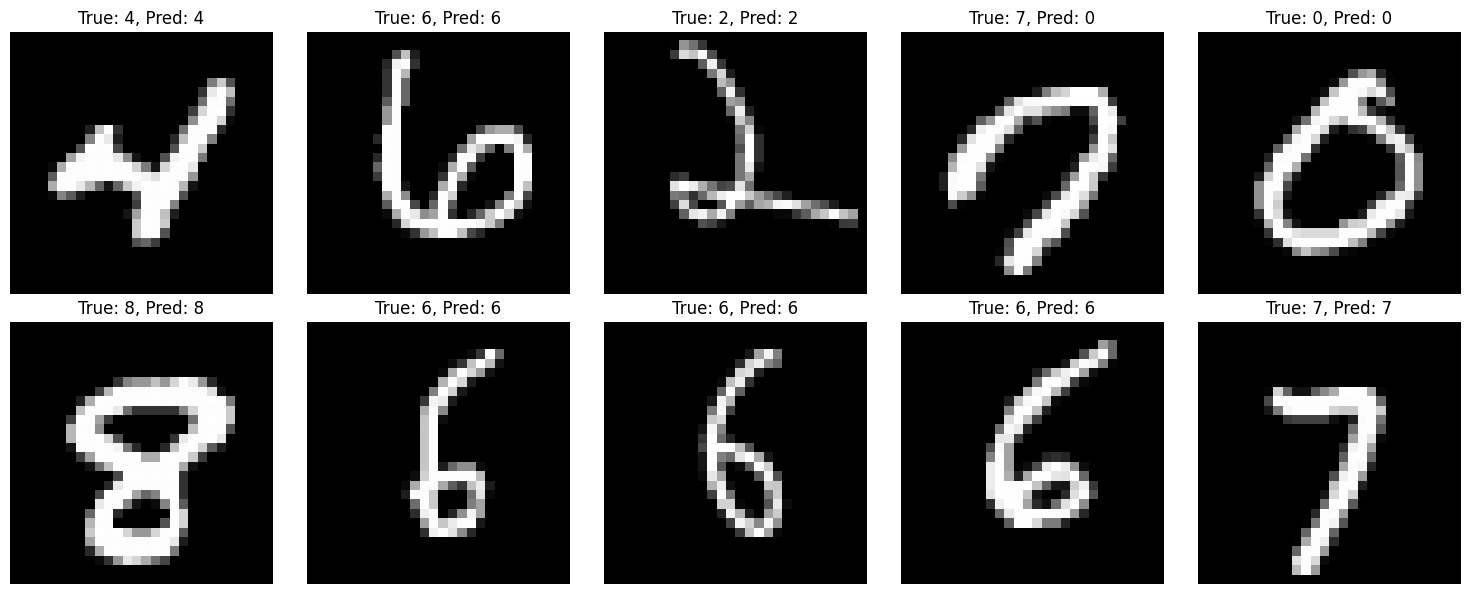


Weight distributions:


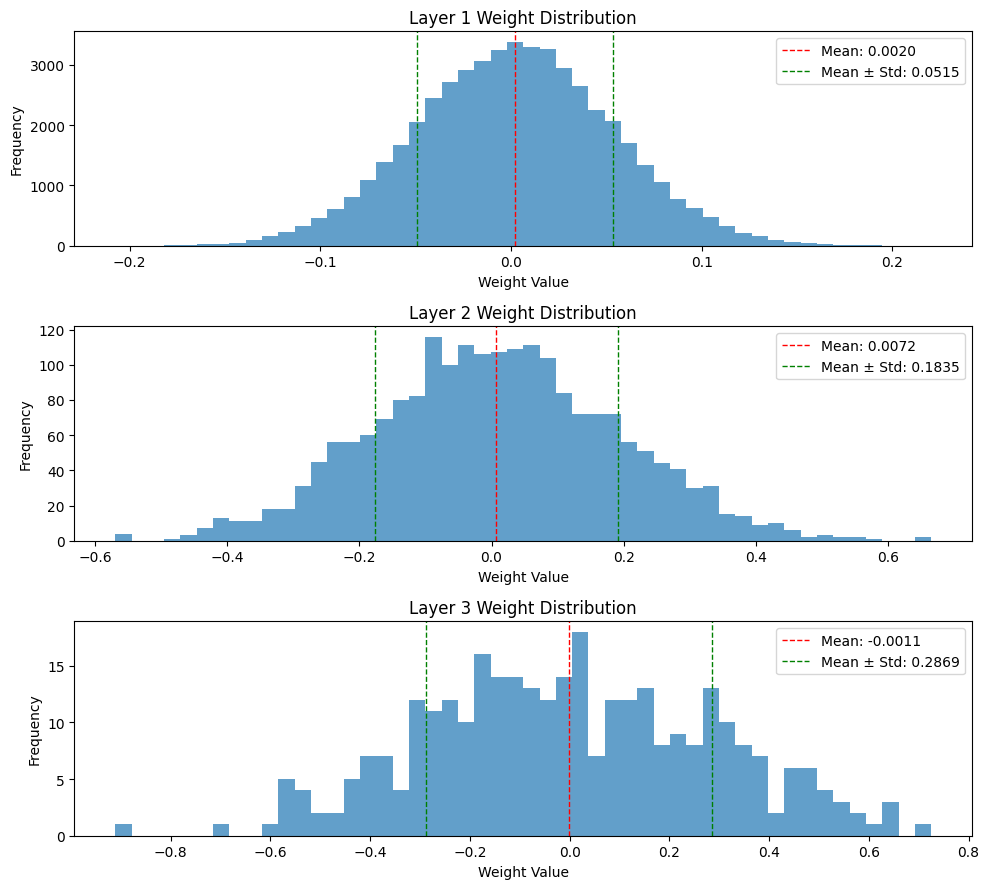


Gradient distributions:


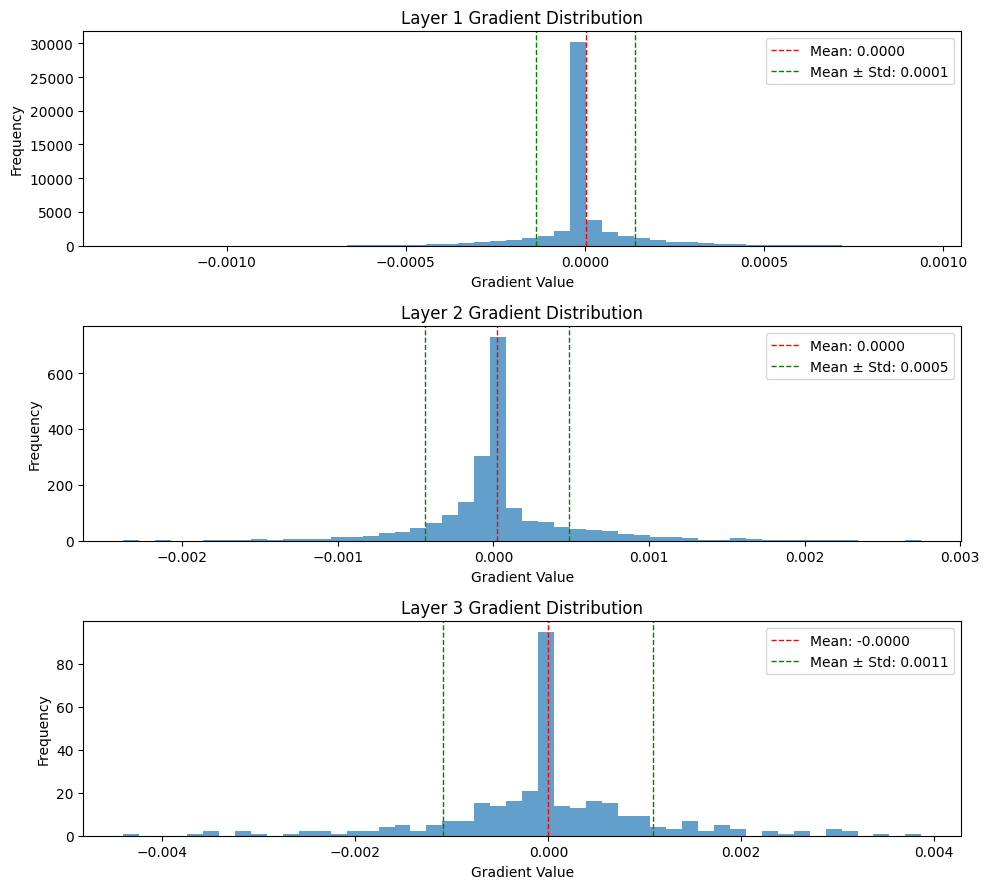


Training model with activation: leaky_relu
Epoch 1/15 [6.7%] - train_loss: 2.2011 - val_loss: 2.0497
Epoch 2/15 [13.3%] - train_loss: 1.9014 - val_loss: 1.7503
Epoch 3/15 [20.0%] - train_loss: 1.5968 - val_loss: 1.4533
Epoch 4/15 [26.7%] - train_loss: 1.3213 - val_loss: 1.2016
Epoch 5/15 [33.3%] - train_loss: 1.0985 - val_loss: 1.0062
Epoch 6/15 [40.0%] - train_loss: 0.9305 - val_loss: 0.8621
Epoch 7/15 [46.7%] - train_loss: 0.8068 - val_loss: 0.7563
Epoch 8/15 [53.3%] - train_loss: 0.7155 - val_loss: 0.6782
Epoch 9/15 [60.0%] - train_loss: 0.6472 - val_loss: 0.6192
Epoch 10/15 [66.7%] - train_loss: 0.5950 - val_loss: 0.5736
Epoch 11/15 [73.3%] - train_loss: 0.5543 - val_loss: 0.5381
Epoch 12/15 [80.0%] - train_loss: 0.5218 - val_loss: 0.5092
Epoch 13/15 [86.7%] - train_loss: 0.4956 - val_loss: 0.4857
Epoch 14/15 [93.3%] - train_loss: 0.4738 - val_loss: 0.4662
Epoch 15/15 [100.0%] - train_loss: 0.4555 - val_loss: 0.4496


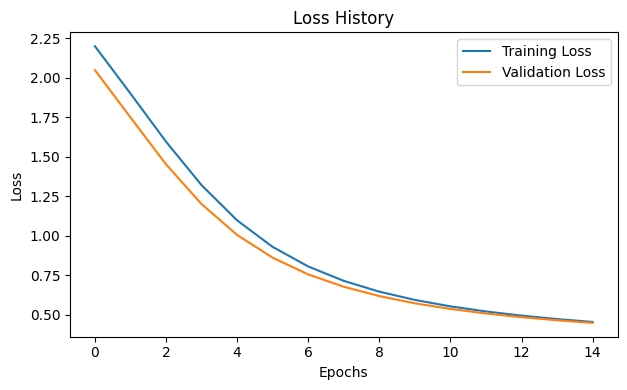


Evaluating model with leaky_relu activation...
Accuracy: 0.8793
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.92      0.93      1343
           1       0.92      0.97      0.95      1600
           2       0.88      0.83      0.85      1380
           3       0.84      0.87      0.85      1433
           4       0.87      0.89      0.88      1295
           5       0.84      0.77      0.81      1273
           6       0.90      0.93      0.91      1396
           7       0.91      0.91      0.91      1503
           8       0.85      0.81      0.83      1357
           9       0.84      0.87      0.85      1420

    accuracy                           0.88     14000
   macro avg       0.88      0.88      0.88     14000
weighted avg       0.88      0.88      0.88     14000



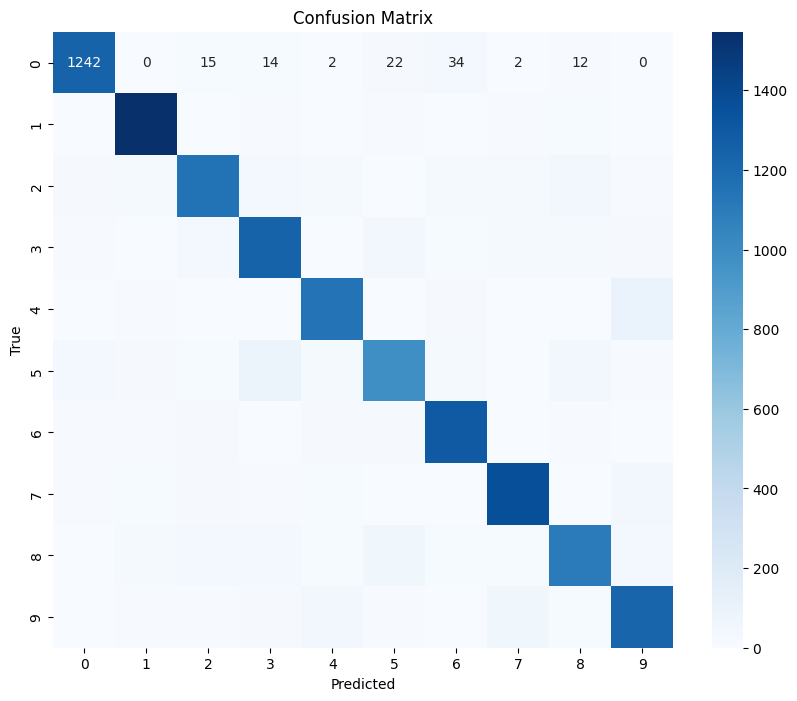

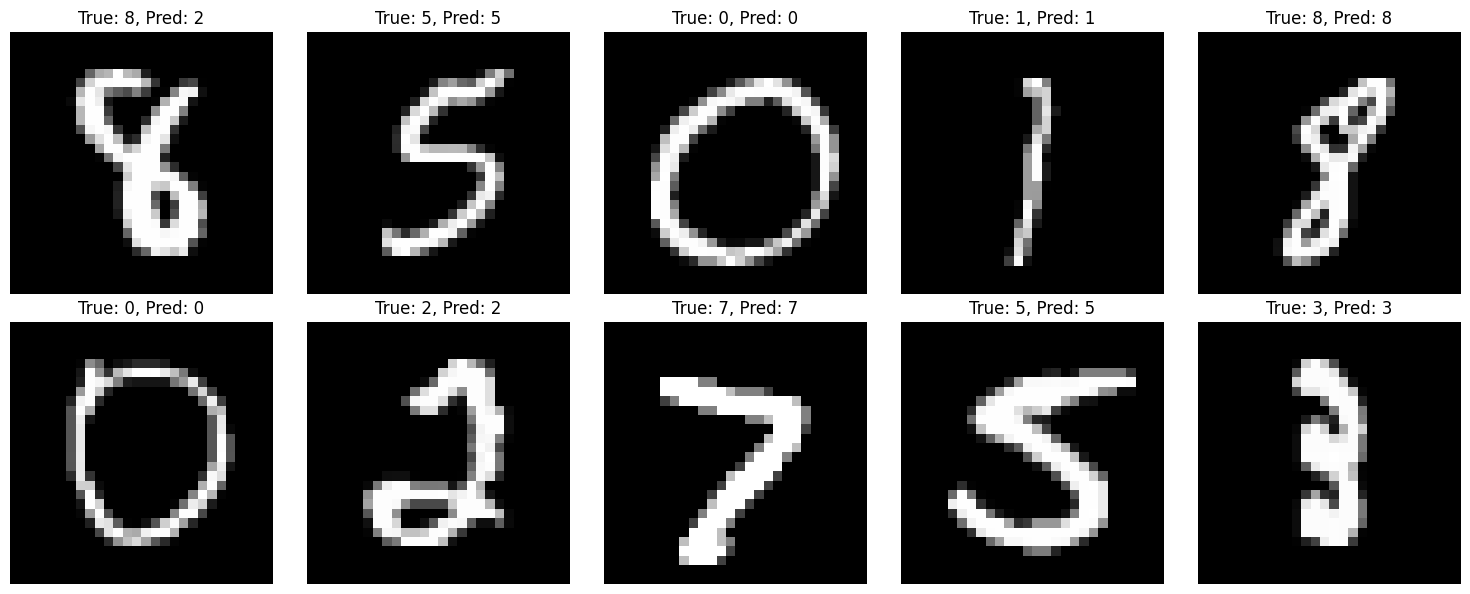


Weight distributions:


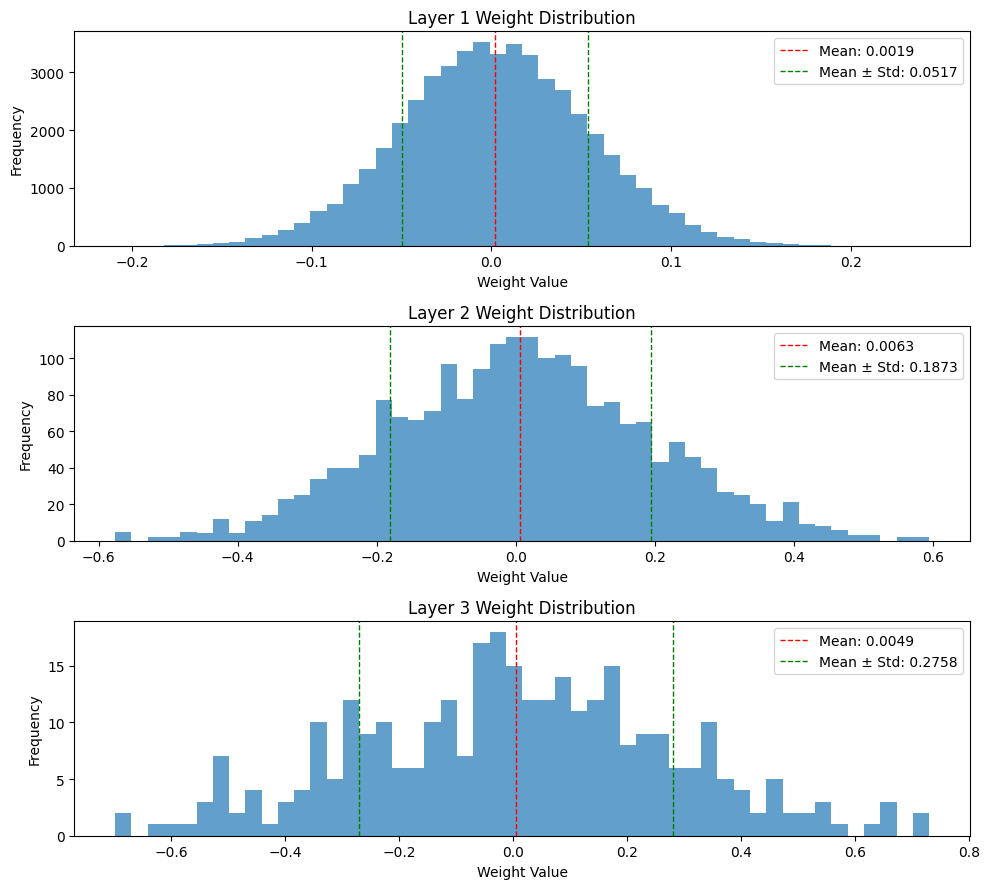


Gradient distributions:


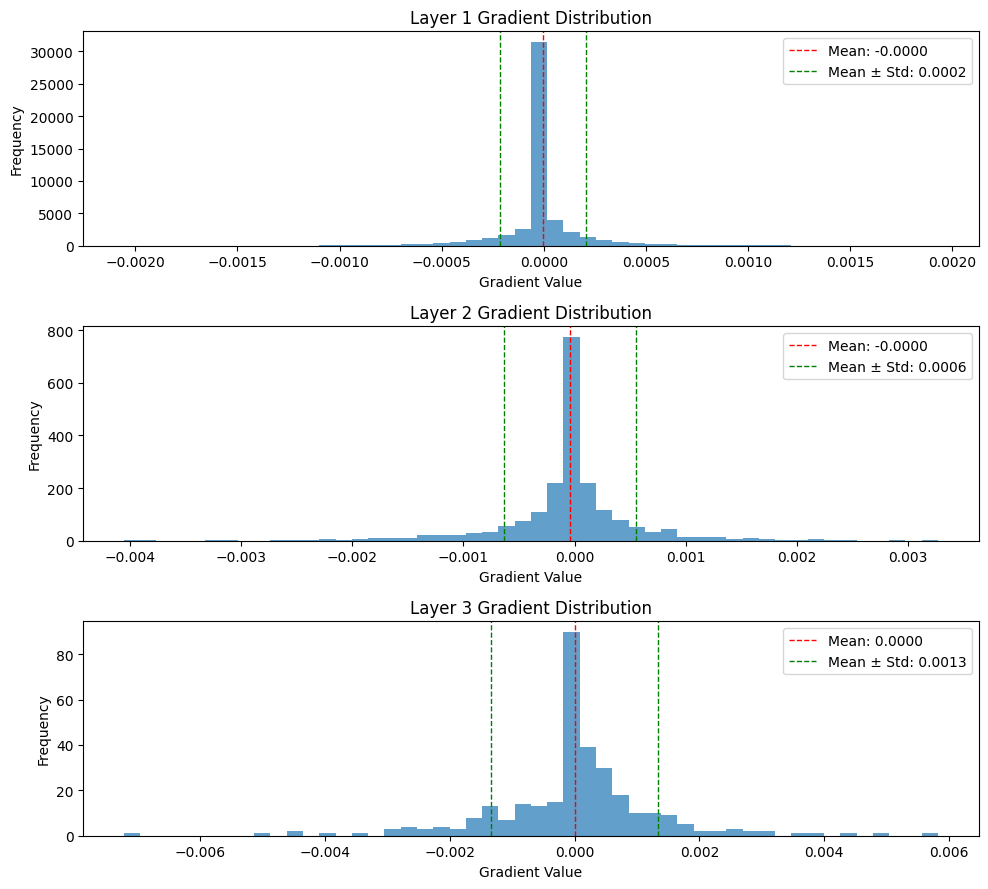


Training model with activation: elu
Epoch 1/15 [6.7%] - train_loss: 1.8735 - val_loss: 1.4469
Epoch 2/15 [13.3%] - train_loss: 1.2416 - val_loss: 1.0692
Epoch 3/15 [20.0%] - train_loss: 0.9705 - val_loss: 0.8751
Epoch 4/15 [26.7%] - train_loss: 0.8190 - val_loss: 0.7572
Epoch 5/15 [33.3%] - train_loss: 0.7218 - val_loss: 0.6777
Epoch 6/15 [40.0%] - train_loss: 0.6537 - val_loss: 0.6200
Epoch 7/15 [46.7%] - train_loss: 0.6032 - val_loss: 0.5761
Epoch 8/15 [53.3%] - train_loss: 0.5639 - val_loss: 0.5417
Epoch 9/15 [60.0%] - train_loss: 0.5327 - val_loss: 0.5141
Epoch 10/15 [66.7%] - train_loss: 0.5072 - val_loss: 0.4910
Epoch 11/15 [73.3%] - train_loss: 0.4859 - val_loss: 0.4717
Epoch 12/15 [80.0%] - train_loss: 0.4679 - val_loss: 0.4554
Epoch 13/15 [86.7%] - train_loss: 0.4524 - val_loss: 0.4416
Epoch 14/15 [93.3%] - train_loss: 0.4391 - val_loss: 0.4293
Epoch 15/15 [100.0%] - train_loss: 0.4274 - val_loss: 0.4188


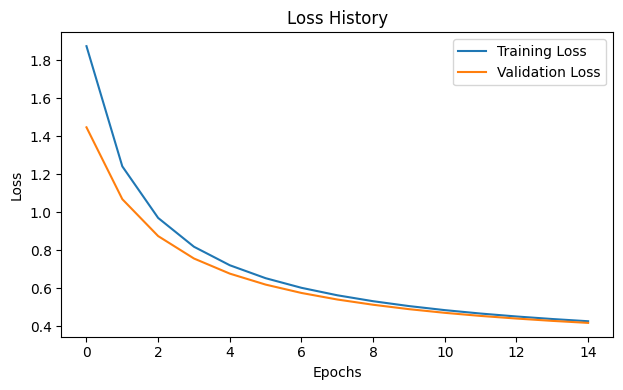


Evaluating model with elu activation...
Accuracy: 0.8848
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      1343
           1       0.92      0.97      0.94      1600
           2       0.89      0.84      0.86      1380
           3       0.86      0.87      0.86      1433
           4       0.87      0.90      0.88      1295
           5       0.86      0.78      0.82      1273
           6       0.92      0.93      0.92      1396
           7       0.92      0.90      0.91      1503
           8       0.83      0.82      0.83      1357
           9       0.85      0.86      0.86      1420

    accuracy                           0.88     14000
   macro avg       0.88      0.88      0.88     14000
weighted avg       0.88      0.88      0.88     14000



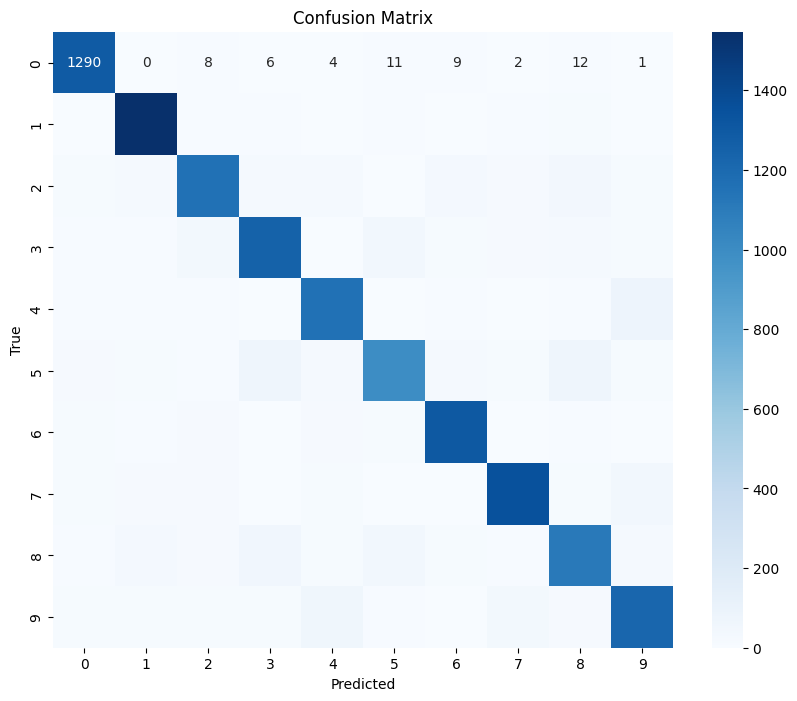

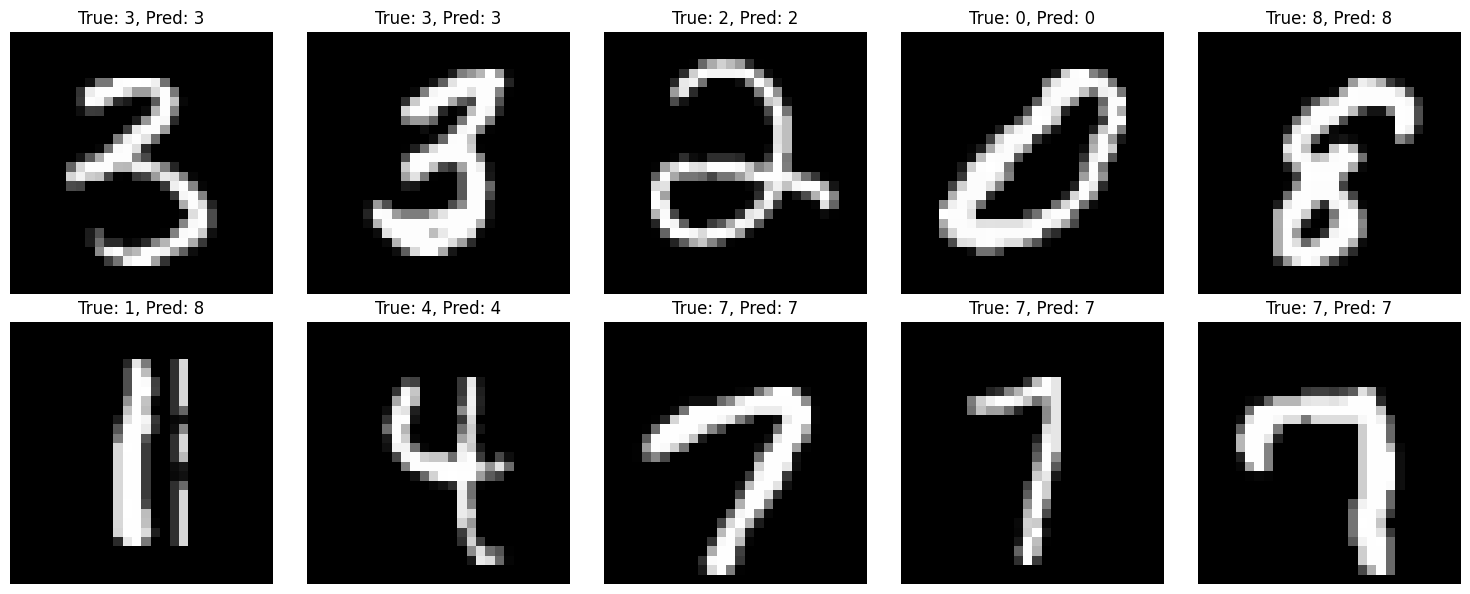


Weight distributions:


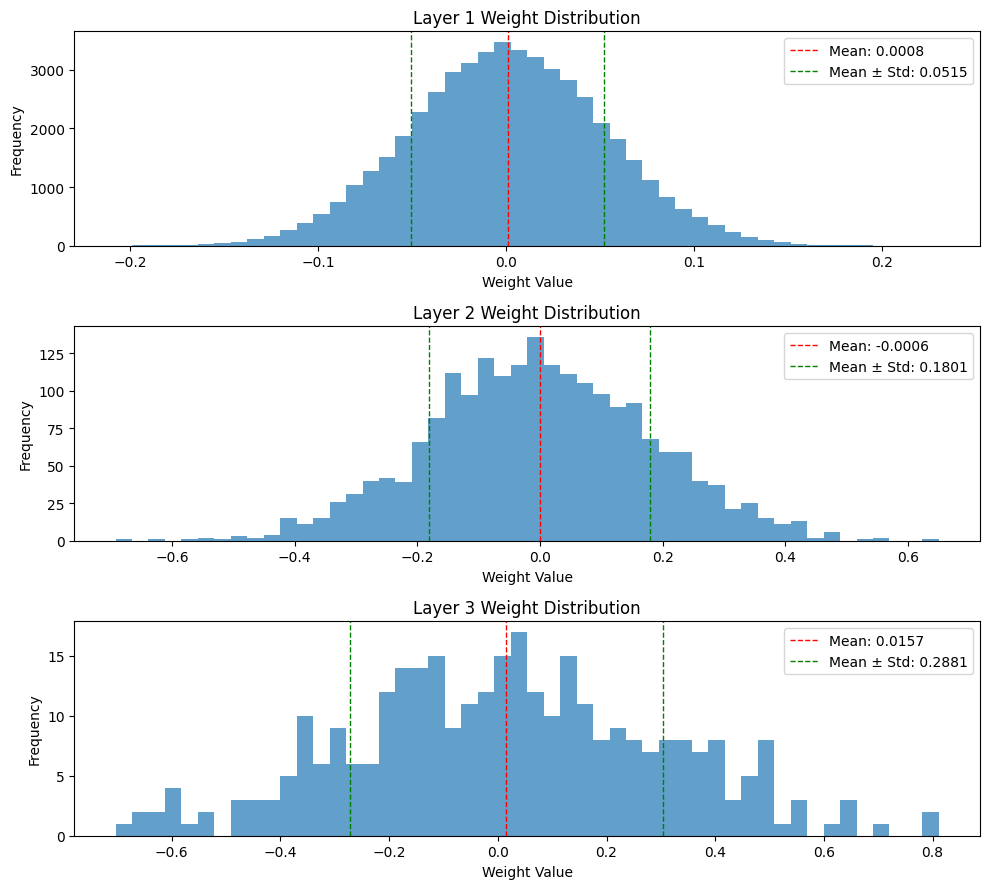


Gradient distributions:


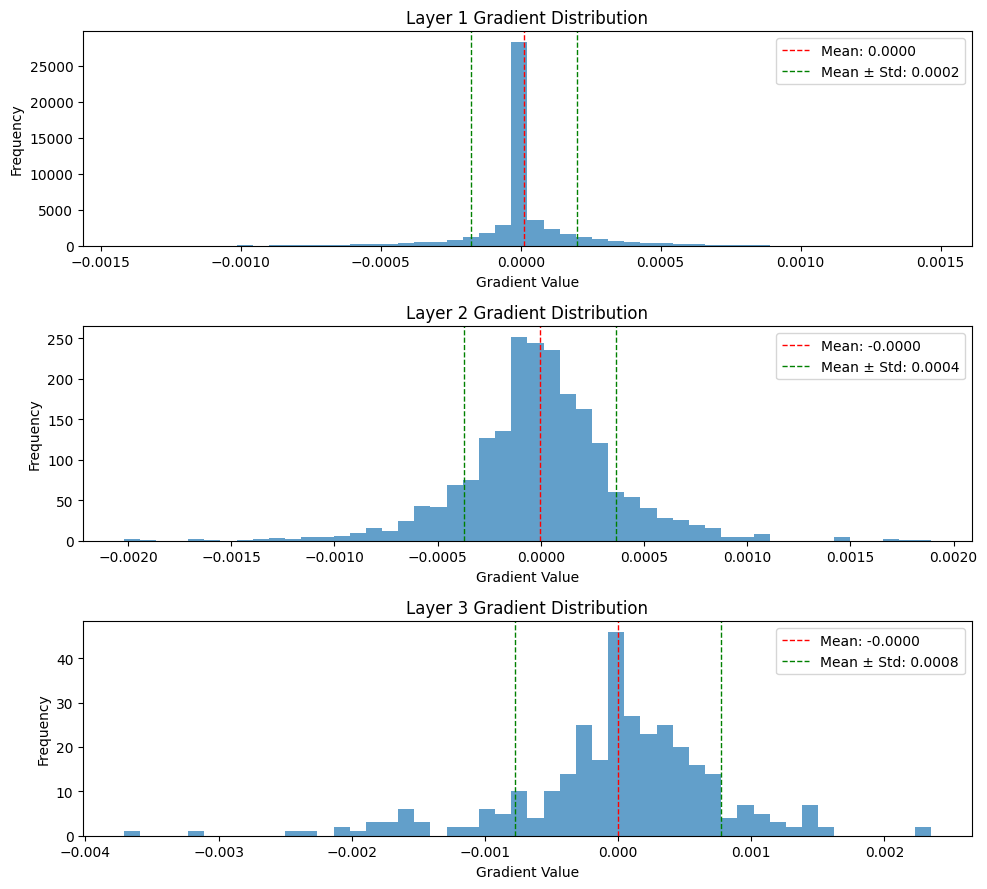


All Activation Functions Comparison Results:
   activation  accuracy  final_train_loss  final_val_loss  training_time
0        relu  0.886000          0.432086        0.426070      24.879466
1  leaky_relu  0.879286          0.455522        0.449627      23.128783
2         elu  0.884786          0.427417        0.418764      24.579618


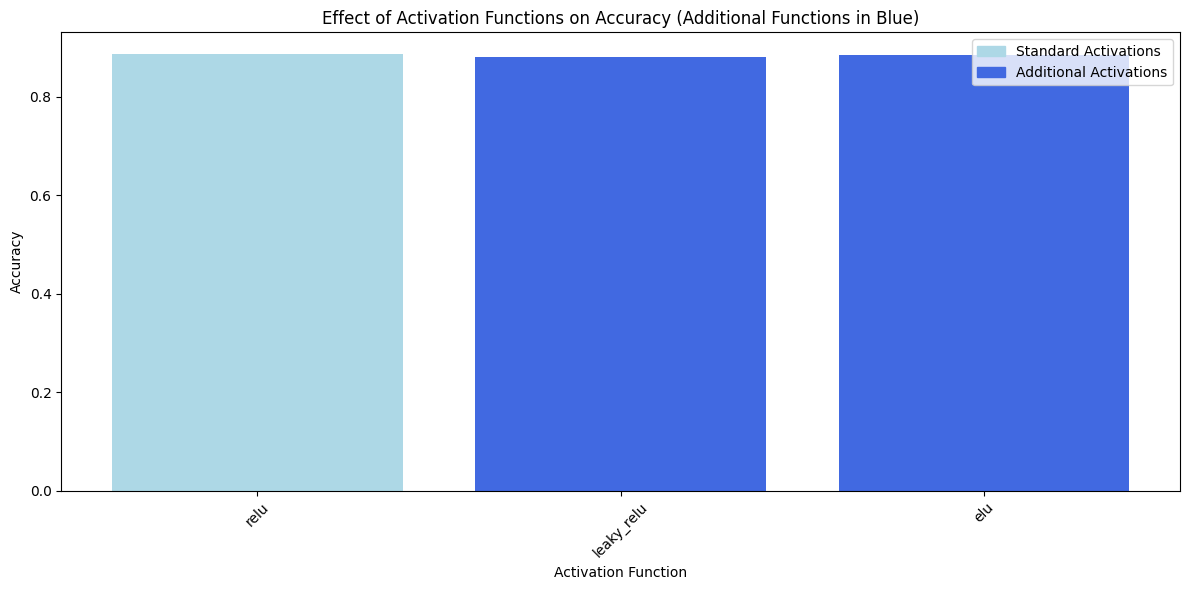

In [23]:
add_activation_results = []

for activation in all_activations:
    print(f"\nTraining model with activation: {activation}")
    
    activations = [activation] * (len(base_architecture['layers']) - 1) + ['softmax']
    
    model = FFNN_model.FeedforwardNeuralNetwork(
        input_size=X_train.shape[1],
        layer_sizes=base_architecture['layers'],
        activations=activations,
        loss=base_architecture['loss']
    )
    
    start_time = time.time()
    history = model.train(
        X_train=X_train,
        y_train=y_train_onehot,
        X_val=X_test,
        y_val=y_test_onehot,
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        learning_rate=params['learning_rate'],
        verbose=1
    )
    training_time = time.time() - start_time
    
    
    plot_history(history)
    
    
    print(f"\nEvaluating model with {activation} activation...")
    accuracy, _ = evaluate_model(model, X_test, y_test_onehot, y_test)
    
    
    print("\nWeight distributions:")
    model.plot_weight_distribution(list(range(len(base_architecture['layers']))))
    plt.show()
    
    print("\nGradient distributions:")
    model.plot_gradient_distribution(list(range(len(base_architecture['layers']))))
    plt.show()
    
    
    add_activation_results.append({
        'activation': activation,
        'accuracy': accuracy,
        'training_time': training_time,
        'final_train_loss': history['train_loss'][-1],
        'final_val_loss': history['val_loss'][-1] if 'val_loss' in history else None,
        'is_additional': activation in additional_activations
    })


print("\nAll Activation Functions Comparison Results:")
add_activation_df = pd.DataFrame(add_activation_results)
print(add_activation_df[['activation', 'accuracy', 'final_train_loss', 'final_val_loss', 'training_time']])


plt.figure(figsize=(12, 6))
bars = plt.bar(
    [r['activation'] for r in add_activation_results], 
    [r['accuracy'] for r in add_activation_results],
    color=[('royalblue' if r['is_additional'] else 'lightblue') for r in add_activation_results]
)
plt.xlabel('Activation Function')
plt.ylabel('Accuracy')
plt.title('Effect of Activation Functions on Accuracy (Additional Functions in Blue)')
plt.legend([
    plt.Rectangle((0,0),1,1, color='lightblue'),
    plt.Rectangle((0,0),1,1, color='royalblue')
], ['Standard Activations', 'Additional Activations'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()